In [1]:
import torch
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertModel, CamembertTokenizer
import json
import csv
from typing import Union, Tuple, List, Dict
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/simon/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class CamemBERTEmbed(nn.Module):
    """CamemBERT model to generate token embeddings.
    Each token is mapped to an output vector from CamemBERT.
    """
    def __init__(self, model_name_or_path: str, max_seq_length: int = 128, do_lower_case: bool = True):
        super(CamemBERTEmbed, self).__init__()
        self.config_keys = ['max_seq_length', 'do_lower_case']
        self.do_lower_case = do_lower_case

        if max_seq_length > 511:
            print("CamemBERT only allows a max_seq_length of 511 (514 with special tokens). Value will be set to 511")
            max_seq_length = 511
        self.max_seq_length = max_seq_length

        self.camembert = CamembertModel.from_pretrained(model_name_or_path)
        self.tokenizer = CamembertTokenizer.from_pretrained(model_name_or_path, do_lower_case=do_lower_case)
        self.cls_token_id = self.tokenizer.convert_tokens_to_ids([self.tokenizer.cls_token])[0]
        self.sep_token_id = self.tokenizer.convert_tokens_to_ids([self.tokenizer.sep_token])[0]

    def forward(self, features):
        """Returns token_embeddings, cls_token"""
        #CamemBERT does not use token_type_ids
        input_ids = features['input_ids']
        attention_mask = features['input_mask']
        
        output_tokens = self.camembert(input_ids=input_ids.view(-1, 131), token_type_ids=None, attention_mask=attention_mask.view(-1,131))[0]
        cls_tokens = output_tokens[:, 0, :]  # CLS token is first token
        features.update({'token_embeddings': output_tokens, 'cls_token_embeddings': cls_tokens, 'input_mask': features['input_mask']})
        return features

    def get_word_embedding_dimension(self) -> int:
        return self.camembert.config.hidden_size

    def tokenize(self, text: str) -> List[int]:
        """
        Tokenizes a text and maps tokens to token-ids
        """
        return self.tokenizer.convert_tokens_to_ids(self.tokenizer.tokenize(text))

    def get_sentence_features(self, tokens: List[int], pad_seq_length: int):
        """
        Convert tokenized sentence in its embedding ids, segment ids and mask
        :param tokens:
            a tokenized sentence
        :param pad_seq_length:
            the maximal length of the sequence. Cannot be greater than self.sentence_transformer_config.max_seq_length
        :return: embedding ids, segment ids and mask for the sentence
        """
        pad_seq_length = min(pad_seq_length, self.max_seq_length)

        tokens = tokens[:pad_seq_length]
        input_ids = [self.cls_token_id] + tokens + [self.sep_token_id] + [self.sep_token_id]
        sentence_length = len(input_ids)

        pad_seq_length += 3  ##Add Space for CLS + SEP + SEP token

        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length. BERT: Pad to the right
        padding = [0] * (pad_seq_length - len(input_ids))
        input_ids += padding

        input_mask += padding

        assert len(input_ids) == pad_seq_length
        assert len(input_mask) == pad_seq_length


        return {'input_ids': torch.tensor([np.asarray(input_ids, dtype=np.int64)]), 'input_mask': torch.tensor([np.asarray(input_mask, dtype=np.int64)]), 'sentence_lengths': np.asarray(sentence_length, dtype=np.int64)}

    def get_config_dict(self):
        return {key: self.__dict__[key] for key in self.config_keys}

    def save(self, output_path: str):
        self.camembert.save_pretrained(output_path)
        self.tokenizer.save_pretrained(output_path)

        with open(os.path.join(output_path, 'sentence_camembert_config.json'), 'w') as fOut:
            json.dump(self.get_config_dict(), fOut, indent=2)

    @staticmethod
    def load(input_path: str):
        with open(os.path.join(input_path, 'sentence_camembert_config.json')) as fIn:
            config = json.load(fIn)
        return CamemBERTEmbed(model_name_or_path=input_path, **config)


In [4]:
class Pooling(nn.Module):
    """Performs pooling (max or mean) on the token embeddings.
    Using pooling, it generates from a variable sized sentence a fixed sized sentence embedding. This layer also allows to use the CLS token if it is returned by the underlying word embedding model.
    You can concatenate multiple poolings together.
    """
    def __init__(self,
                 word_embedding_dimension: int,
                 pooling_mode_cls_token: bool = False,
                 pooling_mode_max_tokens: bool = False,
                 pooling_mode_mean_tokens: bool = True,
                 pooling_mode_mean_sqrt_len_tokens: bool = False,
                 ):
        super(Pooling, self).__init__()

        self.config_keys = ['word_embedding_dimension',  'pooling_mode_cls_token', 'pooling_mode_mean_tokens', 'pooling_mode_max_tokens', 'pooling_mode_mean_sqrt_len_tokens']

        self.word_embedding_dimension = word_embedding_dimension
        self.pooling_mode_cls_token = pooling_mode_cls_token
        self.pooling_mode_mean_tokens = pooling_mode_mean_tokens
        self.pooling_mode_max_tokens = pooling_mode_max_tokens
        self.pooling_mode_mean_sqrt_len_tokens = pooling_mode_mean_sqrt_len_tokens

        pooling_mode_multiplier = sum([pooling_mode_cls_token, pooling_mode_max_tokens, pooling_mode_mean_tokens, pooling_mode_mean_sqrt_len_tokens])
        self.pooling_output_dimension = (pooling_mode_multiplier * word_embedding_dimension)

    def forward(self, features: Dict[str, Tensor]):
        token_embeddings = features['token_embeddings']
        cls_token = features['cls_token_embeddings']
        input_mask = features['input_mask']

        ## Pooling strategy
        output_vectors = []
        if self.pooling_mode_cls_token:
            output_vectors.append(cls_token)
        if self.pooling_mode_max_tokens:
            input_mask_expanded = input_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            token_embeddings[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
            max_over_time = torch.max(token_embeddings, 1)[0]
            output_vectors.append(max_over_time)
        if self.pooling_mode_mean_tokens or self.pooling_mode_mean_sqrt_len_tokens:
            
            input_mask_expanded = input_mask.view(-1, 131).unsqueeze(-1).expand(token_embeddings.size()).float()
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)

            #If tokens are weighted (by WordWeights layer), feature 'token_weights_sum' will be present
            if 'token_weights_sum' in features:
                sum_mask = features['token_weights_sum'].unsqueeze(-1).expand(sum_embeddings.size())
            else:
                sum_mask = input_mask_expanded.sum(1)

            sum_mask = torch.clamp(sum_mask, min=1e-9)

            if self.pooling_mode_mean_tokens:
                output_vectors.append(sum_embeddings / sum_mask)
            if self.pooling_mode_mean_sqrt_len_tokens:
                output_vectors.append(sum_embeddings / torch.sqrt(sum_mask))

        output_vector = torch.cat(output_vectors, 1)
        features.update({'sentence_embedding': output_vector})
        return features

    def get_sentence_embedding_dimension(self):
        return self.pooling_output_dimension

    def get_config_dict(self):
        return {key: self.__dict__[key] for key in self.config_keys}

    def save(self, output_path):
        with open(os.path.join(output_path, 'config.json'), 'w') as fOut:
            json.dump(self.get_config_dict(), fOut, indent=2)

    @staticmethod
    def load(input_path):
        with open(os.path.join(input_path, 'config.json')) as fIn:
            config = json.load(fIn)

        return Pooling(**config)

In [5]:
class SentenceEmbedder(nn.Module):
        def __init__(self,
                model_name_or_path: str, 
                max_seq_length: int = 128, 
                do_lower_case: bool = True,
                word_embedding_dimension: int = 768,
                pooling_mode_cls_token: bool = False,
                pooling_mode_max_tokens: bool = False,
                pooling_mode_mean_tokens: bool = True,
                pooling_mode_mean_sqrt_len_tokens: bool = False,
        ):
            super(SentenceEmbedder, self).__init__() 
            self.word_embedding_model = CamemBERTEmbed(model_name_or_path, max_seq_length=max_seq_length, do_lower_case=do_lower_case)
            self.pooling_model = Pooling(self.word_embedding_model.get_word_embedding_dimension(),
                               pooling_mode_mean_tokens=pooling_mode_mean_tokens,
                               pooling_mode_cls_token=pooling_mode_cls_token,
                               pooling_mode_max_tokens=pooling_mode_max_tokens)
            self.max_seq_length = max_seq_length
            
        def forward(self, features):
            sentence_embedding_features = self.word_embedding_model(features)
            return self.pooling_model(sentence_embedding_features)['sentence_embedding']

In [6]:
model_sentence_embedder = SentenceEmbedder("camembert-base")

# model_sentence_embedder_trained = torch.load("best_trained_embedder_model_0.5737179487179487.pth")

In [7]:
text1 = "Quel temps fait il aujourd'hui ?"
text2 = "Il fait plutôt beau aujourd'hui, le soleil nous fait plaisir."

sentence_token = model_sentence_embedder.word_embedding_model.tokenize(text1)
features = model_sentence_embedder.word_embedding_model.get_sentence_features(sentence_token, model_sentence_embedder.max_seq_length)

In [8]:
features

{'input_ids': tensor([[  5, 796, 125,  82,  51, 405,  11, 265, 106,   6,   6,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   0]]),
 'input_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [9]:
def cosin(a,b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

In [10]:
corpus = ['Pourquoi confiner les Français chez eux ?',
          'Combien de temps durera le confinement ?',
          'Combien de temps dois-je rester confiné pour être sûr de ne pas être infecté ?',
          "Les territoires d'outre-mer sont-ils concernés par le confinement ?",
          'Puis-je aller travailler pendant le confinement ?',
          "Ai-je besoin d'un document pour sortir de chez moi ?",
          "Que faire si je n'ai pas d'imprimante pour imprimer l'« attestation de déplacement dérogatoire » ?",
          "Dois-je prouver où j'habite pour pouvoir sortir ?",
          "Qu'est-ce que je risque si j'enfreins les consignes de confinement ?",
          "Puis-je sortir plusieurs fois par jour ?",
          "Qui est responsable de faire respecter le confinement ?",
          "L'armée a-t-elle été sollicitée pour faire respecter le confinement ?",
          "Puis-je sortir faire du sport ?",
          "Puis-je sortir pour me promener ?",
          "Puis-je aller chez mes voisins ?",
          "Si je me fais livrer (objets, colis, nourriture), dois-je tout désinfecter ?",
          "Puis-je aller faire mon plein d'essence ?",
          "Je suis enseignant. Ai-je le droit de télétravailler ?",
          "Je ne peux pas télétravailler. Vais-je toucher mon salaire?",
          "Que deviennent les personnes sans abri ?",
          "Comment attrape-t-on ce virus ?",
          "Quelles précautions faut-il prendre individuellement ?",
          "Pourquoi la situation en Italie inquiète-t-elle autant ?",
          "Que sait-on de la létalité de ce virus ?",
          "Quels effets sur l'économie française ?",
          "Comment limiter les effets de la maladie ?",
          "Quels sont les stades de la maladie ?",
          "Comment les tests de diagnostic fonctionnent-ils ?",
          "Quelle est la différence entre Covid-2019 et SARS-CoV-2 ?",
          "Comment développe-t-on des médicaments ou des vaccins ?",
          "La chloroquine est évoquée comme un médicament efficace contre ce virus, qu'en est-il ?",
          "Le coronavirus se transmet-il par les objets (billets de banque, colis) ?",
          "Combien de pays sont touchés ?",
          "Quelles précautions pour les étudiants français en Chine ?",
          "Quels effets sur l'économie mondiale ?",
          "Comment la France se prépare-t-elle à l'apparition de nouveaux cas ?",
          "Quelles sont les mesures prises aux frontières françaises ?",
          "Le réseau de santé français est-il capable de gérer une épidémie en France ?",
          "Quelles sont les mesures mises en place dans les écoles, collèges et lycées ?",
          "Faut-il faire des provisions de masques ?",
          "A quel moment parle-t-on d'une pandémie ?",
          "Quels sont les foyers épidémiques hors de Chine ?",
          "Quelles sont les mesures de quarantaine prises en Italie ?",
          "Que faire si l'on revient d'Italie ou de Chine ?",
          "Faut-il annuler les séjours touristiques (Italie, Chine, etc.), et si oui, est-on remboursé ?",
         ]

X = []

for i in range(len(corpus)):
    sentence_token = model_sentence_embedder.word_embedding_model.tokenize(corpus[i])
    features = model_sentence_embedder.word_embedding_model.get_sentence_features(sentence_token, model_sentence_embedder.max_seq_length)
    X.append(model_sentence_embedder(features)[0].detach().numpy())
    
X = np.array(X)    

In [11]:
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)
pca_results = pca.transform(X)

[0.2724624  0.10837834]


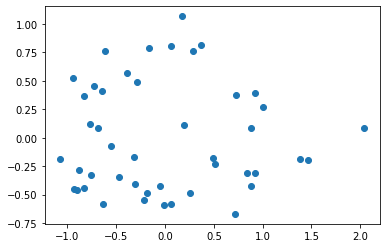

In [12]:
plt.scatter(pca_results[:,0], pca_results[:,1])

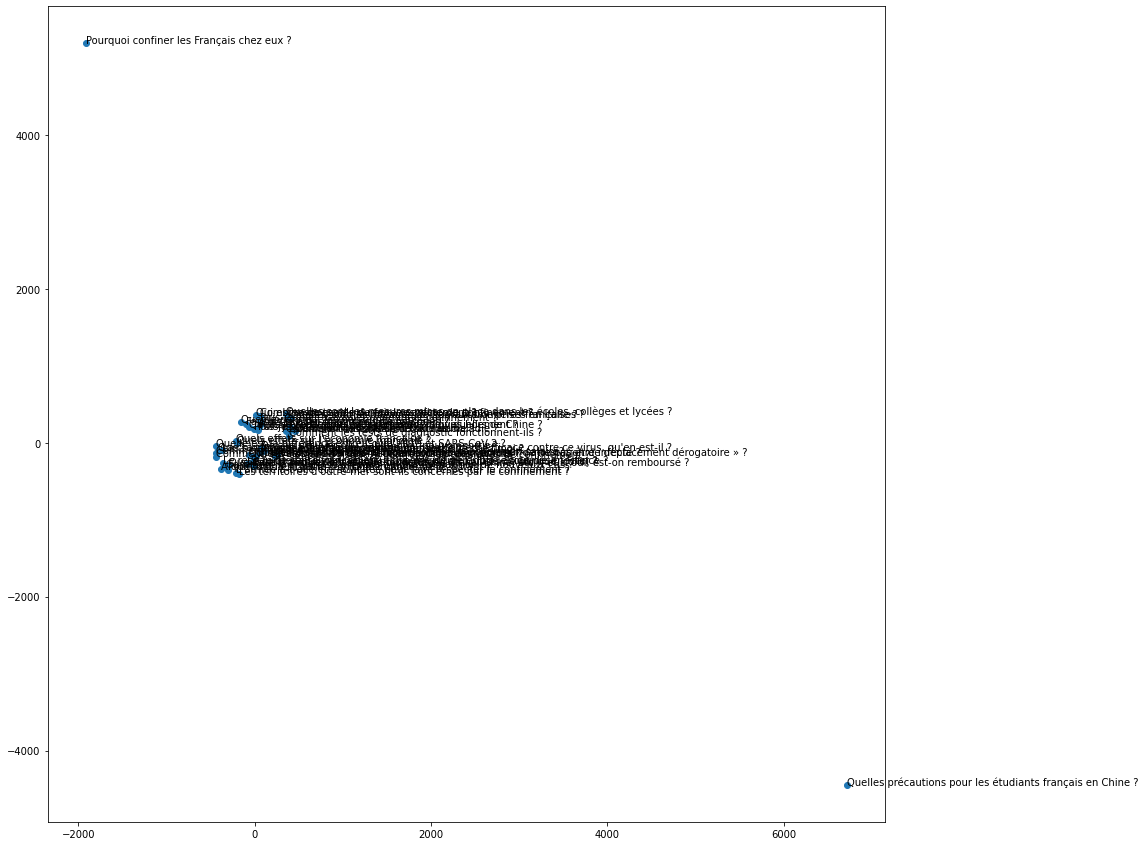

In [13]:
X_embedded = TSNE(n_components=2, perplexity=3).fit_transform(X)

fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(X_embedded[:,0], X_embedded[:,1])

for i in range(len(corpus)):
    ax.annotate(corpus[i], (X_embedded[:,0][i], X_embedded[:,1][i]))

In [13]:
pca_queries = pca.transform(query_embeddings)

is_query = [0 for i in range(len(corpus))] + [1 for i in range(len(queries))]
colors = ["red" if q == 1 else "blue" for q in is_query]

print(colors)

res = np.concatenate((pca_results, pca_queries), axis=0)


fig, ax = plt.subplots(figsize=(15, 15))
ax.scatter(res[:,0], res[:,1], s=50, c=colors)

for i in range(len(corpus)):
    ax.annotate(corpus[i], (pca_results[:,0][i], pca_results[:,1][i]))

for j in range(len(queries)):
    ax.annotate(queries[j], (pca_queries[:,0][j], pca_queries[:,1][j]))


NameError: name 'query_embeddings' is not defined

In [14]:
queries = ['Que faire pour se protéger du virus ?', "Où en est l'épidémie en Italie ?", "Ma femme est institutrice, que faire ?", "Est il possible d'aller se balader ?", "Je reviens de l'étranger, que dois-je faire à mon arrivée ?", "Avec quoi peut-on se protéger ?", "Pourquoi parle-t-on de pandémie ?", "Puis-je partir en vacances ?"]
query_embeddings = []
for i in range(len(queries)):
    sentence_token = model_sentence_embedder.word_embedding_model.tokenize(queries[i])
    features = model_sentence_embedder.word_embedding_model.get_sentence_features(sentence_token, model_sentence_embedder.max_seq_length)
    query_embeddings.append(model_sentence_embedder(features)[0].detach().numpy())

query_embeddings = np.array(query_embeddings)

for query, query_embedding in zip(queries, query_embeddings):
    print(query)
    distances = []
    for j in range(len(X)):
        distances.append(cosin(query_embedding, X[j]))
    best_indices = np.argsort(np.array(distances))[::-1][:3]
    for k in range(len(best_indices)):
        print(distances[best_indices[k]], corpus[best_indices[k]])
    print()

Que faire pour se protéger du virus ?
0.9422816 Comment limiter les effets de la maladie ?
0.92220855 Que sait-on de la létalité de ce virus ?
0.9206825 Qui est responsable de faire respecter le confinement ?

Où en est l'épidémie en Italie ?
0.9218938 Quelles sont les mesures de quarantaine prises en Italie ?
0.91874653 Comment la France se prépare-t-elle à l'apparition de nouveaux cas ?
0.9182162 Que faire si l'on revient d'Italie ou de Chine ?

Ma femme est institutrice, que faire ?
0.9323734 Je suis enseignant. Ai-je le droit de télétravailler ?
0.92455554 Puis-je aller chez mes voisins ?
0.92334366 Puis-je sortir faire du sport ?

Est il possible d'aller se balader ?
0.9413682 Puis-je sortir pour me promener ?
0.93629265 Puis-je aller chez mes voisins ?
0.9346826 Puis-je sortir faire du sport ?

Je reviens de l'étranger, que dois-je faire à mon arrivée ?
0.9181911 Ai-je besoin d'un document pour sortir de chez moi ?
0.9107532 Dois-je prouver où j'habite pour pouvoir sortir ?
0.910

In [15]:
class SiameseCamemBERT(nn.Module):
    def __init__(self,
                model_name_or_path: str, 
                max_seq_length: int = 128, 
                do_lower_case: bool = True,
                word_embedding_dimension: int = 768,
                pooling_mode_cls_token: bool = False,
                pooling_mode_max_tokens: bool = False,
                pooling_mode_mean_tokens: bool = True,
                pooling_mode_mean_sqrt_len_tokens: bool = False,
        ):
            super(SiameseCamemBERT, self).__init__() 
            self.sentence_embedder = SentenceEmbedder(
                model_name_or_path, 
                max_seq_length=max_seq_length, 
                do_lower_case=do_lower_case,
                word_embedding_dimension=word_embedding_dimension,
                pooling_mode_cls_token=pooling_mode_cls_token,
                pooling_mode_max_tokens=pooling_mode_max_tokens,
                pooling_mode_mean_tokens=pooling_mode_mean_tokens,
                pooling_mode_mean_sqrt_len_tokens=pooling_mode_mean_sqrt_len_tokens
            )
            self.linear = torch.nn.Linear(3*word_embedding_dimension, 3)
            
    def forward(self, x):
        u = self.sentence_embedder(x["sentence1"])
        v = self.sentence_embedder(x["sentence2"])
        d = torch.abs(u - v)
        z = torch.cat((u, v, d), 1)
        return self.linear(z)

In [16]:
class XNLIDataset(Dataset):
    def __init__(self, sentence_embedder_model, tsv_file_path="french_XNLI/multinli.train.fr.tsv"):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_file = pd.read_csv(tsv_file_path, sep='\t')[["premise", "hypo", "label"]]
        self.sentence_embedder_model = sentence_embedder_model

    def __len__(self):
        return len(self.data_file)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.data_file.iloc[idx]
        
        sentence_token1 = self.sentence_embedder_model.word_embedding_model.tokenize(row["premise"])
        features1 = self.sentence_embedder_model.word_embedding_model.get_sentence_features(sentence_token1, self.sentence_embedder_model.max_seq_length)
        
        sentence_token2 = self.sentence_embedder_model.word_embedding_model.tokenize(row["hypo"])
        features2 = self.sentence_embedder_model.word_embedding_model.get_sentence_features(sentence_token2, self.sentence_embedder_model.max_seq_length)
        
        sample = {
            "sentence1": features1,
            "sentence2": features2,
            "label": row["label"]
        }
        
        return sample

In [18]:
train_dataset = XNLIDataset(model_sentence_embedder, tsv_file_path="french_XNLI/multinli.train.fr.tsv")

/home/simon/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2901: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [19]:
dev_dataset = XNLIDataset(model_sentence_embedder, tsv_file_path="french_XNLI/xnli.dev.fr.tsv")

In [35]:
max = 0
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    if i % 100000 == 0:
        print(i,sample)

0 {'sentence1': {'input_ids': tensor([[    5,    17,    11,  7403,   845,   215,   491,  1919,  3974,     8,
            13,  2108,    33,   116,  4214, 16074,    43,    16,   501,    14,
            13, 12910,    21,     9,     6,     6,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,

KeyboardInterrupt: 

In [15]:
def get_targets(labels):
    
    def get_target(label):
        if label == 'contradictory':
            return torch.tensor([0])
        elif label == 'neutral':
            return torch.tensor([1])
        else:
            return torch.tensor([2])
    
    return torch.tensor(list(map(get_target,labels)))


labels = ['neutral', 'contradictory']
print(get_targets(labels))

tensor([1, 0])


In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=16,
                        shuffle=True, num_workers=8)
dev_dataloader = DataLoader(dev_dataset, batch_size=4, num_workers=8)

In [18]:
train_model = SiameseCamemBERT("camembert-base")

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(train_model.parameters(), lr=0.000005)

In [26]:
a = next(iter(train_dataloader))
a

output = train_model(a)
print(output)
loss = loss_fn(output, get_targets(a['label']))

tensor([[ 0.0224, -0.0470,  0.0745],
        [-0.0466, -0.0777,  0.0757],
        [ 0.0314, -0.0754,  0.1006],
        [-0.0204, -0.0544,  0.1199],
        [-0.0659, -0.0713,  0.1577],
        [ 0.0055, -0.0814,  0.1123],
        [ 0.0190, -0.0651,  0.0892],
        [-0.0392, -0.0478,  0.1164],
        [-0.0599, -0.0489,  0.1342],
        [-0.0184, -0.0509,  0.0954],
        [ 0.0057, -0.0812,  0.1143],
        [-0.0540, -0.0298,  0.1072],
        [-0.0299, -0.1043,  0.1187],
        [ 0.0380, -0.0544,  0.0859],
        [-0.0116, -0.0914,  0.1230],
        [-0.0124, -0.0555,  0.1150]], grad_fn=<AddmmBackward>)


In [21]:
def get_acc(out, targets):
    s = 0
    for i in range(targets.size()[0]):
        _, argmax = out[i].max(0)
        if argmax == targets[i]:
            s += 1
    return s


def validate():
    
    val_acc = 0
    n = len(dev_dataloader)
    
    train_model.eval()
    for i_batch, sample_batched in enumerate(dev_dataloader):
        output = train_model(sample_batched)
        print(get_acc(output, get_targets(sample_batched['label'])))
        val_acc += get_acc(output, get_targets(sample_batched['label']))
        
validate()

1
0
1
1


KeyboardInterrupt: 

In [40]:
n_epochs = 5

loss_arr = np.zeros(1000)

for i in range(n_epochs):

    for i_batch, sample_batched in enumerate(train_dataloader):
        train_model.train()

        with torch.set_grad_enabled(True):
            output = train_model(sample_batched)
            print(output)
            loss = loss_fn(output, get_targets(sample_batched['label']))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_arr[i_batch % 1000] = loss.detach().numpy()
            
            if i_batch % 100 == 0:
                print(i_batch)
                print(sum(loss_arr) / 1000)
                print()

OSError: [Errno 12] Cannot allocate memory

In [ ]:
tsv_file_path = "french_XNLI/multinli.train.fr.tsv"
data_file = pd.read_csv(tsv_file_path, sep='\t')

In [ ]:
data_file[["premise", "hypo", "label"]]

In [31]:
with open('/home/simon/Bureau/fastquest/train-v2.0.json') as f:
    data = json.load(f)
    
    print(data["data"][0])

{'title': 'Beyoncé', 'paragraphs': [{'qas': [{'question': 'When did Beyonce start becoming popular?', 'id': '56be85543aeaaa14008c9063', 'answers': [{'text': 'in the late 1990s', 'answer_start': 269}], 'is_impossible': False}, {'question': 'What areas did Beyonce compete in when she was growing up?', 'id': '56be85543aeaaa14008c9065', 'answers': [{'text': 'singing and dancing', 'answer_start': 207}], 'is_impossible': False}, {'question': "When did Beyonce leave Destiny's Child and become a solo singer?", 'id': '56be85543aeaaa14008c9066', 'answers': [{'text': '2003', 'answer_start': 526}], 'is_impossible': False}, {'question': 'In what city and state did Beyonce  grow up? ', 'id': '56bf6b0f3aeaaa14008c9601', 'answers': [{'text': 'Houston, Texas', 'answer_start': 166}], 'is_impossible': False}, {'question': 'In which decade did Beyonce become famous?', 'id': '56bf6b0f3aeaaa14008c9602', 'answers': [{'text': 'late 1990s', 'answer_start': 276}], 'is_impossible': False}, {'question': 'In what 

In [1]:
d = {
    'title': 'Beyoncé', 
    'paragraphs': [
        {'qas': 
         [{'question': 'When did Beyonce start becoming popular?', 'id': '56be85543aeaaa14008c9063', 
           'answers': [{'text': 'in the late 1990s', 'answer_start': 269}], 'is_impossible': False}, 
          {'question': 'What areas did Beyonce compete in when she was growing up?', 'id': '56be85543aeaaa14008c9065', 
           'answers': [{'text': 'singing and dancing', 'answer_start': 207}], 'is_impossible': False}, 
          {'question': "When did Beyonce leave Destiny's Child and become a solo singer?", 'id': '56be85543aeaaa14008c9066', 
           'answers': [{'text': '2003', 'answer_start': 526}], 'is_impossible': False}, 
          {'question': 'In what city and state did Beyonce  grow up? ', 'id': '56bf6b0f3aeaaa14008c9601', 
           'answers': [{'text': 'Houston, Texas', 'answer_start': 166}], 'is_impossible': False}, 
          {'question': 'In which decade did Beyonce become famous?', 'id': '56bf6b0f3aeaaa14008c9602', 
           'answers': [{'text': 'late 1990s', 'answer_start': 276}], 'is_impossible': False}, 
          {'question': 'In what R&B group was she the lead singer?', 'id': '56bf6b0f3aeaaa14008c9603', 
           'answers': [{'text': "Destiny's Child", 'answer_start': 320}], 'is_impossible': False}, 
          {'question': 'What album made her a worldwide known artist?', 'id': '56bf6b0f3aeaaa14008c9604', 
           'answers': [{'text': 'Dangerously in Love', 'answer_start': 505}], 'is_impossible': False}, 
          {'question': "Who managed the Destiny's Child group?", 'id': '56bf6b0f3aeaaa14008c9605', 
           'answers': [{'text': 'Mathew Knowles', 'answer_start': 360}], 'is_impossible': False}, 
          {'question': 'When did Beyoncé rise to fame?', 'id': '56d43c5f2ccc5a1400d830a9', 
           'answers': [{'text': 'late 1990s', 'answer_start': 276}], 'is_impossible': False}, 
          {'question': "What role did Beyoncé have in Destiny's Child?", 'id': '56d43c5f2ccc5a1400d830aa', 
           'answers': [{'text': 'lead singer', 'answer_start': 290}], 'is_impossible': False}, 
          {'question': 'What was the first album Beyoncé released as a solo artist?', 'id': '56d43c5f2ccc5a1400d830ab', 
           'answers': [{'text': 'Dangerously in Love', 'answer_start': 505}], 'is_impossible': False}, 
          {'question': 'When did Beyoncé release Dangerously in Love?', 'id': '56d43c5f2ccc5a1400d830ac',
           'answers': [{'text': '2003', 'answer_start': 526}], 'is_impossible': False},
          {'question': 'How many Grammy awards did Beyoncé win for her first solo album?', 'id': '56d43c5f2ccc5a1400d830ad', 
           'answers': [{'text': 'five', 'answer_start': 590}], 'is_impossible': False},
          {'question': "What was Beyoncé's role in Destiny's Child?", 'id': '56d43ce42ccc5a1400d830b4', 
           'answers': [{'text': 'lead singer', 'answer_start': 290}], 'is_impossible': False}, 
          {'question': "What was the name of Beyoncé's first solo album?", 'id': '56d43ce42ccc5a1400d830b5', 
           'answers': [{'text': 'Dangerously in Love', 'answer_start': 505}], 'is_impossible': False}],
         'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'},
        {'qas': [{'question': 'After her second solo album, what other entertainment venture did Beyonce explore?', 'id': '56be86cf3aeaaa14008c9076', 'answers': [{'text': 'acting', 'answer_start': 207}], 'is_impossible': False}, {'question': 'Which artist did Beyonce marry?', 'id': '56be86cf3aeaaa14008c9078', 'answers': [{'text': 'Jay Z', 'answer_start': 369}], 'is_impossible': False}, {'question': 'To set the record for Grammys, how many did Beyonce win?', 'id': '56be86cf3aeaaa14008c9079', 'answers': [{'text': 'six', 'answer_start': 565}], 'is_impossible': False}, {'question': 'For what movie did Beyonce receive  her first Golden Globe nomination?', 'id': '56bf6e823aeaaa14008c9627', 'answers': [{'text': 'Dreamgirls', 'answer_start': 260}], 'is_impossible': False}, {'question': 'When did Beyonce take a hiatus in her career and take control of her management?', 'id': '56bf6e823aeaaa14008c9629', 'answers': [{'text': '2010', 'answer_start': 586}], 'is_impossible': False}, {'question': 'Which album was darker in tone from her previous work?', 'id': '56bf6e823aeaaa14008c962a', 'answers': [{'text': 'Beyoncé', 'answer_start': 180}], 'is_impossible': False}, {'question': 'After what movie portraying Etta James, did Beyonce create Sasha Fierce?', 'id': '56bf6e823aeaaa14008c962b', 'answers': [{'text': 'Cadillac Records', 'answer_start': 406}], 'is_impossible': False}, {'question': "When did Destiny's Child end their group act?", 'id': '56d43da72ccc5a1400d830bd', 'answers': [{'text': 'June 2005', 'answer_start': 48}], 'is_impossible': False}, {'question': "What was the name of Beyoncé's second solo album?", 'id': '56d43da72ccc5a1400d830be', 'answers': [{'text': "B'Day", 'answer_start': 95}], 'is_impossible': False}, {'question': "What was Beyoncé's first acting job, in 2006?", 'id': '56d43da72ccc5a1400d830bf', 'answers': [{'text': 'Dreamgirls', 'answer_start': 260}], 'is_impossible': False}, {'question': 'Who is Beyoncé married to?', 'id': '56d43da72ccc5a1400d830c0', 'answers': [{'text': 'Jay Z', 'answer_start': 369}], 'is_impossible': False}, {'question': "What is the name of Beyoncé's alter-ego?", 'id': '56d43da72ccc5a1400d830c1', 'answers': [{'text': 'Sasha Fierce', 'answer_start': 466}], 'is_impossible': False}], 'context': 'Following the disbandment of Destiny\'s Child in June 2005, she released her second solo album, B\'Day (2006), which contained hits "Déjà Vu", "Irreplaceable", and "Beautiful Liar". Beyoncé also ventured into acting, with a Golden Globe-nominated performance in Dreamgirls (2006), and starring roles in The Pink Panther (2006) and Obsessed (2009). Her marriage to rapper Jay Z and portrayal of Etta James in Cadillac Records (2008) influenced her third album, I Am... Sasha Fierce (2008), which saw the birth of her alter-ego Sasha Fierce and earned a record-setting six Grammy Awards in 2010, including Song of the Year for "Single Ladies (Put a Ring on It)". Beyoncé took a hiatus from music in 2010 and took over management of her career; her fourth album 4 (2011) was subsequently mellower in tone, exploring 1970s funk, 1980s pop, and 1990s soul. Her critically acclaimed fifth studio album, Beyoncé (2013), was distinguished from previous releases by its experimental production and exploration of darker themes.'}, {'qas': [{'question': 'In her music, what are some recurring elements in them?', 'id': '56be88473aeaaa14008c9080', 'answers': [{'text': 'love, relationships, and monogamy', 'answer_start': 104}], 'is_impossible': False}, {'question': 'Time magazine named her one of the most 100 what people of the century?', 'id': '56be88473aeaaa14008c9083', 'answers': [{'text': 'influential', 'answer_start': 935}], 'is_impossible': False}, {'question': 'Which magazine declared her the most dominant woman musician?', 'id': '56be88473aeaaa14008c9084', 'answers': [{'text': 'Forbes', 'answer_start': 985}], 'is_impossible': False}, {'question': 'In which decade did the Recording Industry Association of America recognize Beyonce as the The Top Certified Artist?', 'id': '56bf725c3aeaaa14008c9643', 'answers': [{'text': '2000s', 'answer_start': 736}], 'is_impossible': False}, {'question': 'What magazine rated Beyonce as the most powerful female musician in 2015?', 'id': '56bf725c3aeaaa14008c9644', 'answers': [{'text': 'Forbes', 'answer_start': 985}], 'is_impossible': False}, {'question': 'How did Beyonce describe herself as a feminist?', 'id': '56bf725c3aeaaa14008c9645', 'answers': [{'text': 'modern-day feminist', 'answer_start': 18}], 'is_impossible': False}, {'question': 'In which years did Time rate Beyonce in the 100 most influential people in the world?', 'id': '56bf725c3aeaaa14008c9646', 'answers': [{'text': '2013 and 2014', 'answer_start': 970}], 'is_impossible': False}, {'question': 'How many records has Beyonce sold in her 19 year career?', 'id': '56bf725c3aeaaa14008c9647', 'answers': [{'text': '118 million', 'answer_start': 393}], 'is_impossible': False}, {'question': "How many records did Beyoncé sell as part of Destiny's Child?", 'id': '56d43f7e2ccc5a1400d830c7', 'answers': [{'text': '60 million', 'answer_start': 445}], 'is_impossible': False}, {'question': "After leaving Destiny's Child, how many records did Beyoncé release under her own name?", 'id': '56d43f7e2ccc5a1400d830c8', 'answers': [{'text': '118 million', 'answer_start': 393}], 'is_impossible': False}, {'question': 'How many Grammy awards has Beyoncé won?', 'id': '56d43f7e2ccc5a1400d830c9', 'answers': [{'text': '20', 'answer_start': 552}], 'is_impossible': False}, {'question': 'What magazine named Beyoncé as the most powerful female musician for 2015?', 'id': '56d43f7e2ccc5a1400d830cb', 'answers': [{'text': 'Forbes', 'answer_start': 985}], 'is_impossible': False}], 'context': 'A self-described "modern-day feminist", Beyoncé creates songs that are often characterized by themes of love, relationships, and monogamy, as well as female sexuality and empowerment. On stage, her dynamic, highly choreographed performances have led to critics hailing her as one of the best entertainers in contemporary popular music. Throughout a career spanning 19 years, she has sold over 118 million records as a solo artist, and a further 60 million with Destiny\'s Child, making her one of the best-selling music artists of all time. She has won 20 Grammy Awards and is the most nominated woman in the award\'s history. The Recording Industry Association of America recognized her as the Top Certified Artist in America during the 2000s decade. In 2009, Billboard named her the Top Radio Songs Artist of the Decade, the Top Female Artist of the 2000s and their Artist of the Millennium in 2011. Time listed her among the 100 most influential people in the world in 2013 and 2014. Forbes magazine also listed her as the most powerful female musician of 2015.'}, {'qas': [{'question': "Beyonce's younger sibling also sang with her in what band?", 'id': '56be892d3aeaaa14008c908b', 'answers': [{'text': "Destiny's Child", 'answer_start': 303}], 'is_impossible': False}, {'question': 'Where did Beyonce get her name from?', 'id': '56be892d3aeaaa14008c908c', 'answers': [{'text': "her mother's maiden name", 'answer_start': 204}], 'is_impossible': False}, {'question': "What race was Beyonce's father?", 'id': '56be892d3aeaaa14008c908d', 'answers': [{'text': 'African-American', 'answer_start': 330}], 'is_impossible': False}, {'question': "Beyonce's childhood home believed in what religion?", 'id': '56be892d3aeaaa14008c908e', 'answers': [{'text': 'Methodist', 'answer_start': 578}], 'is_impossible': False}, {'question': "Beyonce's father worked as a sales manager for what company?", 'id': '56bf74d53aeaaa14008c9659', 'answers': [{'text': 'Xerox', 'answer_start': 152}], 'is_impossible': False}, {'question': "Beyonce's mother worked in what industry?", 'id': '56bf74d53aeaaa14008c965a', 'answers': [{'text': 'hairdresser and salon owner', 'answer_start': 101}], 'is_impossible': False}, {'question': "What younger sister of Beyonce also appeared in Destiny's Child?", 'id': '56bf74d53aeaaa14008c965b', 'answers': [{'text': 'Solange', 'answer_start': 255}], 'is_impossible': False}, {'question': 'Beyonce is a descendent of what Arcadian leader?', 'id': '56bf74d53aeaaa14008c965d', 'answers': [{'text': 'Joseph Broussard', 'answer_start': 540}], 'is_impossible': False}, {'question': "What company did Beyoncé's father work for when she was a child?", 'id': '56d440df2ccc5a1400d830d1', 'answers': [{'text': 'Xerox', 'answer_start': 152}], 'is_impossible': False}, {'question': "What did Beyoncé's mother own when Beyoncé was a child?", 'id': '56d440df2ccc5a1400d830d2', 'answers': [{'text': 'salon', 'answer_start': 117}], 'is_impossible': False}, {'question': "What is the name of Beyoncé's younger sister?", 'id': '56d440df2ccc5a1400d830d3', 'answers': [{'text': 'Solange', 'answer_start': 255}], 'is_impossible': False}, {'question': 'Beyoncé is a descendant of which Acadian leader?', 'id': '56d440df2ccc5a1400d830d4', 'answers': [{'text': 'Joseph Broussard.', 'answer_start': 540}], 'is_impossible': False}, {'question': 'Beyoncé was raised in what religion?', 'id': '56d440df2ccc5a1400d830d5', 'answers': [{'text': 'Methodist', 'answer_start': 578}], 'is_impossible': False}], 'context': 'Beyoncé Giselle Knowles was born in Houston, Texas, to Celestine Ann "Tina" Knowles (née Beyincé), a hairdresser and salon owner, and Mathew Knowles, a Xerox sales manager. Beyoncé\'s name is a tribute to her mother\'s maiden name. Beyoncé\'s younger sister Solange is also a singer and a former member of Destiny\'s Child. Mathew is African-American, while Tina is of Louisiana Creole descent (with African, Native American, French, Cajun, and distant Irish and Spanish ancestry). Through her mother, Beyoncé is a descendant of Acadian leader Joseph Broussard. She was raised in a Methodist household.'}, {'qas': [{'question': 'What town did Beyonce go to school in?', 'id': '56be8a583aeaaa14008c9094', 'answers': [{'text': 'Fredericksburg', 'answer_start': 49}], 'is_impossible': False}, {'question': "Who was the first person to notice Beyonce's singing ability?", 'id': '56be8a583aeaaa14008c9095', 'answers': [{'text': 'Darlette Johnson', 'answer_start': 165}], 'is_impossible': False}, {'question': 'Beyonce moved to which town after she left her first elementary school?', 'id': '56be8a583aeaaa14008c9097', 'answers': [{'text': 'Houston', 'answer_start': 507}], 'is_impossible': False}, {'question': "Which of her teachers discovered Beyonce's musical talent?", 'id': '56bf76ef3aeaaa14008c9664', 'answers': [{'text': 'dance instructor Darlette Johnson', 'answer_start': 148}], 'is_impossible': False}, {'question': 'I which church was Beyonce  a member and soloist  in the choir?', 'id': '56bf76ef3aeaaa14008c9665', 'answers': [{'text': "St. John's United Methodist Church", 'answer_start': 711}], 'is_impossible': False}, {'question': 'What type of school was Parker Elementary School?', 'id': '56bf76ef3aeaaa14008c9666', 'answers': [{'text': 'music magnet school', 'answer_start': 484}], 'is_impossible': False}, {'question': 'Which song did Beyonce sing to win a competition at age 7?', 'id': '56bf76ef3aeaaa14008c9667', 'answers': [{'text': 'Imagine', 'answer_start': 385}], 'is_impossible': False}, {'question': "What city was Beyoncé's elementary school located in?", 'id': '56d443ef2ccc5a1400d830db', 'answers': [{'text': 'Fredericksburg', 'answer_start': 49}], 'is_impossible': False}, {'question': "What was the name of Beyoncé's first dance instructor?", 'id': '56d443ef2ccc5a1400d830dc', 'answers': [{'text': 'Darlette Johnson', 'answer_start': 165}], 'is_impossible': False}, {'question': 'How old was Beyoncé when she won a school talent show?', 'id': '56d443ef2ccc5a1400d830dd', 'answers': [{'text': 'seven', 'answer_start': 355}], 'is_impossible': False}, {'question': 'What choir did Beyoncé sing in for two years?', 'id': '56d443ef2ccc5a1400d830df', 'answers': [{'text': "St. John's United Methodist Church", 'answer_start': 711}], 'is_impossible': False}], 'context': 'Beyoncé attended St. Mary\'s Elementary School in Fredericksburg, Texas, where she enrolled in dance classes. Her singing talent was discovered when dance instructor Darlette Johnson began humming a song and she finished it, able to hit the high-pitched notes. Beyoncé\'s interest in music and performing continued after winning a school talent show at age seven, singing John Lennon\'s "Imagine" to beat 15/16-year-olds. In fall of 1990, Beyoncé enrolled in Parker Elementary School, a music magnet school in Houston, where she would perform with the school\'s choir. She also attended the High School for the Performing and Visual Arts and later Alief Elsik High School. Beyoncé was also a member of the choir at St. John\'s United Methodist Church as a soloist for two years.'}, {'qas': [{'question': "Who decided to place Beyonce's group in Star Search the talent show?", 'id': '56be8bab3aeaaa14008c909f', 'answers': [{'text': 'Arne Frager', 'answer_start': 303}], 'is_impossible': False}, {'question': 'In 1995, who decided to manage the girls singing group?', 'id': '56be8bab3aeaaa14008c90a0', 'answers': [{'text': "Beyoncé's father", 'answer_start': 542}], 'is_impossible': False}, {'question': 'Who was the first record label to give the girls a record deal?', 'id': '56be8bab3aeaaa14008c90a1', 'answers': [{'text': 'Elektra Records', 'answer_start': 918}], 'is_impossible': False}, {'question': 'Who brought Beyonce to California and enter her group in Star Search?', 'id': '56bf79c73aeaaa14008c966d', 'answers': [{'text': 'Arne Frager', 'answer_start': 303}], 'is_impossible': False}, {'question': "In what year did Beyonce's father quit his job to manage her group?", 'id': '56bf79c73aeaaa14008c966e', 'answers': [{'text': '1995', 'answer_start': 537}], 'is_impossible': False}, {'question': "What large record company recorded Beyonce's group's first album?", 'id': '56bf79c73aeaaa14008c966f', 'answers': [{'text': 'Sony Music', 'answer_start': 1264}], 'is_impossible': False}, {'question': "What record company first signed Beyonce's group and later cut them?", 'id': '56bf79c73aeaaa14008c9670', 'answers': [{'text': 'Elektra Records', 'answer_start': 918}], 'is_impossible': False}, {'question': 'At what age did Beyonce meet LaTavia Robertson?', 'id': '56bf79c73aeaaa14008c9671', 'answers': [{'text': 'age eight', 'answer_start': 3}], 'is_impossible': False}, {'question': 'How old was Beyoncé when she met LaTavia Roberson?', 'id': '56d45abf2ccc5a1400d830e5', 'answers': [{'text': 'eight', 'answer_start': 7}], 'is_impossible': False}, {'question': 'What was the name of the first group Beyoncé was a part of?', 'id': '56d45abf2ccc5a1400d830e6', 'answers': [{'text': "Girl's Tyme", 'answer_start': 192}], 'is_impossible': False}, {'question': "Who placed Girl's Tyme in Star Search?", 'id': '56d45abf2ccc5a1400d830e7', 'answers': [{'text': 'Arne Frager', 'answer_start': 303}], 'is_impossible': False}, {'question': 'When did Beyoncé begin to manage the girl group?', 'id': '56d45abf2ccc5a1400d830e8', 'answers': [{'text': '1995', 'answer_start': 537}], 'is_impossible': False}, {'question': 'Who signed the girl group on October 5, 1995?', 'id': '56d45abf2ccc5a1400d830e9', 'answers': [{'text': "Dwayne Wiggins's Grass Roots Entertainment", 'answer_start': 1126}], 'is_impossible': False}], 'context': "At age eight, Beyoncé and childhood friend Kelly Rowland met LaTavia Roberson while in an audition for an all-girl entertainment group. They were placed into a group with three other girls as Girl's Tyme, and rapped and danced on the talent show circuit in Houston. After seeing the group, R&B producer Arne Frager brought them to his Northern California studio and placed them in Star Search, the largest talent show on national TV at the time. Girl's Tyme failed to win, and Beyoncé later said the song they performed was not good. In 1995 Beyoncé's father resigned from his job to manage the group. The move reduced Beyoncé's family's income by half, and her parents were forced to move into separated apartments. Mathew cut the original line-up to four and the group continued performing as an opening act for other established R&B girl groups. The girls auditioned before record labels and were finally signed to Elektra Records, moving to Atlanta Records briefly to work on their first recording, only to be cut by the company. This put further strain on the family, and Beyoncé's parents separated. On October 5, 1995, Dwayne Wiggins's Grass Roots Entertainment signed the group. In 1996, the girls began recording their debut album under an agreement with Sony Music, the Knowles family reunited, and shortly after, the group got a contract with Columbia Records."}, {'qas': [{'question': "Which film featured Destiny's Child's first major single?", 'id': '56be8c8a3aeaaa14008c90a9', 'answers': [{'text': 'Men in Black', 'answer_start': 215}], 'is_impossible': False}, {'question': "For which song, did Destiny's Child take home the grammy award for best R&B performance?", 'id': '56be8c8a3aeaaa14008c90ab', 'answers': [{'text': '"Say My Name"', 'answer_start': 848}], 'is_impossible': False}, {'question': 'Who did Beyonce record with for the movie "The Best Man?"', 'id': '56be8c8a3aeaaa14008c90ac', 'answers': [{'text': 'Marc Nelson', 'answer_start': 1212}], 'is_impossible': False}, {'question': "Beyonce's group changed their name to Destiny's Child in what year?", 'id': '56bf7cb63aeaaa14008c9677', 'answers': [{'text': '1996', 'answer_start': 51}], 'is_impossible': False}, {'question': "The name Destiny's Child was based on a quote in which book of the Bible?", 'id': '56bf7cb63aeaaa14008c9678', 'answers': [{'text': 'Book of Isaiah', 'answer_start': 85}], 'is_impossible': False}, {'question': 'Debut song, "Killing Time" was featured on what movie\'s sound track?', 'id': '56bf7cb63aeaaa14008c9679', 'answers': [{'text': 'Men in Black', 'answer_start': 215}], 'is_impossible': False}, {'question': 'What song won Best R&B Performance in the 43 Annual Grammy Awards?', 'id': '56bf7cb63aeaaa14008c967a', 'answers': [{'text': 'Say My Name', 'answer_start': 849}], 'is_impossible': False}, {'question': 'What singer did Beyonce record a song with for the movie, \'\'The Best Man"?', 'id': '56bf7cb63aeaaa14008c967b', 'answers': [{'text': 'Marc Nelson', 'answer_start': 1212}], 'is_impossible': False}, {'question': "Where did Destiny's Child get their name from?", 'id': '56d45fcb2ccc5a1400d830f9', 'answers': [{'text': 'Book of Isaiah.', 'answer_start': 85}], 'is_impossible': False}, {'question': "Destiny's Child song, Killing Time, was included in which film's soundtrack?", 'id': '56d45fcb2ccc5a1400d830fa', 'answers': [{'text': 'Men in Black.', 'answer_start': 215}], 'is_impossible': False}, {'question': "What was Destiny's Child's first major song hit?", 'id': '56d45fcb2ccc5a1400d830fb', 'answers': [{'text': 'No, No, No', 'answer_start': 330}], 'is_impossible': False}, {'question': "When did Destiny's Child release their second album?", 'id': '56d45fcb2ccc5a1400d830fc', 'answers': [{'text': '1999', 'answer_start': 688}], 'is_impossible': False}, {'question': 'Who did Beyoncé sing a duet with for "The Best Man" film?', 'id': '56d45fcb2ccc5a1400d830fd', 'answers': [{'text': 'Marc Nelson', 'answer_start': 1212}], 'is_impossible': False}], 'context': 'The group changed their name to Destiny\'s Child in 1996, based upon a passage in the Book of Isaiah. In 1997, Destiny\'s Child released their major label debut song "Killing Time" on the soundtrack to the 1997 film, Men in Black. The following year, the group released their self-titled debut album, scoring their first major hit "No, No, No". The album established the group as a viable act in the music industry, with moderate sales and winning the group three Soul Train Lady of Soul Awards for Best R&B/Soul Album of the Year, Best R&B/Soul or Rap New Artist, and Best R&B/Soul Single for "No, No, No". The group released their multi-platinum second album The Writing\'s on the Wall in 1999. The record features some of the group\'s most widely known songs such as "Bills, Bills, Bills", the group\'s first number-one single, "Jumpin\' Jumpin\'" and "Say My Name", which became their most successful song at the time, and would remain one of their signature songs. "Say My Name" won the Best R&B Performance by a Duo or Group with Vocals and the Best R&B Song at the 43rd Annual Grammy Awards. The Writing\'s on the Wall sold more than eight million copies worldwide. During this time, Beyoncé recorded a duet with Marc Nelson, an original member of Boyz II Men, on the song "After All Is Said and Done" for the soundtrack to the 1999 film, The Best Man.'}, {'qas': [{'question': 'What mental health issue did Beyonce go through?', 'id': '56be8d423aeaaa14008c90b2', 'answers': [{'text': 'depression', 'answer_start': 169}], 'is_impossible': False}, {'question': 'What event occured after she was publicly criticized?', 'id': '56be8d423aeaaa14008c90b3', 'answers': [{'text': 'boyfriend left her', 'answer_start': 320}], 'is_impossible': False}, {'question': 'Who supported Beyonce through her depression?', 'id': '56be8d423aeaaa14008c90b6', 'answers': [{'text': 'her mother', 'answer_start': 714}], 'is_impossible': False}, {'question': "What event caused Beyonce's depression?", 'id': '56bf7e603aeaaa14008c9681', 'answers': [{'text': 'split with Luckett and Rober', 'answer_start': 194}], 'is_impossible': False}, {'question': 'How long was Beyonce depressed?', 'id': '56bf7e603aeaaa14008c9682', 'answers': [{'text': 'a couple of years', 'answer_start': 396}], 'is_impossible': False}, {'question': 'Who helped Beyonce fight her depression the most?', 'id': '56bf7e603aeaaa14008c9685', 'answers': [{'text': 'her mother', 'answer_start': 714}], 'is_impossible': False}, {'question': "Who replaced Luckett and Roberson in Destiny's Child?", 'id': '56d462f82ccc5a1400d8311f', 'answers': [{'text': 'Farrah Franklin and Michelle Williams.', 'answer_start': 110}], 'is_impossible': False}, {'question': "Who was blamed for Luckett and Roberson leaving Destiny's Child?", 'id': '56d462f82ccc5a1400d83120', 'answers': [{'text': 'Beyoncé', 'answer_start': 149}], 'is_impossible': False}, {'question': "Who helped Beyoncé overcome her depression during the years following the Destiny's Child split?", 'id': '56d462f82ccc5a1400d83121', 'answers': [{'text': 'her mother', 'answer_start': 714}], 'is_impossible': False}, {'question': "Which newest member was removed from Destiny's Child?", 'id': '56d462f82ccc5a1400d83123', 'answers': [{'text': 'Farrah Franklin', 'answer_start': 110}], 'is_impossible': False}], 'context': "LeToya Luckett and Roberson became unhappy with Mathew's managing of the band and eventually were replaced by Farrah Franklin and Michelle Williams. Beyoncé experienced depression following the split with Luckett and Roberson after being publicly blamed by the media, critics, and blogs for its cause. Her long-standing boyfriend left her at this time. The depression was so severe it lasted for a couple of years, during which she occasionally kept herself in her bedroom for days and refused to eat anything. Beyoncé stated that she struggled to speak about her depression because Destiny's Child had just won their first Grammy Award and she feared no one would take her seriously. Beyoncé would later speak of her mother as the person who helped her fight it. Franklin was dismissed, leaving just Beyoncé, Rowland, and Williams."}, {'qas': [{'question': '"Charlie\'s Angels" featured which single from the band members?', 'id': '56be8e353aeaaa14008c90c6', 'answers': [{'text': 'Independent Women Part I', 'answer_start': 37}], 'is_impossible': False}, {'question': 'How many weeks did their single "Independent Women Part I" stay on top?', 'id': '56be8e353aeaaa14008c90c7', 'answers': [{'text': 'eleven', 'answer_start': 216}], 'is_impossible': False}, {'question': 'For what network, did Beyonce land a major movie role in?', 'id': '56be8e353aeaaa14008c90c8', 'answers': [{'text': 'MTV', 'answer_start': 348}], 'is_impossible': False}, {'question': 'Their third album, Survivor, sold how many during its first week?', 'id': '56be8e353aeaaa14008c90c9', 'answers': [{'text': '663,000 copies', 'answer_start': 793}], 'is_impossible': False}, {'question': "What French composer wrote the original opera ''Carmen'' in the 19th century?", 'id': '56bf89cfa10cfb1400551162', 'answers': [{'text': 'Georges Bizet', 'answer_start': 557}], 'is_impossible': False}, {'question': 'What album caused a lawsuit to be filed in 2001?', 'id': '56bf89cfa10cfb1400551163', 'answers': [{'text': 'Survivor', 'answer_start': 593}], 'is_impossible': False}, {'question': "Independent Women Part I was on which 2000 film's soundtrack?", 'id': '56d4831f2ccc5a1400d83154', 'answers': [{'text': "Charlie's Angels.", 'answer_start': 115}], 'is_impossible': False}, {'question': 'Which film did Beyoncé star in 2001 with Mekhi Phifer?', 'id': '56d4831f2ccc5a1400d83155', 'answers': [{'text': 'Carmen: A Hip Hopera', 'answer_start': 378}], 'is_impossible': False}, {'question': "What was the name of Destiny Child's third album?", 'id': '56d4831f2ccc5a1400d83156', 'answers': [{'text': 'Survivor', 'answer_start': 593}], 'is_impossible': False}, {'question': 'Who filed a lawsuit over Survivor?', 'id': '56d4831f2ccc5a1400d83157', 'answers': [{'text': 'Luckett and Roberson', 'answer_start': 628}], 'is_impossible': False}, {'question': "When did Destiny's Child announce their hiatus?", 'id': '56d4831f2ccc5a1400d83158', 'answers': [{'text': 'October 2001', 'answer_start': 1070}], 'is_impossible': False}], 'context': 'The remaining band members recorded "Independent Women Part I", which appeared on the soundtrack to the 2000 film, Charlie\'s Angels. It became their best-charting single, topping the U.S. Billboard Hot 100 chart for eleven consecutive weeks. In early 2001, while Destiny\'s Child was completing their third album, Beyoncé landed a major role in the MTV made-for-television film, Carmen: A Hip Hopera, starring alongside American actor Mekhi Phifer. Set in Philadelphia, the film is a modern interpretation of the 19th century opera Carmen by French composer Georges Bizet. When the third album Survivor was released in May 2001, Luckett and Roberson filed a lawsuit claiming that the songs were aimed at them. The album debuted at number one on the U.S. Billboard 200, with first-week sales of 663,000 copies sold. The album spawned other number-one hits, "Bootylicious" and the title track, "Survivor", the latter of which earned the group a Grammy Award for Best R&B Performance by a Duo or Group with Vocals. After releasing their holiday album 8 Days of Christmas in October 2001, the group announced a hiatus to further pursue solo careers.'}, {'qas': [{'question': 'Who did Beyonce star with in the movie, "Austin Powers in Goldmember"?', 'id': '56be8fdf3aeaaa14008c90da', 'answers': [{'text': 'Mike Myers', 'answer_start': 84}], 'is_impossible': False}, {'question': 'Which three countries did Beyonce\'s song "Work It Out" achieve top ten status?', 'id': '56be8fdf3aeaaa14008c90db', 'answers': [{'text': 'UK, Norway, and Belgium', 'answer_start': 331}], 'is_impossible': False}, {'question': 'Beyonce starred with Cuba Gooding Jr. in which film?', 'id': '56be8fdf3aeaaa14008c90dc', 'answers': [{'text': 'The Fighting Temptations', 'answer_start': 431}], 'is_impossible': False}, {'question': 'Who did Beyonce record the lead single with in the movie "The Fighting Temptations"?', 'id': '56be8fdf3aeaaa14008c90dd', 'answers': [{'text': 'Missy Elliott', 'answer_start': 705}], 'is_impossible': False}, {'question': 'Which other song from the soundtrack did better in the charts?', 'id': '56be8fdf3aeaaa14008c90de', 'answers': [{'text': 'Summertime', 'answer_start': 834}], 'is_impossible': False}, {'question': 'What film did Beyonce appear in with Mike Myers?', 'id': '56bf8c8aa10cfb140055116b', 'answers': [{'text': 'Austin Powers in Goldmember', 'answer_start': 115}], 'is_impossible': False}, {'question': 'What large amount did the movie "Goldmember" gross?', 'id': '56bf8c8aa10cfb140055116c', 'answers': [{'text': '73 million', 'answer_start': 210}], 'is_impossible': False}, {'question': 'What genre of movie did Beyonce star in with Cuba Gooding, Jr?', 'id': '56bf8c8aa10cfb140055116d', 'answers': [{'text': 'musical comedy', 'answer_start': 416}], 'is_impossible': False}, {'question': "What song was the lead single from the film's sound track?", 'id': '56bf8c8aa10cfb140055116e', 'answers': [{'text': 'Fighting Temptations', 'answer_start': 435}], 'is_impossible': False}, {'question': "How did the critics view the movie, ''The Fighting Temptations''?", 'id': '56bf8c8aa10cfb140055116f', 'answers': [{'text': 'mixed reviews', 'answer_start': 545}], 'is_impossible': False}, {'question': 'What film did Beyoncé star in with Mike Myers in 2002?', 'id': '56d484312ccc5a1400d8315e', 'answers': [{'text': 'Austin Powers in Goldmember', 'answer_start': 115}], 'is_impossible': False}, {'question': "What was Beyoncé's character called in Austin Powers in Goldmember?", 'id': '56d484312ccc5a1400d8315f', 'answers': [{'text': 'Foxxy Cleopatra', 'answer_start': 58}], 'is_impossible': False}, {'question': "Which song did Beyoncé release as the lead single for Austin Powers in Goldmember's soundtrack?", 'id': '56d484312ccc5a1400d83160', 'answers': [{'text': 'Work It Out', 'answer_start': 240}], 'is_impossible': False}, {'question': 'What musical comedy did Beyoncé star in along with Cuba Gooding, Jr. in 2003?', 'id': '56d484312ccc5a1400d83161', 'answers': [{'text': 'The Fighting Temptations', 'answer_start': 431}], 'is_impossible': False}, {'question': 'What song did Beyoncé release as the lead single from The Fighting Tempations?', 'id': '56d484312ccc5a1400d83162', 'answers': [{'text': 'Fighting Temptations', 'answer_start': 435}], 'is_impossible': False}], 'context': 'In July 2002, Beyoncé continued her acting career playing Foxxy Cleopatra alongside Mike Myers in the comedy film, Austin Powers in Goldmember, which spent its first weekend atop the US box office and grossed $73 million. Beyoncé released "Work It Out" as the lead single from its soundtrack album which entered the top ten in the UK, Norway, and Belgium. In 2003, Beyoncé starred opposite Cuba Gooding, Jr., in the musical comedy The Fighting Temptations as Lilly, a single mother whom Gooding\'s character falls in love with. The film received mixed reviews from critics but grossed $30 million in the U.S. Beyoncé released "Fighting Temptation" as the lead single from the film\'s soundtrack album, with Missy Elliott, MC Lyte, and Free which was also used to promote the film. Another of Beyoncé\'s contributions to the soundtrack, "Summertime", fared better on the US charts.'}, {'qas': [{'question': "What was the highest Beyonce's first solo recording achieved in the Billboard Hot 100?", 'id': '56be90ee3aeaaa14008c90e4', 'answers': [{'text': 'number four', 'answer_start': 123}], 'is_impossible': False}, {'question': "Beyonce's first album by herself was called what?", 'id': '56be90ee3aeaaa14008c90e5', 'answers': [{'text': 'Dangerously in Love', 'answer_start': 193}], 'is_impossible': False}, {'question': 'How many has "Dangerously in Love" sould worldwide since its debut?', 'id': '56be90ee3aeaaa14008c90e6', 'answers': [{'text': '11 million', 'answer_start': 419}], 'is_impossible': False}, {'question': "Beyonce's first number one song was which song?", 'id': '56be90ee3aeaaa14008c90e7', 'answers': [{'text': 'Crazy in Love', 'answer_start': 474}], 'is_impossible': False}, {'question': 'How many top five singles came from her first album?', 'id': '56be90ee3aeaaa14008c90e8', 'answers': [{'text': 'four', 'answer_start': 130}], 'is_impossible': False}, {'question': "Beyonce's first solo album in the U.S. with what artist in the lead single?", 'id': '56bf8fc1a10cfb1400551175', 'answers': [{'text': 'Jay Z', 'answer_start': 48}], 'is_impossible': False}, {'question': 'What solo album did Beyonce release in 2003?', 'id': '56bf8fc1a10cfb1400551176', 'answers': [{'text': 'Dangerously in Love', 'answer_start': 193}], 'is_impossible': False}, {'question': ' The album, Dangerously in Love  achieved what spot on the Billboard Top 100 chart?', 'id': '56bf8fc1a10cfb1400551177', 'answers': [{'text': 'number four', 'answer_start': 123}], 'is_impossible': False}, {'question': '"The Closer I get to You" was recorded with which artist?', 'id': '56bf8fc1a10cfb1400551178', 'answers': [{'text': 'Luther Vandross', 'answer_start': 1042}], 'is_impossible': False}, {'question': "Which artist was associated with Beyoncé's premiere solo recording?", 'id': '56d4b9702ccc5a1400d83172', 'answers': [{'text': 'Jay Z', 'answer_start': 48}], 'is_impossible': False}, {'question': 'When did Beyoncé release her first solo album?', 'id': '56d4b9702ccc5a1400d83173', 'answers': [{'text': 'June 24, 2003', 'answer_start': 229}], 'is_impossible': False}, {'question': "What is the lead single on Beyoncé's first album?", 'id': '56d4b9702ccc5a1400d83174', 'answers': [{'text': 'Crazy in Love', 'answer_start': 474}], 'is_impossible': False}, {'question': 'Who helped Beyoncé earn a Grammy award for Best R&B Performance by a Duo or Group at the 46th annual Grammy Awards?', 'id': '56d4b9702ccc5a1400d83175', 'answers': [{'text': 'Luther Vandross.', 'answer_start': 1042}], 'is_impossible': False}, {'question': "How many awards did Beyoncé win at the 46th Grammy's Awards?", 'id': '56d4b9702ccc5a1400d83176', 'answers': [{'text': 'five.', 'answer_start': 696}], 'is_impossible': False}], 'context': 'Beyoncé\'s first solo recording was a feature on Jay Z\'s "\'03 Bonnie & Clyde" that was released in October 2002, peaking at number four on the U.S. Billboard Hot 100 chart. Her first solo album Dangerously in Love was released on June 24, 2003, after Michelle Williams and Kelly Rowland had released their solo efforts. The album sold 317,000 copies in its first week, debuted atop the Billboard 200, and has since sold 11 million copies worldwide. The album\'s lead single, "Crazy in Love", featuring Jay Z, became Beyoncé\'s first number-one single as a solo artist in the US. The single "Baby Boy" also reached number one, and singles, "Me, Myself and I" and "Naughty Girl", both reached the top-five. The album earned Beyoncé a then record-tying five awards at the 46th Annual Grammy Awards; Best Contemporary R&B Album, Best Female R&B Vocal Performance for "Dangerously in Love 2", Best R&B Song and Best Rap/Sung Collaboration for "Crazy in Love", and Best R&B Performance by a Duo or Group with Vocals for "The Closer I Get to You" with Luther Vandross.'}, {'qas': [{'question': "Destiny's Child's final album was named what?", 'id': '56be91b23aeaaa14008c90f0', 'answers': [{'text': 'Destiny Fulfilled', 'answer_start': 513}], 'is_impossible': False}, {'question': "Destiny's Child got a star on the Hollywood Walk of Fame in what year?", 'id': '56be91b23aeaaa14008c90f2', 'answers': [{'text': '2006', 'answer_start': 1212}], 'is_impossible': False}, {'question': 'In what year did Beyonce embark on her Dangerously in Love tour of Europe?', 'id': '56bf91c6a10cfb140055117f', 'answers': [{'text': 'November 2003', 'answer_start': 3}], 'is_impossible': False}, {'question': "What was the name of the final album of Destiny's Child?", 'id': '56bf91c6a10cfb1400551181', 'answers': [{'text': 'Destiny Fulfilled', 'answer_start': 664}], 'is_impossible': False}, {'question': "It was announced that Destiny's Child would  disban in what European city?", 'id': '56bf91c6a10cfb1400551182', 'answers': [{'text': 'Barcelona', 'answer_start': 935}], 'is_impossible': False}, {'question': "When did Destiny's Child get their star on the Hollywood Walk of Fame?", 'id': '56bf91c6a10cfb1400551183', 'answers': [{'text': 'March 2006', 'answer_start': 1206}], 'is_impossible': False}, {'question': "What was the name of Beyoncé's European start that started in November 2003?", 'id': '56d4baf92ccc5a1400d8317c', 'answers': [{'text': 'Dangerously in Love Tour', 'answer_start': 38}], 'is_impossible': False}, {'question': 'Who did Beyoncé tour with for the Verizon Lades First Tour?', 'id': '56d4baf92ccc5a1400d8317d', 'answers': [{'text': 'Missy Elliott and Alicia Keys', 'answer_start': 100}], 'is_impossible': False}, {'question': 'What major event did Beyoncé perform at on February 1, 2004?', 'id': '56d4baf92ccc5a1400d8317e', 'answers': [{'text': 'Super Bowl XXXVIII', 'answer_start': 253}], 'is_impossible': False}, {'question': "What is the name of the final studio album from Destiny's Child?", 'id': '56d4baf92ccc5a1400d8317f', 'answers': [{'text': 'Destiny Fulfilled.', 'answer_start': 848}], 'is_impossible': False}], 'context': 'In November 2003, she embarked on the Dangerously in Love Tour in Europe and later toured alongside Missy Elliott and Alicia Keys for the Verizon Ladies First Tour in North America. On February 1, 2004, Beyoncé performed the American national anthem at Super Bowl XXXVIII, at the Reliant Stadium in Houston, Texas. After the release of Dangerously in Love, Beyoncé had planned to produce a follow-up album using several of the left-over tracks. However, this was put on hold so she could concentrate on recording Destiny Fulfilled, the final studio album by Destiny\'s Child. Released on November 15, 2004, in the US and peaking at number two on the Billboard 200, Destiny Fulfilled included the singles "Lose My Breath" and "Soldier", which reached the top five on the Billboard Hot 100 chart. Destiny\'s Child embarked on a worldwide concert tour, Destiny Fulfilled... and Lovin\' It and during the last stop of their European tour, in Barcelona on June 11, 2005, Rowland announced that Destiny\'s Child would disband following the North American leg of the tour. The group released their first compilation album Number 1\'s on October 25, 2005, in the US and accepted a star on the Hollywood Walk of Fame in March 2006.'}, {'qas': [{'question': 'How many albums did Beyonce sell in the first week when she released her second album?', 'id': '56be932e3aeaaa14008c90f9', 'answers': [{'text': '541,000', 'answer_start': 132}], 'is_impossible': False}, {'question': 'The lead single from the album was which song?', 'id': '56be932e3aeaaa14008c90fa', 'answers': [{'text': 'Déjà Vu', 'answer_start': 303}], 'is_impossible': False}, {'question': 'How many countries did her song "Irreplaceable" get number one status in?', 'id': '56be932e3aeaaa14008c90fb', 'answers': [{'text': 'five', 'answer_start': 346}], 'is_impossible': False}, {'question': 'How many singles did her second album produce?', 'id': '56be932e3aeaaa14008c90fc', 'answers': [{'text': 'five', 'answer_start': 346}], 'is_impossible': False}, {'question': "What birthday did Beyonce's album B'Day celebrate?", 'id': '56bf940da10cfb1400551189', 'answers': [{'text': 'twenty-fifth birthday', 'answer_start': 101}], 'is_impossible': False}, {'question': 'What artist did Beyonce duet with in the single, "Deja Vu\'\'?', 'id': '56bf940da10cfb140055118a', 'answers': [{'text': 'Jay Z', 'answer_start': 323}], 'is_impossible': False}, {'question': "How high did ''Deja Vu'' climb on the Billboard chart?", 'id': '56bf940da10cfb140055118b', 'answers': [{'text': 'top five', 'answer_start': 342}], 'is_impossible': False}, {'question': "What is the name of Beyoncé's second album?", 'id': '56d4bc642ccc5a1400d83190', 'answers': [{'text': "B'Day", 'answer_start': 28}], 'is_impossible': False}, {'question': "How many copies did B'Day sell during the first week of its release?", 'id': '56d4bc642ccc5a1400d83191', 'answers': [{'text': '541,000', 'answer_start': 132}], 'is_impossible': False}, {'question': 'Who collaborated with Beyoncé on the single, Deja Vu?', 'id': '56d4bc642ccc5a1400d83192', 'answers': [{'text': 'Jay Z', 'answer_start': 323}], 'is_impossible': False}, {'question': "Which single from B'Day was only released in the U.K.?", 'id': '56d4bc642ccc5a1400d83193', 'answers': [{'text': 'Green Light', 'answer_start': 635}], 'is_impossible': False}], 'context': 'Beyoncé\'s second solo album B\'Day was released on September 5, 2006, in the US, to coincide with her twenty-fifth birthday. It sold 541,000 copies in its first week and debuted atop the Billboard 200, becoming Beyoncé\'s second consecutive number-one album in the United States. The album\'s lead single "Déjà Vu", featuring Jay Z, reached the top five on the Billboard Hot 100 chart. The second international single "Irreplaceable" was a commercial success worldwide, reaching number one in Australia, Hungary, Ireland, New Zealand and the United States. B\'Day also produced three other singles; "Ring the Alarm", "Get Me Bodied", and "Green Light" (released in the United Kingdom only).'}, {'qas': [{'question': 'What movie did Beyonce act in 2006?', 'id': '56be94703aeaaa14008c9102', 'answers': [{'text': 'The Pink Panther', 'answer_start': 53}], 'is_impossible': False}, {'question': 'Her second movie Beyonce did was what film?', 'id': '56be94703aeaaa14008c9103', 'answers': [{'text': 'Dreamgirls', 'answer_start': 171}], 'is_impossible': False}, {'question': 'The single, "Listen" was featured in which movie?', 'id': '56be94703aeaaa14008c9104', 'answers': [{'text': 'Dreamgirls', 'answer_start': 171}], 'is_impossible': False}, {'question': "Beyonce's first world tour was when?", 'id': '56be94703aeaaa14008c9105', 'answers': [{'text': '2007', 'answer_start': 550}], 'is_impossible': False}, {'question': "How much money did Beyonce's tour make in 2007?", 'id': '56be94703aeaaa14008c9106', 'answers': [{'text': '24 million', 'answer_start': 671}], 'is_impossible': False}, {'question': "How many millions of dollars did ''The Pink Panther'' gross world-wide?", 'id': '56bf95eaa10cfb1400551194', 'answers': [{'text': '158.8 million', 'answer_start': 112}], 'is_impossible': False}, {'question': 'What did Beyonce call her first concert tour?', 'id': '56bf95eaa10cfb1400551195', 'answers': [{'text': 'The Beyoncé Experience', 'answer_start': 576}], 'is_impossible': False}, {'question': "Who was Beyonce's duet with in ''Beautiful Liar''?", 'id': '56bf95eaa10cfb1400551196', 'answers': [{'text': 'Shakira', 'answer_start': 932}], 'is_impossible': False}, {'question': 'Which film did Beyoncé star with Steve Martin in?', 'id': '56d4bd272ccc5a1400d831a0', 'answers': [{'text': 'The Pink Panther', 'answer_start': 53}], 'is_impossible': False}, {'question': "Beyoncé's role in Dreamgirls was based on what pop singer?", 'id': '56d4bd272ccc5a1400d831a1', 'answers': [{'text': 'Diana Ross.', 'answer_start': 436}], 'is_impossible': False}, {'question': 'What was the lead single for the Dreamgirls soundtrack?', 'id': '56d4bd272ccc5a1400d831a2', 'answers': [{'text': 'Listen', 'answer_start': 487}], 'is_impossible': False}, {'question': "What was the name of Beyoncé's first international tour?", 'id': '56d4bd272ccc5a1400d831a3', 'answers': [{'text': 'The Beyoncé Experience', 'answer_start': 576}], 'is_impossible': False}, {'question': 'What pop singer did a duet with Beyoncé on Beautiful Liar?', 'id': '56d4bd272ccc5a1400d831a4', 'answers': [{'text': 'Shakira', 'answer_start': 932}], 'is_impossible': False}], 'context': 'Her first acting role of 2006 was in the comedy film The Pink Panther starring opposite Steve Martin, grossing $158.8 million at the box office worldwide. Her second film Dreamgirls, the film version of the 1981 Broadway musical loosely based on The Supremes, received acclaim from critics and grossed $154 million internationally. In it, she starred opposite Jennifer Hudson, Jamie Foxx, and Eddie Murphy playing a pop singer based on Diana Ross. To promote the film, Beyoncé released "Listen" as the lead single from the soundtrack album. In April 2007, Beyoncé embarked on The Beyoncé Experience, her first worldwide concert tour, visiting 97 venues and grossed over $24 million.[note 1] Beyoncé conducted pre-concert food donation drives during six major stops in conjunction with her pastor at St. John\'s and America\'s Second Harvest. At the same time, B\'Day was re-released with five additional songs, including her duet with Shakira "Beautiful Liar".'}, {'qas': [{'question': 'Beyonce got married in 2008 to whom?', 'id': '56be95823aeaaa14008c910c', 'answers': [{'text': 'Jay Z', 'answer_start': 34}], 'is_impossible': False}, {'question': 'Her third album, "I am...Sasha Fierce" was released when?', 'id': '56be95823aeaaa14008c910d', 'answers': [{'text': 'November 18, 2008', 'answer_start': 253}], 'is_impossible': False}, {'question': 'For which decade, did Beyonce have more top ten songs than any other woman?', 'id': '56be95823aeaaa14008c910e', 'answers': [{'text': '2000s', 'answer_start': 897}], 'is_impossible': False}, {'question': 'Which singer beat out Beyonce for best video performance?', 'id': '56be95823aeaaa14008c910f', 'answers': [{'text': 'Taylor Swift', 'answer_start': 1567}], 'is_impossible': False}, {'question': 'In 2009, Beyonce started her second world tour and grossed how much money?', 'id': '56be95823aeaaa14008c9110', 'answers': [{'text': '119.5 million', 'answer_start': 1881}], 'is_impossible': False}, {'question': 'How did she reveal the marriage?', 'id': '56bf97aba10cfb140055119e', 'answers': [{'text': 'in a video montage', 'answer_start': 78}], 'is_impossible': False}, {'question': 'When did Beyonce begin her second world tour?', 'id': '56bf97aba10cfb140055119f', 'answers': [{'text': 'March 2009', 'answer_start': 1744}], 'is_impossible': False}, {'question': 'Who beat out Beyonce for Best Female Video ?', 'id': '56bf97aba10cfb14005511a0', 'answers': [{'text': 'Taylor Swift', 'answer_start': 1567}], 'is_impossible': False}, {'question': 'How much did the second world tour make in dollars?', 'id': '56bf97aba10cfb14005511a1', 'answers': [{'text': '119.5 million', 'answer_start': 1881}], 'is_impossible': False}, {'question': 'When did Beyoncé get married?', 'id': '56d4bf242ccc5a1400d831be', 'answers': [{'text': 'April 4, 2008', 'answer_start': 3}], 'is_impossible': False}, {'question': 'Who did Beyoncé marry?', 'id': '56d4bf242ccc5a1400d831bf', 'answers': [{'text': 'Jay Z.', 'answer_start': 34}], 'is_impossible': False}, {'question': "Who is Beyoncé's alter ego?", 'id': '56d4bf242ccc5a1400d831c0', 'answers': [{'text': 'Sasha Fierce', 'answer_start': 156}], 'is_impossible': False}, {'question': 'The video for what song won Beyoncé the 2009 MTV Video of the Year award?', 'id': '56d4bf242ccc5a1400d831c1', 'answers': [{'text': 'Single Ladies', 'answer_start': 605}], 'is_impossible': False}, {'question': 'Which prominent star felt the 2009 Female Video of the Year award should have went to Beyoncé instead of Taylor Swift?', 'id': '56d4bf242ccc5a1400d831c2', 'answers': [{'text': 'Kanye West', 'answer_start': 1611}], 'is_impossible': False}], 'context': 'On April 4, 2008, Beyoncé married Jay Z. She publicly revealed their marriage in a video montage at the listening party for her third studio album, I Am... Sasha Fierce, in Manhattan\'s Sony Club on October 22, 2008. I Am... Sasha Fierce was released on November 18, 2008 in the United States. The album formally introduces Beyoncé\'s alter ego Sasha Fierce, conceived during the making of her 2003 single "Crazy in Love", selling 482,000 copies in its first week, debuting atop the Billboard 200, and giving Beyoncé her third consecutive number-one album in the US. The album featured the number-one song "Single Ladies (Put a Ring on It)" and the top-five songs "If I Were a Boy" and "Halo". Achieving the accomplishment of becoming her longest-running Hot 100 single in her career, "Halo"\'s success in the US helped Beyoncé attain more top-ten singles on the list than any other woman during the 2000s. It also included the successful "Sweet Dreams", and singles "Diva", "Ego", "Broken-Hearted Girl" and "Video Phone". The music video for "Single Ladies" has been parodied and imitated around the world, spawning the "first major dance craze" of the Internet age according to the Toronto Star. The video has won several awards, including Best Video at the 2009 MTV Europe Music Awards, the 2009 Scottish MOBO Awards, and the 2009 BET Awards. At the 2009 MTV Video Music Awards, the video was nominated for nine awards, ultimately winning three including Video of the Year. Its failure to win the Best Female Video category, which went to American country pop singer Taylor Swift\'s "You Belong with Me", led to Kanye West interrupting the ceremony and Beyoncé improvising a re-presentation of Swift\'s award during her own acceptance speech. In March 2009, Beyoncé embarked on the I Am... World Tour, her second headlining worldwide concert tour, consisting of 108 shows, grossing $119.5 million.'}, {'qas': [{'question': 'Beyonce portrayed which character in the film, Cadillac Records?', 'id': '56be96653aeaaa14008c9116', 'answers': [{'text': 'Etta James', 'answer_start': 69}], 'is_impossible': False}, {'question': 'Beyonce gave her entire salary from Cadillac Records to which organization?', 'id': '56be96653aeaaa14008c9117', 'answers': [{'text': 'Phoenix House', 'answer_start': 439}], 'is_impossible': False}, {'question': "Which song did Beyonce sing at the first couple's inaugural ball? ", 'id': '56be96653aeaaa14008c9118', 'answers': [{'text': 'At Last', 'answer_start': 582}], 'is_impossible': False}, {'question': 'What genre of film was the movie, Obsessed, in which Beyonce starred in?', 'id': '56be96653aeaaa14008c9119', 'answers': [{'text': 'thriller', 'answer_start': 693}], 'is_impossible': False}, {'question': 'A fight scene from the movie, Obsessed, won which award for Beyonce?', 'id': '56be96653aeaaa14008c911a', 'answers': [{'text': 'MTV Movie Award for Best Fight', 'answer_start': 1101}], 'is_impossible': False}, {'question': 'Where did Beyonce donate her salary from the movie Cadillac Records?', 'id': '56bf99aca10cfb14005511a7', 'answers': [{'text': 'Phoenix House', 'answer_start': 439}], 'is_impossible': False}, {'question': 'What thriller film did Beyonce star in?', 'id': '56bf99aca10cfb14005511a9', 'answers': [{'text': 'Obsessed', 'answer_start': 703}], 'is_impossible': False}, {'question': 'What was the name of the woman she played in Obsessed?', 'id': '56bf99aca10cfb14005511aa', 'answers': [{'text': 'Sharon Charles', 'answer_start': 724}], 'is_impossible': False}, {'question': 'How much more that the buget did the film gross?', 'id': '56bf99aca10cfb14005511ab', 'answers': [{'text': '60 million', 'answer_start': 940}], 'is_impossible': False}, {'question': 'Which singer did Beyoncé portray in Cadillac Records?', 'id': '56d4c0452ccc5a1400d831c8', 'answers': [{'text': 'Etta James', 'answer_start': 69}], 'is_impossible': False}, {'question': "Which organization received Beyoncé's entire Cadillac Records salary?", 'id': '56d4c0452ccc5a1400d831c9', 'answers': [{'text': 'Phoenix House', 'answer_start': 439}], 'is_impossible': False}, {'question': 'Where did Beyoncé perform on January 20, 2009?', 'id': '56d4c0452ccc5a1400d831ca', 'answers': [{'text': "the First Couple's first inaugural ball.", 'answer_start': 594}], 'is_impossible': False}, {'question': 'Which thriller film did Beyoncé star in with Ali Larter?', 'id': '56d4c0452ccc5a1400d831cb', 'answers': [{'text': 'Obsessed.', 'answer_start': 703}], 'is_impossible': False}], 'context': 'Beyoncé further expanded her acting career, starring as blues singer Etta James in the 2008 musical biopic, Cadillac Records. Her performance in the film received praise from critics, and she garnered several nominations for her portrayal of James, including a Satellite Award nomination for Best Supporting Actress, and a NAACP Image Award nomination for Outstanding Supporting Actress. Beyoncé donated her entire salary from the film to Phoenix House, an organization of rehabilitation centers for heroin addicts around the country. On January 20, 2009, Beyoncé performed James\' "At Last" at the First Couple\'s first inaugural ball. Beyoncé starred opposite Ali Larter and Idris Elba in the thriller, Obsessed. She played Sharon Charles, a mother and wife who learns of a woman\'s obsessive behavior over her husband. Although the film received negative reviews from critics, the movie did well at the US box office, grossing $68 million—$60 million more than Cadillac Records—on a budget of $20 million. The fight scene finale between Sharon and the character played by Ali Larter also won the 2010 MTV Movie Award for Best Fight.'}, {'qas': [{'question': 'How many awards was Beyonce nominated for at the 52nd Grammy Awards?', 'id': '56be973d3aeaaa14008c9120', 'answers': [{'text': 'ten', 'answer_start': 51}], 'is_impossible': False}, {'question': 'Beyonce tied with which artist for most nominations by a female artist?', 'id': '56be973d3aeaaa14008c9121', 'answers': [{'text': 'Lauryn Hill', 'answer_start': 242}], 'is_impossible': False}, {'question': 'In 2010, Beyonce worked with which other famous singer?', 'id': '56be973d3aeaaa14008c9122', 'answers': [{'text': 'Lady Gaga', 'answer_start': 352}], 'is_impossible': False}, {'question': 'How many number one singles did Beyonce now have after the song "Telephone"?', 'id': '56be973d3aeaaa14008c9123', 'answers': [{'text': 'six', 'answer_start': 457}], 'is_impossible': False}, {'question': 'Beyonce tied who for most number one singles by a female?', 'id': '56be973d3aeaaa14008c9124', 'answers': [{'text': 'Mariah Carey', 'answer_start': 517}], 'is_impossible': False}, {'question': 'Beyonce received how many nominations at the 52nd Annual Grammy Awards?', 'id': '56bf9b57a10cfb14005511b1', 'answers': [{'text': 'ten nominations', 'answer_start': 51}], 'is_impossible': False}, {'question': 'What song was the sixth first place song for Beyonce?', 'id': '56bf9b57a10cfb14005511b2', 'answers': [{'text': 'Telephone', 'answer_start': 372}], 'is_impossible': False}, {'question': 'Who else appeared with Beyonce in Telephone?', 'id': '56bf9b57a10cfb14005511b3', 'answers': [{'text': 'Lady Gaga', 'answer_start': 352}], 'is_impossible': False}, {'question': 'Who did they tie with for six top songs?', 'id': '56bf9b57a10cfb14005511b4', 'answers': [{'text': 'Mariah Carey', 'answer_start': 517}], 'is_impossible': False}, {'question': 'Who did Beyonce tie with for the most nominations in a year?', 'id': '56bf9b57a10cfb14005511b5', 'answers': [{'text': 'Lauryn Hill', 'answer_start': 242}], 'is_impossible': False}, {'question': 'How many nominations did Beyoncé receive at the 52nd Grammy Awards ceremony?', 'id': '56d4c1452ccc5a1400d831dc', 'answers': [{'text': 'ten', 'answer_start': 51}], 'is_impossible': False}, {'question': 'Who did Beyoncé tie with for the most Grammy nominations for female artists?', 'id': '56d4c1452ccc5a1400d831de', 'answers': [{'text': 'Lauryn Hill', 'answer_start': 242}], 'is_impossible': False}, {'question': "Beyoncé was a featured artist on which singer's hit, Telephone?", 'id': '56d4c1452ccc5a1400d831df', 'answers': [{'text': 'Lady Gaga', 'answer_start': 352}], 'is_impossible': False}, {'question': 'Who did Beyoncé and Lady Gaga tie with for the most number one hits since 1992?', 'id': '56d4c1452ccc5a1400d831e0', 'answers': [{'text': 'Mariah Carey', 'answer_start': 517}], 'is_impossible': False}], 'context': 'At the 52nd Annual Grammy Awards, Beyoncé received ten nominations, including Album of the Year for I Am... Sasha Fierce, Record of the Year for "Halo", and Song of the Year for "Single Ladies (Put a Ring on It)", among others. She tied with Lauryn Hill for most Grammy nominations in a single year by a female artist. In 2010, Beyoncé was featured on Lady Gaga\'s single "Telephone" and its music video. The song topped the US Pop Songs chart, becoming the sixth number-one for both Beyoncé and Gaga, tying them with Mariah Carey for most number-ones since the Nielsen Top 40 airplay chart launched in 1992. "Telephone" received a Grammy Award nomination for Best Pop Collaboration with Vocals.'}, {'qas': [{'question': 'Beyonce would take a break from music in which year?', 'id': '56be97c73aeaaa14008c912a', 'answers': [{'text': '2010', 'answer_start': 60}], 'is_impossible': False}, {'question': 'Which year did Beyonce and her father part business ways?', 'id': '56be97c73aeaaa14008c912b', 'answers': [{'text': '2010', 'answer_start': 60}], 'is_impossible': False}, {'question': 'Which famous landmark did Beyonce see in China?', 'id': '56be97c73aeaaa14008c912e', 'answers': [{'text': 'the Great Wall of China', 'answer_start': 300}], 'is_impossible': False}, {'question': 'In what year did Beyonce have her hiatus?', 'id': '56bf9c70a10cfb14005511bb', 'answers': [{'text': '2010', 'answer_start': 60}], 'is_impossible': False}, {'question': 'Who inspired this hiatus?', 'id': '56bf9c70a10cfb14005511bc', 'answers': [{'text': 'her mother', 'answer_start': 74}], 'is_impossible': False}, {'question': 'When did she stop using her father as a manager?', 'id': '56bf9c70a10cfb14005511bd', 'answers': [{'text': 'During the break', 'answer_start': 143}], 'is_impossible': False}, {'question': 'How long did the hiatus last?', 'id': '56bf9c70a10cfb14005511bf', 'answers': [{'text': 'nine months', 'answer_start': 244}], 'is_impossible': False}, {'question': 'What did Beyoncé announce in January 2010?', 'id': '56d4c1c12ccc5a1400d831e6', 'answers': [{'text': 'a hiatus', 'answer_start': 18}], 'is_impossible': False}, {'question': 'Who suggested the hiatus for Beyoncé?', 'id': '56d4c1c12ccc5a1400d831e7', 'answers': [{'text': 'her mother', 'answer_start': 74}], 'is_impossible': False}, {'question': 'Who did Beyoncé part ways with during her hiatus?', 'id': '56d4c1c12ccc5a1400d831e8', 'answers': [{'text': 'her father', 'answer_start': 168}], 'is_impossible': False}, {'question': 'How long did her hiatus last?', 'id': '56d4c1c12ccc5a1400d831e9', 'answers': [{'text': 'nine months', 'answer_start': 244}], 'is_impossible': False}], 'context': 'Beyoncé announced a hiatus from her music career in January 2010, heeding her mother\'s advice, "to live life, to be inspired by things again". During the break she and her father parted ways as business partners. Beyoncé\'s musical break lasted nine months and saw her visit multiple European cities, the Great Wall of China, the Egyptian pyramids, Australia, English music festivals and various museums and ballet performances.'}, {'qas': [{'question': 'In which year was reports about Beyonce performing for Muammar Gaddafi surface?', 'id': '56be99b53aeaaa14008c913e', 'answers': [{'text': '2011', 'answer_start': 3}], 'is_impossible': False}, {'question': 'Who did Beyonce donate the money to earned from her shows?', 'id': '56be99b53aeaaa14008c913f', 'answers': [{'text': 'Clinton Bush Haiti Fund', 'answer_start': 367}], 'is_impossible': False}, {'question': 'Beyonce became the first female artist to perform solo in 20 years at which stage?', 'id': '56be99b53aeaaa14008c9140', 'answers': [{'text': 'the 2011 Glastonbury Festival', 'answer_start': 486}], 'is_impossible': False}, {'question': "Which organization did Beyonce's spokespeople confirm her donations to?", 'id': '56be99b53aeaaa14008c9141', 'answers': [{'text': 'The Huffington Post', 'answer_start': 313}], 'is_impossible': False}, {'question': 'Beyonce was listed in 2011 as the highest paid performer per what?', 'id': '56be99b53aeaaa14008c9142', 'answers': [{'text': 'minute', 'answer_start': 596}], 'is_impossible': False}, {'question': 'Hoe did everyone learn that Beyonce performed for Kaddafi?', 'id': '56bf9dbda10cfb14005511c5', 'answers': [{'text': 'documents obtained by WikiLeaks', 'answer_start': 9}], 'is_impossible': False}, {'question': 'When did this leak happen?', 'id': '56bf9dbda10cfb14005511c6', 'answers': [{'text': '2011', 'answer_start': 3}], 'is_impossible': False}, {'question': 'Who did she tell about the donation?', 'id': '56bf9dbda10cfb14005511c8', 'answers': [{'text': 'The Huffington Post', 'answer_start': 313}], 'is_impossible': False}, {'question': 'Where did Beyonce perform in 2011?', 'id': '56bf9dbda10cfb14005511c9', 'answers': [{'text': 'Glastonbury Festival', 'answer_start': 495}], 'is_impossible': False}, {'question': 'Who did Beyoncé perform privately for in 2011?', 'id': '56d4c2b22ccc5a1400d831f2', 'answers': [{'text': 'Muammar Gaddafi.', 'answer_start': 137}], 'is_impossible': False}, {'question': "Who released the information about Beyoncé's performance for the Libyan ruler?", 'id': '56d4c2b22ccc5a1400d831f3', 'answers': [{'text': 'WikiLeaks', 'answer_start': 31}], 'is_impossible': False}, {'question': 'Which organization did Beyoncé donate her pay for the private performance to?', 'id': '56d4c2b22ccc5a1400d831f4', 'answers': [{'text': 'Clinton Bush Haiti Fund.', 'answer_start': 367}], 'is_impossible': False}, {'question': 'Beyoncé was the first female singer to headline what at the 2011 Glastonbury Festival?', 'id': '56d4c2b22ccc5a1400d831f5', 'answers': [{'text': 'Pyramid stage', 'answer_start': 469}], 'is_impossible': False}], 'context': 'In 2011, documents obtained by WikiLeaks revealed that Beyoncé was one of many entertainers who performed for the family of Libyan ruler Muammar Gaddafi. Rolling Stone reported that the music industry was urging them to return the money they earned for the concerts; a spokesperson for Beyoncé later confirmed to The Huffington Post that she donated the money to the Clinton Bush Haiti Fund. Later that year she became the first solo female artist to headline the main Pyramid stage at the 2011 Glastonbury Festival in over twenty years, and was named the highest-paid performer in the world per minute.'}, {'qas': [{'question': "Beyonce's fourth album debuted in what year?", 'id': '56be9add3aeaaa14008c9152', 'answers': [{'text': '2011', 'answer_start': 51}], 'is_impossible': False}, {'question': 'Which single had the most success from that album?', 'id': '56be9add3aeaaa14008c9153', 'answers': [{'text': 'Love on Top', 'answer_start': 371}], 'is_impossible': False}, {'question': 'Beyonce won an award for which activity in 2011?', 'id': '56be9add3aeaaa14008c9155', 'answers': [{'text': 'writing', 'answer_start': 617}], 'is_impossible': False}, {'question': 'in 2011, Beyonce performed for four nights where?', 'id': '56be9add3aeaaa14008c9156', 'answers': [{'text': "New York's Roseland Ballroom", 'answer_start': 719}], 'is_impossible': False}, {'question': "When was Beyonce's forth album released?", 'id': '56bf9f6aa10cfb14005511cf', 'answers': [{'text': 'June 28, 2011', 'answer_start': 42}], 'is_impossible': False}, {'question': 'How many copies did the album sell in its first week?', 'id': '56bf9f6aa10cfb14005511d0', 'answers': [{'text': '310,000 copies', 'answer_start': 74}], 'is_impossible': False}, {'question': 'Who awarded Beyonce and award for writing?', 'id': '56bf9f6aa10cfb14005511d2', 'answers': [{'text': 'New York Association of Black Journalists', 'answer_start': 640}], 'is_impossible': False}, {'question': 'When did she perform at the Roseland ballroom?', 'id': '56bf9f6aa10cfb14005511d3', 'answers': [{'text': '2011', 'answer_start': 51}], 'is_impossible': False}, {'question': "What is the name of Beyoncé's fourth studio album?", 'id': '56d4c4532ccc5a1400d83204', 'answers': [{'text': '4', 'answer_start': 24}], 'is_impossible': False}, {'question': 'When was 4 released?', 'id': '56d4c4532ccc5a1400d83205', 'answers': [{'text': 'June 28, 2011', 'answer_start': 42}], 'is_impossible': False}, {'question': 'How many copies of 4 sold in the first week?', 'id': '56d4c4532ccc5a1400d83206', 'answers': [{'text': '310,000', 'answer_start': 74}], 'is_impossible': False}, {'question': 'What magazine did Beyoncé write a story for about her earlier hiatus?', 'id': '56d4c4532ccc5a1400d83207', 'answers': [{'text': 'Essence', 'answer_start': 562}], 'is_impossible': False}, {'question': 'Where did Beyoncé perform for four nights of standing room only concerts in 2011?', 'id': '56d4c4532ccc5a1400d83208', 'answers': [{'text': "New York's Roseland Ballroom", 'answer_start': 719}], 'is_impossible': False}], 'context': 'Her fourth studio album 4 was released on June 28, 2011 in the US. 4 sold 310,000 copies in its first week and debuted atop the Billboard 200 chart, giving Beyoncé her fourth consecutive number-one album in the US. The album was preceded by two of its singles "Run the World (Girls)" and "Best Thing I Never Had", which both attained moderate success. The fourth single "Love on Top" was a commercial success in the US. 4 also produced four other singles; "Party", "Countdown", "I Care" and "End of Time". "Eat, Play, Love", a cover story written by Beyoncé for Essence that detailed her 2010 career break, won her a writing award from the New York Association of Black Journalists. In late 2011, she took the stage at New York\'s Roseland Ballroom for four nights of special performances: the 4 Intimate Nights with Beyoncé concerts saw the performance of her 4 album to a standing room only.'}, {'qas': [{'question': 'When did Beyonce have her first child?', 'id': '56be9bb83aeaaa14008c915c', 'answers': [{'text': 'January 7, 2012', 'answer_start': 3}], 'is_impossible': False}, {'question': 'Where did Beyonce give birth to her first child?', 'id': '56be9bb83aeaaa14008c915d', 'answers': [{'text': 'Lenox Hill Hospital', 'answer_start': 91}], 'is_impossible': False}, {'question': "Beyonce's first child is named what?", 'id': '56be9bb83aeaaa14008c915e', 'answers': [{'text': 'Blue Ivy Carter', 'answer_start': 71}], 'is_impossible': False}, {'question': 'Her first appearance performing since giving birth was where?', 'id': '56be9bb83aeaaa14008c9160', 'answers': [{'text': "Revel Atlantic City's Ovation Hall", 'answer_start': 176}], 'is_impossible': False}, {'question': 'When did Beyonce have her first child?', 'id': '56bfa087a10cfb14005511d9', 'answers': [{'text': 'January 7, 2012', 'answer_start': 3}], 'is_impossible': False}, {'question': "What was the child's name?", 'id': '56bfa087a10cfb14005511da', 'answers': [{'text': 'Blue Ivy Carter', 'answer_start': 71}], 'is_impossible': False}, {'question': 'How long was it after the birth of her child before she performed again?', 'id': '56bfa087a10cfb14005511dc', 'answers': [{'text': 'Five months', 'answer_start': 124}], 'is_impossible': False}, {'question': 'How many nights did she perform at Atlantic City?', 'id': '56bfa087a10cfb14005511dd', 'answers': [{'text': 'four nights', 'answer_start': 161}], 'is_impossible': False}, {'question': 'When did Beyoncé give birth to a daughter?', 'id': '56d4c4e72ccc5a1400d83218', 'answers': [{'text': 'January 7, 2012', 'answer_start': 3}], 'is_impossible': False}, {'question': 'What did Beyoncé name her daughter?', 'id': '56d4c4e72ccc5a1400d83219', 'answers': [{'text': 'Blue Ivy Carter', 'answer_start': 71}], 'is_impossible': False}, {'question': 'Where was Blue Ivy born?', 'id': '56d4c4e72ccc5a1400d8321a', 'answers': [{'text': 'Lenox Hill Hospital in New York.', 'answer_start': 91}], 'is_impossible': False}, {'question': "Where was Beyoncé's first public performance after giving birth?", 'id': '56d4c4e72ccc5a1400d8321b', 'answers': [{'text': "Revel Atlantic City's Ovation Hall", 'answer_start': 176}], 'is_impossible': False}, {'question': 'How many nights did Beyoncé play at the resort?', 'id': '56d4c4e72ccc5a1400d8321c', 'answers': [{'text': 'four', 'answer_start': 161}], 'is_impossible': False}], 'context': "On January 7, 2012, Beyoncé gave birth to her first child, a daughter, Blue Ivy Carter, at Lenox Hill Hospital in New York. Five months later, she performed for four nights at Revel Atlantic City's Ovation Hall to celebrate the resort's opening, her first performances since giving birth to Blue Ivy."}, {'qas': [{'question': "Destiny's Child released a compilation album about which topic?", 'id': '56be9c863aeaaa14008c9166', 'answers': [{'text': 'romance', 'answer_start': 81}], 'is_impossible': False}, {'question': "Beyonce's documentary movie was called what?", 'id': '56be9c863aeaaa14008c9169', 'answers': [{'text': 'Life Is But a Dream', 'answer_start': 689}], 'is_impossible': False}, {'question': 'What did Beyonce sign in 2013?', 'id': '56be9c863aeaaa14008c916a', 'answers': [{'text': 'global publishing agreement', 'answer_start': 1163}], 'is_impossible': False}, {'question': 'When did Destiny\'s Child release its album "Love Songs"?', 'id': '56bfa24ea10cfb14005511e3', 'answers': [{'text': 'January 2013', 'answer_start': 3}], 'is_impossible': False}, {'question': 'What was the title of the added track in Love Songs?', 'id': '56bfa24ea10cfb14005511e4', 'answers': [{'text': 'Nuclear', 'answer_start': 158}], 'is_impossible': False}, {'question': 'At whose inauguration did she perform the National Anthem?', 'id': '56bfa24ea10cfb14005511e5', 'answers': [{'text': 'President Obama', 'answer_start': 258}], 'is_impossible': False}, {'question': 'How many Tweets per minute did the half time show get?', 'id': '56bfa24ea10cfb14005511e7', 'answers': [{'text': '268,000 tweets per minute', 'answer_start': 523}], 'is_impossible': False}, {'question': "When did Destiny's Child release Love Songs?", 'id': '56d4c6b02ccc5a1400d83222', 'answers': [{'text': 'January 2013', 'answer_start': 3}], 'is_impossible': False}, {'question': 'What was the new track for Love Songs?', 'id': '56d4c6b02ccc5a1400d83223', 'answers': [{'text': 'Nuclear', 'answer_start': 158}], 'is_impossible': False}, {'question': "What did Beyoncé sing at President Obama's second inauguration?", 'id': '56d4c6b02ccc5a1400d83224', 'answers': [{'text': 'the American national anthem', 'answer_start': 186}], 'is_impossible': False}, {'question': "What event did Beyoncé perform at one month after Obama's inauguration? ", 'id': '56d4c6b02ccc5a1400d83225', 'answers': [{'text': 'Super Bowl XLVII halftime show', 'answer_start': 362}], 'is_impossible': False}, {'question': "What is the name of Beyoncé's documentary film?", 'id': '56d4c6b02ccc5a1400d83226', 'answers': [{'text': 'Life Is But a Dream', 'answer_start': 689}], 'is_impossible': False}], 'context': 'In January 2013, Destiny\'s Child released Love Songs, a compilation album of the romance-themed songs from their previous albums and a newly recorded track, "Nuclear". Beyoncé performed the American national anthem singing along with a pre-recorded track at President Obama\'s second inauguration in Washington, D.C. The following month, Beyoncé performed at the Super Bowl XLVII halftime show, held at the Mercedes-Benz Superdome in New Orleans. The performance stands as the second most tweeted about moment in history at 268,000 tweets per minute. At the 55th Annual Grammy Awards, Beyoncé won for Best Traditional R&B Performance for "Love on Top". Her feature-length documentary film, Life Is But a Dream, first aired on HBO on February 16, 2013. The film, which she directed and produced herself, featured footage from her childhood, her as a mother and businesswoman, recording, rehearsing for live performances, and her return to the spotlight following Blue Ivy\'s birth. Its DVD release in November 2013 was accompanied by footage from the Revel Presents: Beyoncé Live concerts and a new song, "God Made You Beautiful". In February 2013, Beyoncé signed a global publishing agreement with Warner/Chappell Music, which would cover her future songwriting and then-upcoming studio album.'}, {'qas': [{'question': 'How many dates did Beyonce\'s "The Mrs. Carter Show" entail?', 'id': '56be9d3d3aeaaa14008c9170', 'answers': [{'text': '132', 'answer_start': 103}], 'is_impossible': False}, {'question': "One of Beyonce's most successful tours yet was which one?", 'id': '56be9d3d3aeaaa14008c9172', 'answers': [{'text': 'The Mrs. Carter Show', 'answer_start': 20}], 'is_impossible': False}, {'question': 'Beyonce wrote which song for the movie "Epic"?', 'id': '56be9d3d3aeaaa14008c9173', 'answers': [{'text': 'Rise Up', 'answer_start': 560}], 'is_impossible': False}, {'question': 'Beyonce voiced a character in which animated film?', 'id': '56be9d3d3aeaaa14008c9174', 'answers': [{'text': 'Epic', 'answer_start': 469}], 'is_impossible': False}, {'question': 'When did the tour begin?', 'id': '56bfa3cca10cfb14005511ee', 'answers': [{'text': 'April 15', 'answer_start': 55}], 'is_impossible': False}, {'question': 'Of what event was Beyonce honorary chair?', 'id': '56bfa3cca10cfb14005511ef', 'answers': [{'text': '2013 Met Gala', 'answer_start': 399}], 'is_impossible': False}, {'question': 'What part did she voice for the movie Epic?', 'id': '56bfa3cca10cfb14005511f0', 'answers': [{'text': 'Queen Tara', 'answer_start': 429}], 'is_impossible': False}, {'question': 'What song did Beyonce record for the film Epic?', 'id': '56bfa3cca10cfb14005511f1', 'answers': [{'text': 'Rise Up', 'answer_start': 560}], 'is_impossible': False}, {'question': "What was the name of Beyoncé's tour that she started on April 15?", 'id': '56d4c75a2ccc5a1400d8322c', 'answers': [{'text': 'The Mrs. Carter Show World Tour', 'answer_start': 20}], 'is_impossible': False}, {'question': 'How many dates did the Mrs. Carter Show World Tour have?', 'id': '56d4c75a2ccc5a1400d8322d', 'answers': [{'text': '132', 'answer_start': 103}], 'is_impossible': False}, {'question': 'Which Amy Winehouse song did Beyoncé cover and release in May 2014?', 'id': '56d4c75a2ccc5a1400d8322e', 'answers': [{'text': 'Back to Black', 'answer_start': 288}], 'is_impossible': False}, {'question': 'Beyoncé was an honorary chair of the 2013 what?', 'id': '56d4c75a2ccc5a1400d8322f', 'answers': [{'text': 'Met Gala.', 'answer_start': 404}], 'is_impossible': False}, {'question': 'Which character in the film, Epic, was voiced by Beyoncé?', 'id': '56d4c75a2ccc5a1400d83230', 'answers': [{'text': 'Queen Tara', 'answer_start': 429}], 'is_impossible': False}], 'context': 'Beyoncé embarked on The Mrs. Carter Show World Tour on April 15 in Belgrade, Serbia; the tour included 132 dates that ran through to March 2014. It became the most successful tour of her career and one of the most-successful tours of all time. In May, Beyoncé\'s cover of Amy Winehouse\'s "Back to Black" with André 3000 on The Great Gatsby soundtrack was released. She was also honorary chair of the 2013 Met Gala. Beyoncé voiced Queen Tara in the 3D CGI animated film, Epic, released by 20th Century Fox on May 24, and recorded an original song for the film, "Rise Up", co-written with Sia.'}, {'qas': [{'question': 'Where did Beyonce release her 5th album to a huge surprise?', 'id': '56be9e453aeaaa14008c917a', 'answers': [{'text': 'the iTunes Store', 'answer_start': 88}], 'is_impossible': False}, {'question': 'When did Beyonce get her fifth consecutive number one hit album?', 'id': '56bfa5b3a10cfb14005511f7', 'answers': [{'text': 'December 13, 2013', 'answer_start': 3}], 'is_impossible': False}, {'question': 'Where was the album released? ', 'id': '56bfa5b3a10cfb14005511f8', 'answers': [{'text': 'the iTunes Store', 'answer_start': 88}], 'is_impossible': False}, {'question': 'Who joined Beyonce on her On The Run Tour?', 'id': '56bfa5b3a10cfb14005511f9', 'answers': [{'text': 'Jay Z', 'answer_start': 810}], 'is_impossible': False}, {'question': 'Who reported Beyonce to e the top earning woman in music?', 'id': '56bfa5b3a10cfb14005511fa', 'answers': [{'text': 'Forbes', 'answer_start': 1344}], 'is_impossible': False}, {'question': 'How much more were her earnings that the year before?', 'id': '56bfa5b3a10cfb14005511fb', 'answers': [{'text': 'more than double her earnings', 'answer_start': 1471}], 'is_impossible': False}, {'question': 'When did Beyoncé release her fifth studio album?', 'id': '56d4cde92ccc5a1400d83236', 'answers': [{'text': 'December 13, 2013', 'answer_start': 3}], 'is_impossible': False}, {'question': 'How many digital copies of her fifth album did Beyoncé sell in six days?', 'id': '56d4cde92ccc5a1400d83237', 'answers': [{'text': 'one million', 'answer_start': 440}], 'is_impossible': False}, {'question': "What song on Beyoncé's fifth studio album featured her husband?", 'id': '56d4cde92ccc5a1400d83238', 'answers': [{'text': 'Drunk in Love', 'answer_start': 784}], 'is_impossible': False}, {'question': 'What was the name of the tour featuring both Beyoncé and Jay Z?', 'id': '56d4cde92ccc5a1400d83239', 'answers': [{'text': 'On the Run Tour.', 'answer_start': 974}], 'is_impossible': False}], 'context': 'On December 13, 2013, Beyoncé unexpectedly released her eponymous fifth studio album on the iTunes Store without any prior announcement or promotion. The album debuted atop the Billboard 200 chart, giving Beyoncé her fifth consecutive number-one album in the US. This made her the first woman in the chart\'s history to have her first five studio albums debut at number one. Beyoncé received critical acclaim and commercial success, selling one million digital copies worldwide in six days; The New York Times noted the album\'s unconventional, unexpected release as significant. Musically an electro-R&B album, it concerns darker themes previously unexplored in her work, such as "bulimia, postnatal depression [and] the fears and insecurities of marriage and motherhood". The single "Drunk in Love", featuring Jay Z, peaked at number two on the Billboard Hot 100 chart. In April 2014, after much speculation in the weeks before, Beyoncé and Jay Z officially announced their On the Run Tour. It served as the couple\'s first co-headlining stadium tour together. On August 24, 2014, she received the Video Vanguard Award at the 2014 MTV Video Music Awards. Knowles also took home three competitive awards: Best Video with a Social Message and Best Cinematography for "Pretty Hurts", as well as best collaboration for "Drunk in Love". In November, Forbes reported that Beyoncé was the top-earning woman in music for the second year in a row—earning $115 million in the year, more than double her earnings in 2013. Beyoncé was reissued with new material in three forms: as an extended play, a box set, as well as a full platinum edition.'}, {'qas': [{'question': 'How many awards did Beyonce take home with her at the 57th Grammy Awards?', 'id': '56be9eea3aeaaa14008c9184', 'answers': [{'text': 'three', 'answer_start': 108}], 'is_impossible': False}, {'question': 'Which artist beat Beyonce out for Album of the year?', 'id': '56be9eea3aeaaa14008c9185', 'answers': [{'text': 'Beck', 'answer_start': 283}], 'is_impossible': False}, {'question': 'Which magazine did Beyonce pose on the cover for in August of 2015?', 'id': '56be9eea3aeaaa14008c9186', 'answers': [{'text': 'Vogue', 'answer_start': 364}], 'is_impossible': False}, {'question': 'Beyonce would perform with who at Superbowl 50?', 'id': '56be9eea3aeaaa14008c9187', 'answers': [{'text': 'Coldplay', 'answer_start': 770}], 'is_impossible': False}, {'question': 'Beyonce took home how many awards at the 57th Grammy Awards?', 'id': '56bea1f53aeaaa14008c918e', 'answers': [{'text': 'three', 'answer_start': 108}], 'is_impossible': False}, {'question': 'Beyonce lost to which artist for Album of the year?', 'id': '56bea1f53aeaaa14008c918f', 'answers': [{'text': 'Beck', 'answer_start': 283}], 'is_impossible': False}, {'question': 'Who did Beyonce perform next to during Superbowl 50?', 'id': '56bea1f53aeaaa14008c9191', 'answers': [{'text': 'Coldplay', 'answer_start': 770}], 'is_impossible': False}, {'question': 'If Beyonce won three Grammies in 2015, how many was she nominated for?', 'id': '56bfa761a10cfb1400551201', 'answers': [{'text': 'six awards', 'answer_start': 77}], 'is_impossible': False}, {'question': 'On what magazine was she the cover model?', 'id': '56bfa761a10cfb1400551202', 'answers': [{'text': 'Vogue', 'answer_start': 364}], 'is_impossible': False}, {'question': 'Who would she perform with at Superbowl 50?', 'id': '56bfa761a10cfb1400551204', 'answers': [{'text': 'Coldplay', 'answer_start': 770}], 'is_impossible': False}, {'question': 'With what British band did Beyonce perform on their album?', 'id': '56bfa761a10cfb1400551205', 'answers': [{'text': 'Coldplay', 'answer_start': 770}], 'is_impossible': False}, {'question': 'How many awards was Beyoncé nominated for at the 57th annual Grammys?', 'id': '56d4ceac2ccc5a1400d83240', 'answers': [{'text': 'six', 'answer_start': 77}], 'is_impossible': False}, {'question': 'How many awards did Beyoncé win at the 57th Annual Grammys?', 'id': '56d4ceac2ccc5a1400d83241', 'answers': [{'text': 'three', 'answer_start': 108}], 'is_impossible': False}, {'question': 'Beyoncé lost the Album of the Year award to which entertainer?', 'id': '56d4ceac2ccc5a1400d83242', 'answers': [{'text': 'Beck', 'answer_start': 283}], 'is_impossible': False}, {'question': 'Which magazine did Beyoncé pose for the cover, making her the first black female artist to do so?', 'id': '56d4ceac2ccc5a1400d83243', 'answers': [{'text': 'Vogue', 'answer_start': 364}], 'is_impossible': False}, {'question': 'Who did Beyonce perform with at Super Bowl 50?', 'id': '56d4ceac2ccc5a1400d83244', 'answers': [{'text': 'Coldplay', 'answer_start': 770}], 'is_impossible': False}], 'context': 'At the 57th Annual Grammy Awards in February 2015, Beyoncé was nominated for six awards, ultimately winning three: Best R&B Performance and Best R&B Song for "Drunk in Love", and Best Surround Sound Album for Beyoncé. She was nominated for Album of the Year but the award was won by Beck for his Morning Phase album. In August, the cover of the September issue of Vogue magazine was unveiled online, Beyoncé as the cover star, becoming the first African-American artist and third African-American woman in general to cover the September issue. She headlined the 2015 Made in America festival in early September and also the Global Citizen Festival later that month. Beyoncé made an uncredited featured appearance on the track "Hymn for the Weekend" by British rock band Coldplay, on their seventh studio album A Head Full of Dreams (2015), which saw release in December. On January 7, 2016, Pepsi announced Beyoncé would perform alongside Coldplay at Super Bowl 50 in February. Knowles has previously performed at four Super Bowl shows throughout her career, serving as the main headliner of the 47th Super Bowl halftime show in 2013.'}, {'qas': [{'question': 'Beyonce released the song "Formation" on which online music service?', 'id': '56bea27b3aeaaa14008c9199', 'answers': [{'text': 'Tidal', 'answer_start': 140}], 'is_impossible': False}, {'question': "Beyonce's new single released before the super bowl was called what?", 'id': '56bea27b3aeaaa14008c919a', 'answers': [{'text': 'Formation', 'answer_start': 154}], 'is_impossible': False}, {'question': 'What day did Beyonce release her single, Formation?', 'id': '56bfa8bba10cfb140055120b', 'answers': [{'text': 'February 6, 2016', 'answer_start': 3}], 'is_impossible': False}, {'question': 'How was the single released?', 'id': '56bfa8bba10cfb140055120c', 'answers': [{'text': 'exclusively', 'answer_start': 101}], 'is_impossible': False}, {'question': 'What was the name of the streaming service?', 'id': '56bfa8bba10cfb140055120d', 'answers': [{'text': 'Tidal', 'answer_start': 140}], 'is_impossible': False}, {'question': 'What kind of platform was the song released?', 'id': '56bfa8bba10cfb140055120f', 'answers': [{'text': 'music streaming', 'answer_start': 116}], 'is_impossible': False}, {'question': 'When did Beyoncé release Formation?', 'id': '56d4cee32ccc5a1400d8324a', 'answers': [{'text': 'February 6, 2016', 'answer_start': 3}], 'is_impossible': False}, {'question': 'Where did Beyoncé exclusively release her single, Formation?', 'id': '56d4cee32ccc5a1400d8324b', 'answers': [{'text': 'Tidal', 'answer_start': 140}], 'is_impossible': False}], 'context': 'On February 6, 2016, one day before her performance at the Super Bowl, Beyoncé released a new single exclusively on music streaming service Tidal called "Formation".'}, {'qas': [{'question': 'As of April 2014, how many albums have Jay Z and Beyonce sold together?', 'id': '56bea5f23aeaaa14008c91a1', 'answers': [{'text': '300 million', 'answer_start': 447}], 'is_impossible': False}, {'question': 'Where did Beyonce become pregnant?', 'id': '56bea5f23aeaaa14008c91a2', 'answers': [{'text': 'Paris', 'answer_start': 825}], 'is_impossible': False}, {'question': 'Beyonce described what as the "hardest thing she had to endure"?', 'id': '56bea5f23aeaaa14008c91a3', 'answers': [{'text': 'miscarriage', 'answer_start': 617}], 'is_impossible': False}, {'question': 'Who did Beyonce have a relationship with?', 'id': '56bfaa11a10cfb1400551215', 'answers': [{'text': 'Jay Z', 'answer_start': 62}], 'is_impossible': False}, {'question': 'When were Beyonce and Jay Z married?', 'id': '56bfaa11a10cfb1400551216', 'answers': [{'text': 'April 4, 2008', 'answer_start': 332}], 'is_impossible': False}, {'question': 'Together how records have they sold ?', 'id': '56bfaa11a10cfb1400551217', 'answers': [{'text': '300 million', 'answer_start': 447}], 'is_impossible': False}, {'question': 'How did Beyonce deal with the miscarriage of her child?', 'id': '56bfaa11a10cfb1400551218', 'answers': [{'text': 'wrote music', 'answer_start': 736}], 'is_impossible': False}, {'question': 'Where was Beyonce when she became pregnant?', 'id': '56bfaa11a10cfb1400551219', 'answers': [{'text': 'Paris', 'answer_start': 825}], 'is_impossible': False}, {'question': "In which music video did Beyoncé star as Jay Z's girlfriend, creating speculation about their relationship?", 'id': '56d4d0c32ccc5a1400d8324e', 'answers': [{'text': "'03 Bonnie & Clyde", 'answer_start': 94}], 'is_impossible': False}, {'question': 'When were Beyoncé and Jay Z married?', 'id': '56d4d0c32ccc5a1400d8324f', 'answers': [{'text': 'April 4, 2008', 'answer_start': 332}], 'is_impossible': False}, {'question': 'How many records combined have Beyoncé and Jay Z sold?', 'id': '56d4d0c32ccc5a1400d83250', 'answers': [{'text': '300 million', 'answer_start': 447}], 'is_impossible': False}, {'question': 'What did Beyoncé describe as the saddest thing in her life?', 'id': '56d4d0c32ccc5a1400d83251', 'answers': [{'text': 'miscarriage', 'answer_start': 617}], 'is_impossible': False}, {'question': 'Where did Beyoncé get pregnant?', 'id': '56d4d0c32ccc5a1400d83252', 'answers': [{'text': 'Paris.', 'answer_start': 912}], 'is_impossible': False}], 'context': 'Beyoncé is believed to have first started a relationship with Jay Z after a collaboration on "\'03 Bonnie & Clyde", which appeared on his seventh album The Blueprint 2: The Gift & The Curse (2002). Beyoncé appeared as Jay Z\'s girlfriend in the music video for the song, which would further fuel speculation of their relationship. On April 4, 2008, Beyoncé and Jay Z were married without publicity. As of April 2014, the couple have sold a combined 300 million records together. The couple are known for their private relationship, although they have appeared to become more relaxed in recent years. Beyoncé suffered a miscarriage in 2010 or 2011, describing it as "the saddest thing" she had ever endured. She returned to the studio and wrote music in order to cope with the loss. In April 2011, Beyoncé and Jay Z traveled to Paris in order to shoot the album cover for her 4, and unexpectedly became pregnant in Paris.'}, {'qas': [{'question': 'Jay Z and Beyonce attended which event together in August of 2011?', 'id': '56bea8463aeaaa14008c91a9', 'answers': [{'text': 'MTV Video Music Awards', 'answer_start': 40}], 'is_impossible': False}, {'question': 'Beyonce confirmed what after performing one of her songs?', 'id': '56bea8463aeaaa14008c91aa', 'answers': [{'text': 'her pregnancy', 'answer_start': 360}], 'is_impossible': False}, {'question': 'How many people watched the 2011 MTV Music Awards?', 'id': '56bea8463aeaaa14008c91ac', 'answers': [{'text': '12.4 million', 'answer_start': 535}], 'is_impossible': False}, {'question': 'Where did she announce her pregnancy?', 'id': '56bfab98a10cfb140055121f', 'answers': [{'text': '2011 MTV Video Music Awards', 'answer_start': 35}], 'is_impossible': False}, {'question': 'Why was the broadcast the most-watched in history?', 'id': '56bfab98a10cfb1400551220', 'answers': [{'text': 'Her appearance', 'answer_start': 417}], 'is_impossible': False}, {'question': 'What even was recorded in the Guinness World Records?', 'id': '56bfab98a10cfb1400551221', 'answers': [{'text': 'most tweets per second', 'answer_start': 616}], 'is_impossible': False}, {'question': 'What was the most searched term in week of Aug 29, 2011?', 'id': '56bfab98a10cfb1400551222', 'answers': [{'text': 'Beyonce pregnant', 'answer_start': 719}], 'is_impossible': False}, {'question': 'What song did she perform at the MTV Awards?', 'id': '56bfab98a10cfb1400551223', 'answers': [{'text': 'Love on Top', 'answer_start': 92}], 'is_impossible': False}, {'question': 'Where did Beyoncé announce her pregnancy?', 'id': '56d4d18d2ccc5a1400d83258', 'answers': [{'text': '2011 MTV Video Music Awards', 'answer_start': 35}], 'is_impossible': False}, {'question': 'What song did Beyoncé sing prior to announcing her pregnancy?', 'id': '56d4d18d2ccc5a1400d83259', 'answers': [{'text': 'Love on Top', 'answer_start': 92}], 'is_impossible': False}, {'question': 'How many people watched the 2011 MTV Video Music Awards?', 'id': '56d4d18d2ccc5a1400d8325a', 'answers': [{'text': '12.4 million', 'answer_start': 535}], 'is_impossible': False}, {'question': 'What was the most searched term on Google for the week of August 29, 2011?', 'id': '56d4d18d2ccc5a1400d8325c', 'answers': [{'text': 'Beyonce pregnant', 'answer_start': 719}], 'is_impossible': False}], 'context': 'In August, the couple attended the 2011 MTV Video Music Awards, at which Beyoncé performed "Love on Top" and started the performance saying "Tonight I want you to stand up on your feet, I want you to feel the love that\'s growing inside of me". At the end of the performance, she dropped her microphone, unbuttoned her blazer and rubbed her stomach, confirming her pregnancy she had alluded to earlier in the evening. Her appearance helped that year\'s MTV Video Music Awards become the most-watched broadcast in MTV history, pulling in 12.4 million viewers; the announcement was listed in Guinness World Records for "most tweets per second recorded for a single event" on Twitter, receiving 8,868 tweets per second and "Beyonce pregnant" was the most Googled term the week of August 29, 2011.'}, {'qas': [{'question': 'Jay Z has a website called what?', 'id': '56bea9043aeaaa14008c91b1', 'answers': [{'text': 'Lifeandtimes.com', 'answer_start': 216}], 'is_impossible': False}, {'question': 'Which song by Jay Z talked about the pregnancy struggles?', 'id': '56bea9043aeaaa14008c91b3', 'answers': [{'text': 'Glory', 'answer_start': 160}], 'is_impossible': False}, {'question': "What was the name of Beyonce's daughter?", 'id': '56bfacdda10cfb1400551229', 'answers': [{'text': 'Blue Ivy Carter', 'answer_start': 54}], 'is_impossible': False}, {'question': 'At what hospital was the baby delivered?', 'id': '56bfacdda10cfb140055122a', 'answers': [{'text': 'Lenox Hill Hospital', 'answer_start': 74}], 'is_impossible': False}, {'question': 'What was the named of the song  dedicated to the child?', 'id': '56bfacdda10cfb140055122b', 'answers': [{'text': 'Glory', 'answer_start': 160}], 'is_impossible': False}, {'question': 'What does B.I.C. stand for?', 'id': '56bfacdda10cfb140055122c', 'answers': [{'text': 'Blue Ivy Carter', 'answer_start': 54}], 'is_impossible': False}, {'question': 'Who was credited for her cries on the song?', 'id': '56bfacdda10cfb140055122d', 'answers': [{'text': 'B.I.C.', 'answer_start': 457}], 'is_impossible': False}, {'question': 'When did Beyoncé give birth to her daughter?', 'id': '56d4d2232ccc5a1400d83262', 'answers': [{'text': 'January 7, 2012', 'answer_start': 3}], 'is_impossible': False}, {'question': 'What did Beyoncé and Jay Z name their daughter?', 'id': '56d4d2232ccc5a1400d83263', 'answers': [{'text': 'Blue Ivy Carter', 'answer_start': 54}], 'is_impossible': False}, {'question': 'What song did Jay Z release two days after Blue Ivy was born?', 'id': '56d4d2232ccc5a1400d83264', 'answers': [{'text': 'Glory', 'answer_start': 160}], 'is_impossible': False}, {'question': 'What is included at the end of Glory?', 'id': '56d4d2232ccc5a1400d83265', 'answers': [{'text': "Blue Ivy's cries", 'answer_start': 367}], 'is_impossible': False}, {'question': 'How was Blue Ivy credited on Glory?', 'id': '56d4d2232ccc5a1400d83266', 'answers': [{'text': 'B.I.C.', 'answer_start': 457}], 'is_impossible': False}], 'context': 'On January 7, 2012, Beyoncé gave birth to a daughter, Blue Ivy Carter, at Lenox Hill Hospital in New York under heavy security. Two days later, Jay Z released "Glory", a song dedicated to their child, on his website Lifeandtimes.com. The song detailed the couple\'s pregnancy struggles, including a miscarriage Beyoncé suffered before becoming pregnant with Blue Ivy. Blue Ivy\'s cries are included at the end of the song, and she was officially credited as "B.I.C." on it. At two days old, she became the youngest person ever to appear on a Billboard chart when "Glory" debuted on the Hot R&B/Hip-Hop Songs chart.'}, {'qas': [{'question': 'Beyonce and Jay-Z went to a rally for the acquittal of whom?', 'id': '56beab283aeaaa14008c91cc', 'answers': [{'text': 'George Zimmerman', 'answer_start': 880}], 'is_impossible': False}, {'question': 'Beyonce sang which song during the 2009 presidential inauguration?', 'id': '56beab283aeaaa14008c91cd', 'answers': [{'text': 'America the Beautiful', 'answer_start': 112}], 'is_impossible': False}, {'question': 'How much did Beyonce raise for Obama at the 40/40 Club?', 'id': '56bfae97a10cfb1400551234', 'answers': [{'text': '4 million', 'answer_start': 398}], 'is_impossible': False}, {'question': 'What did she endorse on March 26, 2013?', 'id': '56bfae97a10cfb1400551235', 'answers': [{'text': 'same sex marriage', 'answer_start': 700}], 'is_impossible': False}, {'question': 'What did they attend in July 2013?', 'id': '56bfae97a10cfb1400551236', 'answers': [{'text': 'a rally', 'answer_start': 840}], 'is_impossible': False}, {'question': 'What did she sing at the 2009 Presidential Inauguration?', 'id': '56bfae97a10cfb1400551237', 'answers': [{'text': 'America the Beautiful', 'answer_start': 112}], 'is_impossible': False}, {'question': 'What song did Beyoncé perform at the 2009 inauguration of Obama?', 'id': '56d4d2f12ccc5a1400d8326c', 'answers': [{'text': 'America the Beautiful', 'answer_start': 112}], 'is_impossible': False}, {'question': 'What song did Beyoncé perform at the first inaugural dance for the Obamas.', 'id': '56d4d2f12ccc5a1400d8326d', 'answers': [{'text': 'At Last', 'answer_start': 186}], 'is_impossible': False}, {'question': 'What social media platform did Beyoncé upload a picture of her paper ballot on?', 'id': '56d4d2f12ccc5a1400d8326f', 'answers': [{'text': 'Tumblr', 'answer_start': 458}], 'is_impossible': False}, {'question': 'When did Beyoncé endorse on March 26, 2013?', 'id': '56d4d2f12ccc5a1400d83270', 'answers': [{'text': 'same sex marriage', 'answer_start': 700}], 'is_impossible': False}], 'context': 'Beyoncé and husband Jay Z are friends with President Barack Obama and First Lady Michelle Obama. She performed "America the Beautiful" at the 2009 presidential inauguration, as well as "At Last" during the first inaugural dance at the Neighborhood Ball two days later. Beyoncé and Jay Z held a fundraiser at the latter\'s 40/40 Club in Manhattan for Obama\'s 2012 presidential campaign which raised $4 million. Beyoncé uploaded pictures of her paper ballot on Tumblr, confirming she had voted in support for the Democratic Party and to encourage others to do so. She also performed the American national anthem at his second inauguration, singing along with a pre-recorded track. She publicly endorsed same sex marriage on March 26, 2013, after the Supreme Court debate on California\'s Proposition 8. In July 2013, Beyoncé and Jay-Z attended a rally in response to the acquittal of George Zimmerman for the shooting of Trayvon Martin.'}, {'qas': [{'question': 'Beyonce did an interview with which magazine and was asked about feminism?', 'id': '56beabab3aeaaa14008c91db', 'answers': [{'text': 'Vogue', 'answer_start': 29}], 'is_impossible': False}, {'question': 'Beyonce supported which campaign that encourages leadership in girls?', 'id': '56beabab3aeaaa14008c91dc', 'answers': [{'text': 'Ban Bossy campaign', 'answer_start': 514}], 'is_impossible': False}, {'question': 'Where was Beyonce quoted as saying that she is a modern-day feminist?', 'id': '56bfafdba10cfb140055123d', 'answers': [{'text': 'Vogue', 'answer_start': 29}], 'is_impossible': False}, {'question': 'When did she say the she is a feminist?', 'id': '56bfafdba10cfb140055123e', 'answers': [{'text': 'April 2013', 'answer_start': 38}], 'is_impossible': False}, {'question': 'What campaign did she contribute to?', 'id': '56bfafdba10cfb140055123f', 'answers': [{'text': 'Ban Bossy', 'answer_start': 514}], 'is_impossible': False}, {'question': 'What song did she release in 2013 in response to a speech?', 'id': '56bfafdba10cfb1400551240', 'answers': [{'text': 'Flawless', 'answer_start': 445}], 'is_impossible': False}, {'question': 'What does Ban Bossy encourage?', 'id': '56bfafdba10cfb1400551241', 'answers': [{'text': 'leadership in girls', 'answer_start': 586}], 'is_impossible': False}, {'question': 'Beyoncé used words from which Nigerian author in her song, Flawless?', 'id': '56d4d3b12ccc5a1400d83277', 'answers': [{'text': 'Chimamanda Ngozi Adichie', 'answer_start': 365}], 'is_impossible': False}, {'question': 'Which campaign does Beyoncé contribute to that encourages leadership in females?', 'id': '56d4d3b12ccc5a1400d83278', 'answers': [{'text': 'Ban Bossy', 'answer_start': 514}], 'is_impossible': False}], 'context': 'In an interview published by Vogue in April 2013, Beyoncé was asked if she considers herself a feminist, to which she said, "that word can be very extreme... But I guess I am a modern-day feminist. I do believe in equality". She would later align herself more publicly with the movement, sampling "We should all be feminists", a speech delivered by Nigerian author Chimamanda Ngozi Adichie at a TEDxEuston conference in April 2013, in her song "Flawless", released later that year. She has also contributed to the Ban Bossy campaign, which uses television and social media to encourage leadership in girls.'}, {'qas': [{'question': 'Beyonce signed a letter with who in 2015?', 'id': '56beb0683aeaaa14008c9211', 'answers': [{'text': 'the ONE Campaign', 'answer_start': 44}], 'is_impossible': False}, {'question': 'An important UN summit took place when?', 'id': '56beb0683aeaaa14008c9213', 'answers': [{'text': 'September 2015', 'answer_start': 374}], 'is_impossible': False}, {'question': 'The letter Beyonce signed focused on what issue?', 'id': '56beb0683aeaaa14008c9214', 'answers': [{'text': 'women', 'answer_start': 191}], 'is_impossible': False}, {'question': 'What had to be set in developing funding?', 'id': '56beb0683aeaaa14008c9215', 'answers': [{'text': 'priorities', 'answer_start': 313}], 'is_impossible': False}, {'question': 'When did Beyonce sign a letter for ONE Campaign?', 'id': '56bfb10da10cfb1400551247', 'answers': [{'text': '2015', 'answer_start': 3}], 'is_impossible': False}, {'question': 'To whom was the letter addressed?', 'id': '56bfb10da10cfb1400551248', 'answers': [{'text': 'Angela Merkel and Nkosazana Dlamini-Zuma', 'answer_start': 125}], 'is_impossible': False}, {'question': 'Who are these women?', 'id': '56bfb10da10cfb1400551249', 'answers': [{'text': 'head of the G7 in Germany', 'answer_start': 218}], 'is_impossible': False}, {'question': 'When will they meet?', 'id': '56bfb10da10cfb140055124b', 'answers': [{'text': 'September 2015', 'answer_start': 374}], 'is_impossible': False}, {'question': 'Who did Beyoncé sign a letter for in 2015?', 'id': '56d4d5ef2ccc5a1400d83286', 'answers': [{'text': 'the ONE Campaign', 'answer_start': 44}], 'is_impossible': False}, {'question': 'Who was the letter addressed to?', 'id': '56d4d5ef2ccc5a1400d83287', 'answers': [{'text': 'Angela Merkel and Nkosazana Dlamini-Zuma', 'answer_start': 125}], 'is_impossible': False}, {'question': 'What was Angela Merkel serving as in relation to the letter?', 'id': '56d4d5ef2ccc5a1400d83288', 'answers': [{'text': 'the head of the G7 in Germany', 'answer_start': 214}], 'is_impossible': False}, {'question': 'What did the letter want the two recipients to focus on?', 'id': '56d4d5ef2ccc5a1400d8328a', 'answers': [{'text': 'women', 'answer_start': 191}], 'is_impossible': False}], 'context': 'In 2015 Beyoncé signed an open letter which the ONE Campaign had been collecting signatures for; the letter was addressed to Angela Merkel and Nkosazana Dlamini-Zuma, urging them to focus on women as they serve as the head of the G7 in Germany and the AU in South Africa respectively, which will start to set the priorities in development funding before a main UN summit in September 2015 that will establish new development goals for the generation.'}, {'qas': [{'question': "Beyonce along with Jay Z met with whom's family after their death?", 'id': '56beb2a43aeaaa14008c9239', 'answers': [{'text': 'Freddie Gray', 'answer_start': 23}], 'is_impossible': False}, {'question': 'Beyonce with Jay Z gave lots of money to bail who out of prison?', 'id': '56beb2a43aeaaa14008c923a', 'answers': [{'text': 'protesters', 'answer_start': 132}], 'is_impossible': False}, {'question': "Who's death caused this protest?", 'id': '56bfb1fca10cfb1400551253', 'answers': [{'text': 'Freddie Gray', 'answer_start': 23}], 'is_impossible': False}, {'question': 'How much bail money did they spend?', 'id': '56bfb1fca10cfb1400551254', 'answers': [{'text': 'thousands of dollars', 'answer_start': 186}], 'is_impossible': False}], 'context': "Following the death of Freddie Gray, Beyoncé and Jay-Z, among other notable figures, met with his family. After the imprisonment of protesters of Gray's death, Beyoncé and Jay-Z donated thousands of dollars to bail them out."}, {'qas': [{'question': 'Beyonce beat out which musical artists for most paid between June 2007 and June 2008?', 'id': '56beb4023aeaaa14008c9252', 'answers': [{'text': 'Madonna and Celine Dion', 'answer_start': 248}], 'is_impossible': False}, {'question': 'Beyonce and Jay Z got a Guinness World record for what in 2009?', 'id': '56beb4023aeaaa14008c9253', 'answers': [{'text': 'highest-earning power couple', 'answer_start': 1013}], 'is_impossible': False}, {'question': 'Beyonce became the highest-paid black musician in which year?', 'id': '56beb4023aeaaa14008c9254', 'answers': [{'text': '2014', 'answer_start': 1460}], 'is_impossible': False}, {'question': "Up until May of 2015, how much is Beyonce's total worth?", 'id': '56beb4023aeaaa14008c9255', 'answers': [{'text': '250 million', 'answer_start': 1880}], 'is_impossible': False}, {'question': 'Between 2008 and 2009, which entertainers did Beyonce beat in earnings?', 'id': '56bfb502a10cfb140055125b', 'answers': [{'text': 'Madonna and Celine Dion', 'answer_start': 248}], 'is_impossible': False}, {'question': 'In 2012 who placed Beyonce at 16 in the Celebrity List?', 'id': '56bfb502a10cfb140055125c', 'answers': [{'text': 'Forbes', 'answer_start': 0}], 'is_impossible': False}, {'question': 'When did she and Jay Z become the highest paid black celebrity couple?', 'id': '56bfb502a10cfb140055125d', 'answers': [{'text': '2011', 'answer_start': 1112}], 'is_impossible': False}, {'question': 'How much did she earn in 2014?', 'id': '56bfb502a10cfb140055125e', 'answers': [{'text': '115 million', 'answer_start': 1660}], 'is_impossible': False}, {'question': "What is Beyonce's net worth in 2015?", 'id': '56bfb502a10cfb140055125f', 'answers': [{'text': '250 million', 'answer_start': 1880}], 'is_impossible': False}, {'question': "Who began reporting Beyoncé's annual earnings, starting in 2008?", 'id': '56d4d8702ccc5a1400d83294', 'answers': [{'text': 'Forbes', 'answer_start': 0}], 'is_impossible': False}, {'question': 'When did Beyoncé become the highest paid black musician, ever?', 'id': '56d4d8702ccc5a1400d83296', 'answers': [{'text': 'April 2014.', 'answer_start': 1557}], 'is_impossible': False}, {'question': 'Who predicted that Beyoncé would become the highest paid black entertainer?', 'id': '56d4d8702ccc5a1400d83297', 'answers': [{'text': 'MTV', 'answer_start': 1427}], 'is_impossible': False}, {'question': 'When did Jay Z and Beyoncé become the first music couple worth over a billion dollars?', 'id': '56d4d8702ccc5a1400d83298', 'answers': [{'text': '2013', 'answer_start': 1204}], 'is_impossible': False}], 'context': 'Forbes magazine began reporting on Beyoncé\'s earnings in 2008, calculating that the $80 million earned between June 2007 to June 2008, for her music, tour, films and clothing line made her the world\'s best-paid music personality at the time, above Madonna and Celine Dion. They placed her fourth on the Celebrity 100 list in 2009 and ninth on the "Most Powerful Women in the World" list in 2010. The following year, Forbes placed her eighth on the "Best-Paid Celebrities Under 30" list, having earned $35 million in the past year for her clothing line and endorsement deals. In 2012, Forbes placed Beyoncé at number 16 on the Celebrity 100 list, twelve places lower than three years ago yet still having earned $40 million in the past year for her album 4, clothing line and endorsement deals. In the same year, Beyoncé and Jay Z placed at number one on the "World\'s Highest-Paid Celebrity Couples", for collectively earning $78 million. The couple made it into the previous year\'s Guinness World Records as the "highest-earning power couple" for collectively earning $122 million in 2009. For the years 2009 to 2011, Beyoncé earned an average of $70 million per year, and earned $40 million in 2012. In 2013, Beyoncé\'s endorsements of Pepsi and H&M made her and Jay Z the world\'s first billion dollar couple in the music industry. That year, Beyoncé was published as the fourth most-powerful celebrity in the Forbes rankings. MTV estimated that by the end of 2014, Beyoncé would become the highest-paid black musician in history; she succeeded to do so in April 2014. In June 2014, Beyoncé ranked at #1 on the Forbes Celebrity 100 list, earning an estimated $115 million throughout June 2013 – June 2014. This in turn was the first time she had topped the Celebrity 100 list as well as being her highest yearly earnings to date. As of May 2015, her net worth is estimated to be $250 million.'}, {'qas': [{'question': "Beyonce's range in singing is how many octaves?", 'id': '56beb50f3aeaaa14008c926f', 'answers': [{'text': 'four', 'answer_start': 28}], 'is_impossible': False}, {'question': "who talked about Beyonce's tone and timbre as distinctive?", 'id': '56beb50f3aeaaa14008c9270', 'answers': [{'text': 'Jody Rosen', 'answer_start': 42}], 'is_impossible': False}, {'question': 'Which critic called Beyonce\'s voice "versatile"?', 'id': '56beb50f3aeaaa14008c9271', 'answers': [{'text': 'The Daily Mail', 'answer_start': 415}], 'is_impossible': False}, {'question': "Which era was credited to have influenced Beyonce's singing style by Jody Rosen?", 'id': '56beb50f3aeaaa14008c9272', 'answers': [{'text': 'hip hop', 'answer_start': 546}], 'is_impossible': False}, {'question': 'How many octaves does Beyonce have?', 'id': '56bfb676a10cfb1400551265', 'answers': [{'text': 'four octaves', 'answer_start': 28}], 'is_impossible': False}, {'question': "What did the Daily Mail say about Beyonce's voice?", 'id': '56bfb676a10cfb1400551266', 'answers': [{'text': 'versatile', 'answer_start': 453}], 'is_impossible': False}, {'question': "What does Rosen claim influenced Beyonce's style?", 'id': '56bfb676a10cfb1400551267', 'answers': [{'text': 'hip hop', 'answer_start': 714}], 'is_impossible': False}, {'question': 'What do other critics claim?', 'id': '56bfb676a10cfb1400551269', 'answers': [{'text': 'praise her range and power', 'answer_start': 883}], 'is_impossible': False}, {'question': "How many octaves does Beyoncé's voice span?", 'id': '56d4d9392ccc5a1400d8329e', 'answers': [{'text': 'four', 'answer_start': 28}], 'is_impossible': False}, {'question': "Why is Beyoncé known as the centerpiece of Destiny's Child?", 'id': '56d4d9392ccc5a1400d8329f', 'answers': [{'text': 'Her vocal abilities', 'answer_start': 333}], 'is_impossible': False}, {'question': "New York Times' Jon Pareles calls Beyoncé's voice velvety yet what?", 'id': '56d4d9392ccc5a1400d832a0', 'answers': [{'text': 'tart', 'answer_start': 630}], 'is_impossible': False}, {'question': "What does Jody Rosen say influenced Beyoncé's vocal style?", 'id': '56d4d9392ccc5a1400d832a1', 'answers': [{'text': 'the hip hop era', 'answer_start': 710}], 'is_impossible': False}], 'context': 'Beyoncé\'s vocal range spans four octaves. Jody Rosen highlights her tone and timbre as particularly distinctive, describing her voice as "one of the most compelling instruments in popular music". While another critic says she is a "Vocal acrobat, being able to sing long and complex melismas and vocal runs effortlessly, and in key. Her vocal abilities mean she is identified as the centerpiece of Destiny\'s Child. The Daily Mail calls Beyoncé\'s voice "versatile", capable of exploring power ballads, soul, rock belting, operatic flourishes, and hip hop. Jon Pareles of The New York Times commented that her voice is "velvety yet tart, with an insistent flutter and reserves of soul belting". Rosen notes that the hip hop era highly influenced Beyoncé\'s strange rhythmic vocal style, but also finds her quite traditionalist in her use of balladry, gospel and falsetto. Other critics praise her range and power, with Chris Richards of The Washington Post saying she was "capable of punctuating any beat with goose-bump-inducing whispers or full-bore diva-roars."'}, {'qas': [{'question': 'Music from Beyonce is generally categorized as what genre?', 'id': '56beb5b23aeaaa14008c9283', 'answers': [{'text': 'R&B', 'answer_start': 29}], 'is_impossible': False}, {'question': 'Besides R&B, which genres does Beyonce dabble in?', 'id': '56beb5b23aeaaa14008c9284', 'answers': [{'text': 'pop, soul and funk', 'answer_start': 60}], 'is_impossible': False}, {'question': 'Beyonce mostly releases English songs, but what other language did she release songs?', 'id': '56beb5b23aeaaa14008c9285', 'answers': [{'text': 'Spanish', 'answer_start': 307}], 'is_impossible': False}, {'question': 'Spanish songs Beyonce released were for what?', 'id': '56beb5b23aeaaa14008c9286', 'answers': [{'text': "re-release of B'Day", 'answer_start': 417}], 'is_impossible': False}, {'question': 'Beyonce was coached for her Spanish songs by which American?', 'id': '56beb5b23aeaaa14008c9287', 'answers': [{'text': 'Rudy Perez', 'answer_start': 516}], 'is_impossible': False}, {'question': 'What kind of music does Beyonce do?', 'id': '56bfb789a10cfb140055126f', 'answers': [{'text': 'R&B', 'answer_start': 29}], 'is_impossible': False}, {'question': 'What language does she mainly sing?', 'id': '56bfb789a10cfb1400551271', 'answers': [{'text': 'English', 'answer_start': 267}], 'is_impossible': False}, {'question': 'What other language has she sung?', 'id': '56bfb789a10cfb1400551272', 'answers': [{'text': 'Spanish', 'answer_start': 307}], 'is_impossible': False}, {'question': 'What album did she re-release in Spanish?', 'id': '56bfb789a10cfb1400551273', 'answers': [{'text': "B'Day", 'answer_start': 369}], 'is_impossible': False}, {'question': 'What style of music does Beyoncé usually perform?', 'id': '56d4d9a92ccc5a1400d832a6', 'answers': [{'text': 'R&B', 'answer_start': 29}], 'is_impossible': False}, {'question': 'What language did Beyoncé release several songs in?', 'id': '56d4d9a92ccc5a1400d832a7', 'answers': [{'text': 'Spanish', 'answer_start': 307}], 'is_impossible': False}, {'question': 'Who coached Beyoncé for her Spanish recordings?', 'id': '56d4d9a92ccc5a1400d832a8', 'answers': [{'text': 'Rudy Perez.', 'answer_start': 516}], 'is_impossible': False}, {'question': 'What album did the Spanish songs come from?', 'id': '56d4d9a92ccc5a1400d832a9', 'answers': [{'text': "B'Day.", 'answer_start': 431}], 'is_impossible': False}], 'context': "Beyoncé's music is generally R&B, but she also incorporates pop, soul and funk into her songs. 4 demonstrated Beyoncé's exploration of 90s-style R&B, as well as further use of soul and hip hop than compared to previous releases. While she almost exclusively releases English songs, Beyoncé recorded several Spanish songs for Irreemplazable (re-recordings of songs from B'Day for a Spanish-language audience), and the re-release of B'Day. To record these, Beyoncé was coached phonetically by American record producer Rudy Perez."}, {'qas': [{'question': 'Beyonce does not create which aspect of her music?', 'id': '56beb67d3aeaaa14008c929a', 'answers': [{'text': 'beats', 'answer_start': 521}], 'is_impossible': False}, {'question': 'An example of a song aimed towards a male audience is what?', 'id': '56beb67d3aeaaa14008c929b', 'answers': [{'text': 'Cater 2 U', 'answer_start': 338}], 'is_impossible': False}, {'question': "What theme was Beyonce's early music?", 'id': '56bfb8dca10cfb1400551279', 'answers': [{'text': 'female-empowerment', 'answer_start': 153}], 'is_impossible': False}, {'question': 'With Jay Z what were her new themes?', 'id': '56bfb8dca10cfb140055127b', 'answers': [{'text': 'man-tending anthems', 'answer_start': 309}], 'is_impossible': False}, {'question': 'What does she get credits for in her music?', 'id': '56bfb8dca10cfb140055127c', 'answers': [{'text': 'co-producing credits', 'answer_start': 376}], 'is_impossible': False}, {'question': 'What part of production does she do?', 'id': '56bfb8dca10cfb140055127d', 'answers': [{'text': 'melodies', 'answer_start': 564}], 'is_impossible': False}, {'question': "Beyoncé's early recordings empowered who?", 'id': '56d4dd502ccc5a1400d832ae', 'answers': [{'text': 'Women', 'answer_start': 210}], 'is_impossible': False}, {'question': 'In addition to co-writing credits, Beyoncé also got what credits for most of her albums?', 'id': '56d4dd502ccc5a1400d832b0', 'answers': [{'text': 'co-producing', 'answer_start': 376}], 'is_impossible': False}, {'question': 'Rather than beats, what two things does Beyoncé usually come up with for producers?', 'id': '56d4dd502ccc5a1400d832b1', 'answers': [{'text': 'melodies and ideas', 'answer_start': 564}], 'is_impossible': False}], 'context': 'She has received co-writing credits for most of the songs recorded with Destiny\'s Child and her solo efforts. Her early songs were personally driven and female-empowerment themed compositions like "Independent Women" and "Survivor", but after the start of her relationship with Jay Z she transitioned to more man-tending anthems such as "Cater 2 U". Beyoncé has also received co-producing credits for most of the records in which she has been involved, especially during her solo efforts. However, she does not formulate beats herself, but typically comes up with melodies and ideas during production, sharing them with producers.'}, {'qas': [{'question': 'Pop Songwriter of the Year award in 2001 was awarded to whom?', 'id': '56beb9203aeaaa14008c92d1', 'answers': [{'text': 'Beyoncé', 'answer_start': 205}], 'is_impossible': False}, {'question': 'Beyonce received the Pop Songwriter of the Year award at which event?', 'id': '56beb9203aeaaa14008c92d2', 'answers': [{'text': 'American Society of Composers, Authors, and Publishers Pop Music Awards', 'answer_start': 132}], 'is_impossible': False}, {'question': 'Beyonce has the same number of writing credits on number one singles as whom?', 'id': '56beb9203aeaaa14008c92d4', 'answers': [{'text': 'Diane Warren', 'answer_start': 436}], 'is_impossible': False}, {'question': 'Beyonce joined 2 other women on what list from Billboard magazine in 2011?', 'id': '56beb9203aeaaa14008c92d5', 'answers': [{'text': 'Top 20 Hot 100 Songwriters', 'answer_start': 656}], 'is_impossible': False}, {'question': 'When did Beyonce become the first African American woman to win Pop songwriter of the year?', 'id': '56bfbacaa10cfb1400551283', 'answers': [{'text': '2001', 'answer_start': 3}], 'is_impossible': False}, {'question': 'What place is she tied for in songwriting credits?', 'id': '56bfbacaa10cfb1400551284', 'answers': [{'text': 'third', 'answer_start': 221}], 'is_impossible': False}, {'question': 'Who listed her at number 17 in their list of  Top 20 hot 100 Songwriters?', 'id': '56bfbacaa10cfb1400551285', 'answers': [{'text': 'Billboard magazine', 'answer_start': 587}], 'is_impossible': False}, {'question': 'Where does she place in writing credits  for three number one songs?', 'id': '56bfbacaa10cfb1400551287', 'answers': [{'text': 'third woman', 'answer_start': 221}], 'is_impossible': False}, {'question': 'What did Beyoncé win in 2001, making her the first black woman to do so?', 'id': '56d4df312ccc5a1400d832b6', 'answers': [{'text': 'Pop Songwriter of the Year award', 'answer_start': 92}], 'is_impossible': False}, {'question': 'Who gave Beyoncé the Pop Songwriter of the Year award in 2001?', 'id': '56d4df312ccc5a1400d832b7', 'answers': [{'text': 'the American Society of Composers, Authors, and Publishers Pop Music Awards.', 'answer_start': 128}], 'is_impossible': False}, {'question': 'Beyoncé was one of how many women on Billboard magazine\'s 2011 "Top 20 Hot 100 Songwriters" list.', 'id': '56d4df312ccc5a1400d832b9', 'answers': [{'text': 'three', 'answer_start': 260}], 'is_impossible': False}, {'question': 'What number was Beyoncé on the Top 20 Hot 100 Songwriters list?', 'id': '56d4df312ccc5a1400d832ba', 'answers': [{'text': '17', 'answer_start': 631}], 'is_impossible': False}], 'context': 'In 2001, she became the first African-American woman and second woman songwriter to win the Pop Songwriter of the Year award at the American Society of Composers, Authors, and Publishers Pop Music Awards. Beyoncé was the third woman to have writing credits on three number one songs ("Irreplaceable", "Grillz" and "Check on It") in the same year, after Carole King in 1971 and Mariah Carey in 1991. She is tied with American songwriter Diane Warren at third with nine songwriting credits on number-one singles. (The latter wrote her 9/11-motivated song "I Was Here" for 4.) In May 2011, Billboard magazine listed Beyoncé at number 17 on their list of the "Top 20 Hot 100 Songwriters", for having co-written eight singles that hit number one on the Billboard Hot 100 chart. She was one of only three women on that list.'}, {'qas': [{'question': 'To whom did Beyonce credit as her major influence on her music?', 'id': '56beba293aeaaa14008c92ef', 'answers': [{'text': 'Michael Jackson', 'answer_start': 14}], 'is_impossible': False}, {'question': 'How old was Beyonce when she went to her first Michael Jackson concert as a kid?', 'id': '56beba293aeaaa14008c92f0', 'answers': [{'text': 'five', 'answer_start': 67}], 'is_impossible': False}, {'question': 'Beyonce gave a tribute award to who in 2006?', 'id': '56beba293aeaaa14008c92f1', 'answers': [{'text': 'Michael Jackson', 'answer_start': 14}], 'is_impossible': False}, {'question': 'Beyonce cites Mariah Carey to making her want to start doing what?', 'id': '56beba293aeaaa14008c92f2', 'answers': [{'text': 'vocal runs', 'answer_start': 589}], 'is_impossible': False}, {'question': 'Who influenced Beyonce?', 'id': '56bfbc17a10cfb140055128d', 'answers': [{'text': 'Michael Jackson', 'answer_start': 14}], 'is_impossible': False}, {'question': 'What song by Mariah Carey influenced her?', 'id': '56bfbc17a10cfb1400551290', 'answers': [{'text': 'Vision of Love', 'answer_start': 534}], 'is_impossible': False}, {'question': "Who is Beyoncé's biggest musical influence?", 'id': '56d4dfc82ccc5a1400d832ca', 'answers': [{'text': 'Michael Jackson', 'answer_start': 14}], 'is_impossible': False}, {'question': "What was Beyoncé's first concert?", 'id': '56d4dfc82ccc5a1400d832cb', 'answers': [{'text': 'Michael Jackson', 'answer_start': 14}], 'is_impossible': False}, {'question': 'Who does Beyoncé feel is an all-around entertainer?', 'id': '56d4dfc82ccc5a1400d832cc', 'answers': [{'text': 'Diana Ross', 'answer_start': 358}], 'is_impossible': False}, {'question': 'Who does she credit for the inspiration to "get up there and do what she did"?', 'id': '56d4dfc82ccc5a1400d832cd', 'answers': [{'text': 'Whitney Houston', 'answer_start': 404}], 'is_impossible': False}, {'question': 'What song caused Beyoncé to practice runs as a child?', 'id': '56d4dfc82ccc5a1400d832ce', 'answers': [{'text': 'Vision of Love', 'answer_start': 534}], 'is_impossible': False}], 'context': 'Beyoncé names Michael Jackson as her major musical influence. Aged five, Beyoncé attended her first ever concert where Jackson performed and she claims to have realised her purpose. When she presented him with a tribute award at the World Music Awards in 2006, Beyoncé said, "if it wasn\'t for Michael Jackson, I would never ever have performed." She admires Diana Ross as an "all-around entertainer" and Whitney Houston, who she said "inspired me to get up there and do what she did." She credits Mariah Carey\'s singing and her song "Vision of Love" as influencing her to begin practicing vocal runs as a child. Her other musical influences include Aaliyah, Prince, Lauryn Hill, Sade Adu, Donna Summer, Mary J. Blige, Janet Jackson, Anita Baker and Rachelle Ferrell.'}, {'qas': [{'question': 'What themes were influenced by her acting role in Dreamgirls?', 'id': '56bebba63aeaaa14008c930b', 'answers': [{'text': 'feminism and female empowerment', 'answer_start': 4}], 'is_impossible': False}, {'question': 'Which singer did Beyonce honor by entertaining with her song "Deja Vu"?', 'id': '56bebba63aeaaa14008c930c', 'answers': [{'text': 'Josephine Baker', 'answer_start': 134}], 'is_impossible': False}, {'question': 'Who motivated Beyonce to explore other areas of music?', 'id': '56bebba63aeaaa14008c930e', 'answers': [{'text': 'Etta James', 'answer_start': 399}], 'is_impossible': False}, {'question': 'What movie influenced Beyonce towards empowerment themes? ', 'id': '56bfbda3a10cfb1400551297', 'answers': [{'text': 'Dreamgirls', 'answer_start': 109}], 'is_impossible': False}, {'question': 'How did Etta James influence her?', 'id': '56bfbda3a10cfb140055129a', 'answers': [{'text': 'boldness', 'answer_start': 418}], 'is_impossible': False}, {'question': "Where did she perform wearing Baker's hula skirt?", 'id': '56bfbda3a10cfb140055129b', 'answers': [{'text': '2006 Fashion Rocks concert', 'answer_start': 211}], 'is_impossible': False}, {'question': "What singer inspired Beyoncé's B'Day album?", 'id': '56d4e0532ccc5a1400d832d4', 'answers': [{'text': 'Josephine Baker.', 'answer_start': 134}], 'is_impossible': False}, {'question': 'What song did Beyoncé sing at a 2006 concert to honor Josephine Baker?', 'id': '56d4e0532ccc5a1400d832d5', 'answers': [{'text': 'Déjà Vu', 'answer_start': 195}], 'is_impossible': False}], 'context': 'The feminism and female empowerment themes on Beyoncé\'s second solo album B\'Day were inspired by her role in Dreamgirls and by singer Josephine Baker. Beyoncé paid homage to Baker by performing "Déjà Vu" at the 2006 Fashion Rocks concert wearing Baker\'s trademark mini-hula skirt embellished with fake bananas. Beyoncé\'s third solo album I Am... Sasha Fierce was inspired by Jay Z and especially by Etta James, whose "boldness" inspired Beyoncé to explore other musical genres and styles. Her fourth solo album, 4, was inspired by Fela Kuti, 1990s R&B, Earth, Wind & Fire, DeBarge, Lionel Richie, Teena Marie with additional influences by The Jackson 5, New Edition, Adele, Florence and the Machine, and Prince.'}, {'qas': [{'question': 'Beyonce has noted which first lady with saying "She proves you can do it all"?', 'id': '56bec1c53aeaaa14008c936b', 'answers': [{'text': 'Michelle Obama', 'answer_start': 68}], 'is_impossible': False}, {'question': 'Which month and year did Beyonce credit Madonna for inspiring her to take control of her career?', 'id': '56bec1c53aeaaa14008c936c', 'answers': [{'text': 'February 2013', 'answer_start': 588}], 'is_impossible': False}, {'question': 'Beyonce has said that who embodies the "definition of inspiration and a strong woman"?', 'id': '56bec1c53aeaaa14008c936d', 'answers': [{'text': 'Oprah Winfrey', 'answer_start': 144}], 'is_impossible': False}, {'question': 'Who personally influences Beyonce?', 'id': '56bfbf2fa10cfb14005512a1', 'answers': [{'text': 'Michelle Obama', 'answer_start': 68}], 'is_impossible': False}, {'question': 'Hoe does she describe Oprah Winfrey?', 'id': '56bfbf2fa10cfb14005512a2', 'answers': [{'text': 'a strong woman', 'answer_start': 196}], 'is_impossible': False}, {'question': 'How does she describe Jean- Michel Basquiat?', 'id': '56bfbf2fa10cfb14005512a3', 'answers': [{'text': 'lyrical and raw', 'answer_start': 567}], 'is_impossible': False}, {'question': 'How does Madonna influence her?', 'id': '56bfbf2fa10cfb14005512a4', 'answers': [{'text': 'to take control of her own career', 'answer_start': 642}], 'is_impossible': False}, {'question': 'How does she describe Jay Z?', 'id': '56bfbf2fa10cfb14005512a5', 'answers': [{'text': 'continuing inspiration', 'answer_start': 251}], 'is_impossible': False}, {'question': 'Who inspires Beyoncé because "she does it all?"', 'id': '56d4e0e92ccc5a1400d832da', 'answers': [{'text': 'First Lady Michelle Obama', 'answer_start': 57}], 'is_impossible': False}, {'question': 'Who does Beyoncé describe as the definition of inspiration?', 'id': '56d4e0e92ccc5a1400d832db', 'answers': [{'text': 'Oprah Winfrey', 'answer_start': 144}], 'is_impossible': False}, {'question': 'Who does Beyoncé describe as lyrical and raw?', 'id': '56d4e0e92ccc5a1400d832dc', 'answers': [{'text': 'Jean-Michel Basquiat', 'answer_start': 431}], 'is_impossible': False}, {'question': 'Who inspired Beyoncé to take control of her career?', 'id': '56d4e0e92ccc5a1400d832dd', 'answers': [{'text': 'Madonna', 'answer_start': 621}], 'is_impossible': False}], 'context': 'Beyoncé has stated that she is personally inspired by US First Lady Michelle Obama, saying "She proves you can do it all" and she has described Oprah Winfrey as "the definition of inspiration and a strong woman". She has also discussed how Jay Z is a continuing inspiration to her, both with what she describes as his lyrical genius and in the obstacles he has overcome in his life. Beyoncé has expressed admiration for the artist Jean-Michel Basquiat, posting in a letter "what I find in the work of Jean-Michel Basquiat, I search for in every day in music... he is lyrical and raw". In February 2013, Beyoncé said that Madonna inspired her to take control of her own career. She commented: "I think about Madonna and how she took all of the great things she achieved and started the label and developed other artists. But there are not enough of those women.".'}, {'qas': [{'question': 'Beyonce had an all-female tour band whose name was what?', 'id': '56bec29b3aeaaa14008c937f', 'answers': [{'text': 'Suga Mama', 'answer_start': 53}], 'is_impossible': False}, {'question': 'Beyonce had singers in the background known by the name as?', 'id': '56bec29b3aeaaa14008c9380', 'answers': [{'text': 'The Mamas', 'answer_start': 216}], 'is_impossible': False}, {'question': 'The Mamas members included which 3 musicians?', 'id': '56bec29b3aeaaa14008c9381', 'answers': [{'text': 'Montina Cooper-Donnell, Crystal Collins and Tiffany Moniqué Riddick', 'answer_start': 238}], 'is_impossible': False}, {'question': 'The Mamas first appearance was when?', 'id': '56bec29b3aeaaa14008c9382', 'answers': [{'text': '2006', 'answer_start': 3}], 'is_impossible': False}, {'question': 'What band did Beyonce introduce in 2006?', 'id': '56bfc0a7a10cfb14005512ab', 'answers': [{'text': 'Suga Mama', 'answer_start': 53}], 'is_impossible': False}, {'question': "What song name does the band Suga Mama  and a song on the B'Day album share?", 'id': '56bfc0a7a10cfb14005512ac', 'answers': [{'text': 'Suga Mama', 'answer_start': 53}], 'is_impossible': False}, {'question': 'Where did Suga Mama band make their first appearance?', 'id': '56bfc0a7a10cfb14005512ad', 'answers': [{'text': '2006 BET Awards', 'answer_start': 347}], 'is_impossible': False}, {'question': 'What band supports Beyonce in her tours?', 'id': '56bfc0a7a10cfb14005512af', 'answers': [{'text': 'Suga Mama', 'answer_start': 53}], 'is_impossible': False}, {'question': "What is the name of Beyoncé's female tour band?", 'id': '56d4e17f2ccc5a1400d832e2', 'answers': [{'text': 'Suga Mama', 'answer_start': 53}], 'is_impossible': False}, {'question': 'Suga Mama is also a song on which Beyoncé album?', 'id': '56d4e17f2ccc5a1400d832e3', 'answers': [{'text': "B'Day", 'answer_start': 91}], 'is_impossible': False}, {'question': "What are Beyoncé's backup singers called?", 'id': '56d4e17f2ccc5a1400d832e4', 'answers': [{'text': 'The Mamas', 'answer_start': 216}], 'is_impossible': False}, {'question': 'When did The Mamas make their debut?', 'id': '56d4e17f2ccc5a1400d832e5', 'answers': [{'text': 'the 2006 BET Awards', 'answer_start': 343}], 'is_impossible': False}], 'context': 'In 2006, Beyoncé introduced her all-female tour band Suga Mama (also the name of a song in B\'Day) which includes bassists, drummers, guitarists, horn players, keyboardists and percussionists. Her background singers, The Mamas, consist of Montina Cooper-Donnell, Crystal Collins and Tiffany Moniqué Riddick. They made their debut appearance at the 2006 BET Awards and re-appeared in the music videos for "Irreplaceable" and "Green Light". The band have supported Beyoncé in most subsequent live performances, including her 2007 concert tour The Beyoncé Experience, 2009–2010 I Am... World Tour and 2013–2014 The Mrs. Carter Show World Tour.'}, {'qas': [{'question': 'What characteristics has Beyonce received acclaim for?', 'id': '56bec3303aeaaa14008c9391', 'answers': [{'text': 'stage presence and voice', 'answer_start': 36}], 'is_impossible': False}, {'question': 'Which former president of Def Jam called Beyonce the greatest entertainer alive?', 'id': '56bec3303aeaaa14008c9393', 'answers': [{'text': 'L.A. Reid', 'answer_start': 445}], 'is_impossible': False}, {'question': 'For what does Beyonce receive praise?', 'id': '56bfc281a10cfb14005512b5', 'answers': [{'text': 'stage presence', 'answer_start': 36}], 'is_impossible': False}, {'question': 'Who chose her as number one on his list of Best singers/ Dancers?', 'id': '56bfc281a10cfb14005512b6', 'answers': [{'text': 'Jarett Wieselman', 'answer_start': 87}], 'is_impossible': False}, {'question': 'How has L.A. Reid described her?', 'id': '56bfc281a10cfb14005512b8', 'answers': [{'text': 'greatest entertainer alive', 'answer_start': 484}], 'is_impossible': False}, {'question': 'How does Alice Jones describe her?', 'id': '56bfc281a10cfb14005512b9', 'answers': [{'text': "she's almost too good", 'answer_start': 393}], 'is_impossible': False}, {'question': 'Who has Beyoncé at number one on her Five Best Singer/Dancers?', 'id': '56d4e2142ccc5a1400d832ec', 'answers': [{'text': 'Jarett Wieselman', 'answer_start': 87}], 'is_impossible': False}, {'question': 'Who has said that Beyoncé is the best entertainer alive?', 'id': '56d4e2142ccc5a1400d832ed', 'answers': [{'text': 'L.A. Reid', 'answer_start': 445}], 'is_impossible': False}], 'context': 'Beyoncé has received praise for her stage presence and voice during live performances. Jarett Wieselman of the New York Post placed her at number one on her list of the Five Best Singer/Dancers. According to Barbara Ellen of The Guardian Beyoncé is the most in-charge female artist she\'s seen onstage, while Alice Jones of The Independent wrote she "takes her role as entertainer so seriously she\'s almost too good." The ex-President of Def Jam L.A. Reid has described Beyoncé as the greatest entertainer alive. Jim Farber of the Daily News and Stephanie Classen of Star Phoenix both praised her strong voice and her stage presence.'}, {'qas': [{'question': 'Beyonce self proclaimed alter ego is named what?', 'id': '56bec3ea3aeaaa14008c939f', 'answers': [{'text': 'Sasha Fierce', 'answer_start': 139}], 'is_impossible': False}, {'question': 'Her alter ego was born when according to Beyonce?', 'id': '56bec3ea3aeaaa14008c93a0', 'answers': [{'text': 'making of "Crazy in Love"', 'answer_start': 378}], 'is_impossible': False}, {'question': 'What year did Beyonce do away with Sasha Fierce?', 'id': '56bec3ea3aeaaa14008c93a2', 'answers': [{'text': '2010', 'answer_start': 501}], 'is_impossible': False}, {'question': 'Beyonce brought back Sasha Fierce during which event?', 'id': '56bec3ea3aeaaa14008c93a3', 'answers': [{'text': 'Revel Presents: Beyoncé Live', 'answer_start': 712}], 'is_impossible': False}, {'question': 'How does she describe Sasha?', 'id': '56bfc420a10cfb14005512c0', 'answers': [{'text': 'too aggressive, too strong', 'answer_start': 243}], 'is_impossible': False}, {'question': 'Later what did she say about Sasha?', 'id': '56bfc420a10cfb14005512c2', 'answers': [{'text': 'she would bring her back', 'answer_start': 679}], 'is_impossible': False}, {'question': "What is the name of Beyoncé's alter ego?", 'id': '56d4e2e12ccc5a1400d832f0', 'answers': [{'text': 'Sasha Fierce.', 'answer_start': 475}], 'is_impossible': False}, {'question': 'When did Beyoncé introduce Sasha Fierce?', 'id': '56d4e2e12ccc5a1400d832f1', 'answers': [{'text': '2008', 'answer_start': 456}], 'is_impossible': False}, {'question': 'Sasha Fierce was created during the making of what song?', 'id': '56d4e2e12ccc5a1400d832f2', 'answers': [{'text': 'Crazy in Love', 'answer_start': 389}], 'is_impossible': False}, {'question': 'Who did Beyoncé tell in February 2010 that Sasha Fierce was no longer needed?', 'id': '56d4e2e12ccc5a1400d832f3', 'answers': [{'text': 'Allure magazine', 'answer_start': 542}], 'is_impossible': False}], 'context': 'Described as being "sexy, seductive and provocative" when performing on stage, Beyoncé has said that she originally created the alter ego "Sasha Fierce" to keep that stage persona separate from who she really is. She described Sasha as being "too aggressive, too strong, too sassy [and] too sexy", stating, "I\'m not like her in real life at all." Sasha was conceived during the making of "Crazy in Love", and Beyoncé introduced her with the release of her 2008 album I Am... Sasha Fierce. In February 2010, she announced in an interview with Allure magazine that she was comfortable enough with herself to no longer need Sasha Fierce. However, Beyoncé announced in May 2012 that she would bring her back for her Revel Presents: Beyoncé Live shows later that month.'}, {'qas': [{'question': "Beyonce's sex appeal is characterized as what?", 'id': '56bec4de3aeaaa14008c93bb', 'answers': [{'text': 'wide-ranging', 'answer_start': 41}], 'is_impossible': False}, {'question': 'Which music journalist described Beyonce as a "crossover sex symbol?"', 'id': '56bec4de3aeaaa14008c93bc', 'answers': [{'text': 'Touré', 'answer_start': 88}], 'is_impossible': False}, {'question': 'Which word spawned from a term used to describe Beyonce in 2006?', 'id': '56bec4de3aeaaa14008c93bd', 'answers': [{'text': 'Bootylicious', 'answer_start': 389}], 'is_impossible': False}, {'question': 'Bootylicious was a song from which act that Beyonce performed with?', 'id': '56bec4de3aeaaa14008c93be', 'answers': [{'text': "Destiny's Child", 'answer_start': 497}], 'is_impossible': False}, {'question': 'Oxford Dictionary added which word from the 2000s dedicated to Beyonce?', 'id': '56bec4de3aeaaa14008c93bf', 'answers': [{'text': 'Bootylicious', 'answer_start': 389}], 'is_impossible': False}, {'question': 'What word is often used to describe Beyonce/', 'id': '56bfc563a10cfb14005512ca', 'answers': [{'text': 'Bootylicious', 'answer_start': 389}], 'is_impossible': False}, {'question': 'When was the term added to the dictionary?', 'id': '56bfc563a10cfb14005512cc', 'answers': [{'text': '2006', 'answer_start': 543}], 'is_impossible': False}, {'question': 'What journalist wrote that Beyoncé was a "sex symbol"?', 'id': '56d4e5022ccc5a1400d832fa', 'answers': [{'text': 'Touré', 'answer_start': 88}], 'is_impossible': False}, {'question': "Because of Beyoncé's physical shape, what slang term has been used to describe her?", 'id': '56d4e5022ccc5a1400d832fb', 'answers': [{'text': 'Bootylicious', 'answer_start': 389}], 'is_impossible': False}, {'question': "In what year was the slang term from a title of a Destiny's Child song that is also used to describe Beyoncé put in the dictionary?", 'id': '56d4e5022ccc5a1400d832fc', 'answers': [{'text': '2006', 'answer_start': 543}], 'is_impossible': False}, {'question': 'How does Beyoncé say she likes to dress off-stage?', 'id': '56d4e5022ccc5a1400d832fd', 'answers': [{'text': 'sexily', 'answer_start': 242}], 'is_impossible': False}], 'context': 'Beyoncé has been described as a having a wide-ranging sex appeal, with music journalist Touré writing that since the release of Dangerously in Love, she has "become a crossover sex symbol". Offstage Beyoncé says that while she likes to dress sexily, her onstage dress "is absolutely for the stage." Due to her curves and the term\'s catchiness, in the 2000s, the media often used the term "Bootylicious" (a portmanteau of the words booty and delicious) to describe Beyoncé, the term popularized by Destiny\'s Child\'s single of the same name. In 2006, it was added to the Oxford English Dictionary.'}, {'qas': [{'question': 'in September 2010, what career area did Beyonce start exploring?', 'id': '56bec5d53aeaaa14008c93d9', 'answers': [{'text': 'modelling', 'answer_start': 43}], 'is_impossible': False}, {'question': "Beyonce's first modelling event was at where?", 'id': '56bec5d53aeaaa14008c93da', 'answers': [{'text': "Tom Ford's Spring/Summer 2011 fashion show", 'answer_start': 62}], 'is_impossible': False}, {'question': '"World\'s Most Beautiful woman" was declared to Beyonce by which national magazine?', 'id': '56bec5d53aeaaa14008c93db', 'answers': [{'text': 'People', 'answer_start': 154}], 'is_impossible': False}, {'question': 'Which month and year did GQ feature Beyonce on its cover?', 'id': '56bec5d53aeaaa14008c93dc', 'answers': [{'text': 'January 2013', 'answer_start': 228}], 'is_impossible': False}, {'question': 'What TV network listed Beyonce as number 1 on its 100 Sexiest Artists list?', 'id': '56bec5d53aeaaa14008c93dd', 'answers': [{'text': 'VH1', 'answer_start': 339}], 'is_impossible': False}, {'question': "Who called Beyonce the World's most Beautiful Woman?", 'id': '56bfc6a6a10cfb14005512d3', 'answers': [{'text': 'People', 'answer_start': 154}], 'is_impossible': False}, {'question': 'Who called her Hottest Female Singer of all Time?', 'id': '56bfc6a6a10cfb14005512d4', 'answers': [{'text': 'Complex', 'answer_start': 208}], 'is_impossible': False}, {'question': 'When did she appear on the cover of GQ?', 'id': '56bfc6a6a10cfb14005512d5', 'answers': [{'text': '2013', 'answer_start': 236}], 'is_impossible': False}, {'question': 'VH1 listed her at what number on their 100 Sexiest Artists list?', 'id': '56bfc6a6a10cfb14005512d6', 'answers': [{'text': 'number 1', 'answer_start': 357}], 'is_impossible': False}, {'question': 'What year did Beyoncé first model for Tom Ford?', 'id': '56d4e5922ccc5a1400d83302', 'answers': [{'text': '2010', 'answer_start': 13}], 'is_impossible': False}, {'question': 'What magazine said Beyoncé was the "World\'s Most Beautiful Woman"?', 'id': '56d4e5922ccc5a1400d83303', 'answers': [{'text': 'People', 'answer_start': 154}], 'is_impossible': False}, {'question': 'What title did Complex award Beyoncé?', 'id': '56d4e5922ccc5a1400d83304', 'answers': [{'text': 'Hottest Female Singer of All Time', 'answer_start': 170}], 'is_impossible': False}, {'question': 'What museum has made several models of Beyoncé in wax?', 'id': '56d4e5922ccc5a1400d83306', 'answers': [{'text': 'Madame Tussauds Wax Museums', 'answer_start': 443}], 'is_impossible': False}], 'context': 'In September 2010, Beyoncé made her runway modelling debut at Tom Ford\'s Spring/Summer 2011 fashion show. She was named "World\'s Most Beautiful Woman" by People and the "Hottest Female Singer of All Time" by Complex in 2012. In January 2013, GQ placed her on its cover, featuring her atop its "100 Sexiest Women of the 21st Century" list. VH1 listed her at number 1 on its 100 Sexiest Artists list. Several wax figures of Beyoncé are found at Madame Tussauds Wax Museums in major cities around the world, including New York, Washington, D.C., Amsterdam, Bangkok, Hollywood and Sydney.'}, {'qas': [{'question': "Which parent of Beyonce's help co-write a book?", 'id': '56bec6763aeaaa14008c93f4', 'answers': [{'text': 'Her mother', 'answer_start': 134}], 'is_impossible': False}, {'question': 'Which African-American woman before Beyonce had posed for SI Swimsuit issue?', 'id': '56bec6763aeaaa14008c93f7', 'answers': [{'text': 'Tyra Banks', 'answer_start': 535}], 'is_impossible': False}, {'question': "What was the title of Beyonce's mother's book?", 'id': '56bfc87ca10cfb14005512dd', 'answers': [{'text': "Destiny's Style", 'answer_start': 188}], 'is_impossible': False}, {'question': 'When was she on the Sports Illustrated cover?', 'id': '56bfc87ca10cfb14005512e0', 'answers': [{'text': '2007', 'answer_start': 404}], 'is_impossible': False}, {'question': 'Who was she the second  African American on the cover after?', 'id': '56bfc87ca10cfb14005512e1', 'answers': [{'text': 'Tyra Banks', 'answer_start': 535}], 'is_impossible': False}, {'question': 'Beyoncé was the second African American woman featured as a swimsuit cover on the magazine, who was first?', 'id': '56d4e62e2ccc5a1400d8330f', 'answers': [{'text': 'Tyra Banks', 'answer_start': 535}], 'is_impossible': False}, {'question': 'What magazine said Beyoncé was the "best-dressed celebrity"?', 'id': '56d4e62e2ccc5a1400d83310', 'answers': [{'text': 'People', 'answer_start': 551}], 'is_impossible': False}], 'context': "According to Italian fashion designer Roberto Cavalli, Beyoncé uses different fashion styles to work with her music while performing. Her mother co-wrote a book, published in 2002, titled Destiny's Style an account of how fashion had an impact on the trio's success. The B'Day Anthology Video Album showed many instances of fashion-oriented footage, depicting classic to contemporary wardrobe styles. In 2007, Beyoncé was featured on the cover of the Sports Illustrated Swimsuit Issue, becoming the second African American woman after Tyra Banks, and People magazine recognized Beyoncé as the best-dressed celebrity."}, {'qas': [{'question': 'Beyonce has a fan base that is referred to as what?', 'id': '56bec6de3aeaaa14008c9407', 'answers': [{'text': 'The Bey Hive', 'answer_start': 0}], 'is_impossible': False}, {'question': 'Before the Bey Hive, fans of Beyonce were called what?', 'id': '56bec6de3aeaaa14008c9408', 'answers': [{'text': 'The Beyontourage', 'answer_start': 83}], 'is_impossible': False}, {'question': 'Which social media company proclaimed Beyonce fans are know as the Bey Hive?', 'id': '56bec6de3aeaaa14008c9409', 'answers': [{'text': 'Twitter', 'answer_start': 321}], 'is_impossible': False}, {'question': "What is Beyonce's fan base called?", 'id': '56bfcaf0a10cfb14005512e7', 'answers': [{'text': 'Bey Hive', 'answer_start': 4}], 'is_impossible': False}, {'question': 'What did the fans used to be called?', 'id': '56bfcaf0a10cfb14005512e8', 'answers': [{'text': 'Beyontourage', 'answer_start': 87}], 'is_impossible': False}, {'question': 'What is the latest term used to describe Beyoncé fans?', 'id': '56d4e7eb2ccc5a1400d83316', 'answers': [{'text': 'Bey Hive', 'answer_start': 4}], 'is_impossible': False}, {'question': 'What was the former word given to Beyoncé fans?', 'id': '56d4e7eb2ccc5a1400d83317', 'answers': [{'text': 'Beyontourage', 'answer_start': 87}], 'is_impossible': False}, {'question': 'What word does "Bey Hive" derive from?', 'id': '56d4e7eb2ccc5a1400d83318', 'answers': [{'text': 'beehive', 'answer_start': 184}], 'is_impossible': False}], 'context': 'The Bey Hive is the name given to Beyoncé\'s fan base. Fans were previously titled "The Beyontourage", (a portmanteau of Beyoncé and entourage). The name Bey Hive derives from the word beehive, purposely misspelled to resemble her first name, and was penned by fans after petitions on the online social networking service Twitter and online news reports during competitions.'}, {'qas': [{'question': 'Beyonce has a clothing line known as what?', 'id': '56bec7b63aeaaa14008c9422', 'answers': [{'text': 'House of Deréon', 'answer_start': 158}], 'is_impossible': False}, {'question': 'Which French magazine did Beyonce show up on the cover of?', 'id': '56bec7b63aeaaa14008c9423', 'answers': [{'text': "L'Officiel", 'answer_start': 237}], 'is_impossible': False}, {'question': 'Beyonce was seen wearing what on the french magazine that caused controversy?', 'id': '56bec7b63aeaaa14008c9424', 'answers': [{'text': 'blackface and tribal makeup', 'answer_start': 252}], 'is_impossible': False}, {'question': 'Which year did PETA spark controversy with Beyonce?', 'id': '56bec7b63aeaaa14008c9425', 'answers': [{'text': '2006', 'answer_start': 3}], 'is_impossible': False}, {'question': 'What did PETA criticize Beyonce for in 2006?', 'id': '56bfcd33a10cfb14005512f1', 'answers': [{'text': 'for wearing and using fur', 'answer_start': 111}], 'is_impossible': False}, {'question': 'What French Magazine cover did the media criticize?', 'id': '56bfcd33a10cfb14005512f2', 'answers': [{'text': "L'Officiel", 'answer_start': 237}], 'is_impossible': False}, {'question': "How was she dressed on the cover of L'Officiel?", 'id': '56bfcd33a10cfb14005512f4', 'answers': [{'text': 'in blackface and tribal makeup', 'answer_start': 249}], 'is_impossible': False}, {'question': 'What French magazine did Beyoncé appear in wearing blackface and tribal makeup?', 'id': '56d4e8472ccc5a1400d8331f', 'answers': [{'text': "L'Officiel", 'answer_start': 237}], 'is_impossible': False}, {'question': 'What clothing line of Beyoncé drew PETA criticism?', 'id': '56d4e8472ccc5a1400d83320', 'answers': [{'text': 'House of Deréon.', 'answer_start': 158}], 'is_impossible': False}, {'question': "What type of magazine is L'Officiel?", 'id': '56d4e8472ccc5a1400d83321', 'answers': [{'text': 'French fashion magazine', 'answer_start': 213}], 'is_impossible': False}], 'context': 'In 2006, the animal rights organization People for the Ethical Treatment of Animals (PETA), criticized Beyoncé for wearing and using fur in her clothing line House of Deréon. In 2011, she appeared on the cover of French fashion magazine L\'Officiel, in blackface and tribal makeup that drew criticism from the media. A statement released from a spokesperson for the magazine said that Beyoncé\'s look was "far from the glamorous Sasha Fierce" and that it was "a return to her African roots".'}, {'qas': [{'question': 'Which racial community gave criticism to Beyonce?', 'id': '56bec8a13aeaaa14008c943f', 'answers': [{'text': 'African-American', 'answer_start': 80}], 'is_impossible': False}, {'question': 'Which professor from Northeastern University wrote about how race correlates with these criticisms of Beyonce?', 'id': '56bec8a13aeaaa14008c9440', 'answers': [{'text': 'Emmett Price', 'answer_start': 108}], 'is_impossible': False}, {'question': "Which company was accused of coloring Beyonce's hair?", 'id': '56bec8a13aeaaa14008c9441', 'answers': [{'text': "L'Oréal", 'answer_start': 335}], 'is_impossible': False}, {'question': 'What did Vogue request?', 'id': '56bfcf98a10cfb14005512fd', 'answers': [{'text': 'natural pictures be used', 'answer_start': 615}], 'is_impossible': False}, {'question': "How did L'Oreal respond to accusations of changing pictures?", 'id': '56bfcf98a10cfb14005512fe', 'answers': [{'text': 'it is categorically untrue', 'answer_start': 436}], 'is_impossible': False}, {'question': 'In addition to her light skin color, what else has made part of the African American community criticize Beyoncé?', 'id': '56d4e8512ccc5a1400d83326', 'answers': [{'text': 'costuming', 'answer_start': 33}], 'is_impossible': False}, {'question': 'In 2007, which music professor said he believes this criticism does involve race as well?', 'id': '56d4e8512ccc5a1400d83327', 'answers': [{'text': 'Emmett Price', 'answer_start': 108}], 'is_impossible': False}, {'question': "Who was accused of lightening Beyoncé's skin for an advertisement?", 'id': '56d4e8512ccc5a1400d83328', 'answers': [{'text': "L'Oréal", 'answer_start': 335}], 'is_impossible': False}, {'question': "What advertisement was Beyoncé's skin supposedly lightened in?", 'id': '56d4e8512ccc5a1400d83329', 'answers': [{'text': 'Feria hair color advertisements', 'answer_start': 386}], 'is_impossible': False}, {'question': 'Who did Beyoncé tell in 2013 to only use natural pictures of her rather than retouched images?', 'id': '56d4e8512ccc5a1400d8332a', 'answers': [{'text': 'H&M', 'answer_start': 505}], 'is_impossible': False}], 'context': 'Beyoncé\'s lighter skin color and costuming has drawn criticism from some in the African-American community. Emmett Price, a professor of music at Northeastern University, wrote in 2007, that he thinks race plays a role in many of these criticisms, saying white celebrities who dress similarly do not attract as many comments. In 2008, L\'Oréal was accused of whitening her skin in their Feria hair color advertisements, responding that "it is categorically untrue", and in 2013, Beyoncé herself criticized H&M for their proposed "retouching" of promotional images of her, and according to Vogue requested that only "natural pictures be used".'}, {'qas': [{'question': 'Artist of the Decade was bestowed upon Beyonce from which magazine?', 'id': '56bec94f3aeaaa14008c944f', 'answers': [{'text': 'The Guardian', 'answer_start': 215}], 'is_impossible': False}, {'question': 'Whats the first year that Beyonce appear on the Time 100 list?', 'id': '56bec94f3aeaaa14008c9450', 'answers': [{'text': '2013', 'answer_start': 700}], 'is_impossible': False}, {'question': 'Beyonce than appeared again on the Time 100 list in what year?', 'id': '56bec94f3aeaaa14008c9451', 'answers': [{'text': '2014', 'answer_start': 1078}], 'is_impossible': False}, {'question': 'What did the Guardian name her?', 'id': '56bfd14ba10cfb1400551306', 'answers': [{'text': 'Artist of the Decade', 'answer_start': 238}], 'is_impossible': False}, {'question': 'When did Beyonce first make the Time 100 List?', 'id': '56bfd14ba10cfb1400551307', 'answers': [{'text': '2013', 'answer_start': 700}], 'is_impossible': False}, {'question': 'When was she again on the Time 100 List and on the cover?', 'id': '56bfd14ba10cfb1400551308', 'answers': [{'text': '2014', 'answer_start': 1078}], 'is_impossible': False}, {'question': 'Who said that she is the reigning national voice?', 'id': '56bfd14ba10cfb1400551309', 'answers': [{'text': 'Baz Luhrmann', 'answer_start': 738}], 'is_impossible': False}, {'question': 'Who stated that Beyoncé is the most important musician of the 21st century?', 'id': '56d4e91b2ccc5a1400d83330', 'answers': [{'text': 'Jody Rosen', 'answer_start': 31}], 'is_impossible': False}, {'question': 'Which publication named Beyoncé the Artist of the Decade?', 'id': '56d4e91b2ccc5a1400d83331', 'answers': [{'text': 'The Guardian', 'answer_start': 215}], 'is_impossible': False}, {'question': 'What list did Beyoncé make in 2013?', 'id': '56d4e91b2ccc5a1400d83332', 'answers': [{'text': 'Time 100 list', 'answer_start': 723}], 'is_impossible': False}, {'question': 'Who said Beyoncé is the heir-apparent diva of the United States?', 'id': '56d4e91b2ccc5a1400d83333', 'answers': [{'text': 'Baz Luhrmann', 'answer_start': 738}], 'is_impossible': False}, {'question': 'What year was Beyoncé featured both on the Time 100 list as well as the cover of the issue?', 'id': '56d4e91b2ccc5a1400d83334', 'answers': [{'text': '2014', 'answer_start': 1078}], 'is_impossible': False}], 'context': 'In The New Yorker music critic Jody Rosen described Beyoncé as "the most important and compelling popular musician of the twenty-first century..... the result, the logical end point, of a century-plus of pop." When The Guardian named her Artist of the Decade, Llewyn-Smith wrote, "Why Beyoncé? [...] Because she made not one but two of the decade\'s greatest singles, with Crazy in Love and Single Ladies (Put a Ring on It), not to mention her hits with Destiny\'s Child; and this was the decade when singles – particularly R&B singles – regained their status as pop\'s favourite medium. [...] [She] and not any superannuated rock star was arguably the greatest live performer of the past 10 years." In 2013, Beyoncé made the Time 100 list, Baz Luhrmann writing "no one has that voice, no one moves the way she moves, no one can hold an audience the way she does... When Beyoncé does an album, when Beyoncé sings a song, when Beyoncé does anything, it\'s an event, and it\'s broadly influential. Right now, she is the heir-apparent diva of the USA — the reigning national voice." In 2014, Beyoncé was listed again on the Time 100 and also featured on the cover of the issue.'}, {'qas': [{'question': 'Which rock band cited Beyonce on their third album?', 'id': '56bec9f13aeaaa14008c9467', 'answers': [{'text': 'White Rabbits', 'answer_start': 292}], 'is_impossible': False}, {'question': 'Which friend learned from Beyonce while preparing for the film, "Country Strong?"', 'id': '56bec9f13aeaaa14008c9468', 'answers': [{'text': 'Gwyneth Paltrow', 'answer_start': 385}], 'is_impossible': False}, {'question': 'Nicky Minaj became a spokesperson for which brand of soda after seeing Beyonce involved with it?', 'id': '56bec9f13aeaaa14008c9469', 'answers': [{'text': 'Pepsi', 'answer_start': 562}], 'is_impossible': False}, {'question': 'What influenced Nicki Minaj to join the Pepsi global campaign?', 'id': '56bfd351a10cfb1400551310', 'answers': [{'text': "Beyoncé's Pepsi commercial", 'answer_start': 552}], 'is_impossible': False}, {'question': 'Which band listed Beyonce as an inspiration on their latest album?', 'id': '56bfd351a10cfb1400551311', 'answers': [{'text': 'White Rabbits', 'answer_start': 292}], 'is_impossible': False}, {'question': 'What about Beyonce has influenced many entertainers?', 'id': '56bfd351a10cfb1400551312', 'answers': [{'text': 'work', 'answer_start': 10}], 'is_impossible': False}, {'question': 'For what film was Paltrow studying Beyonce ?', 'id': '56bfd351a10cfb1400551313', 'answers': [{'text': 'Country Strong', 'answer_start': 501}], 'is_impossible': False}, {'question': 'Which Indie band said Beyoncé was an inspiration for one of hteir albums?', 'id': '56d4e9d12ccc5a1400d8333a', 'answers': [{'text': 'White Rabbits', 'answer_start': 292}], 'is_impossible': False}, {'question': "What was the name of the White Rabbits' album?", 'id': '56d4e9d12ccc5a1400d8333b', 'answers': [{'text': 'Milk Famous', 'answer_start': 358}], 'is_impossible': False}, {'question': "Who studied Beyoncé during live concerts for research for a film's music role?", 'id': '56d4e9d12ccc5a1400d8333c', 'answers': [{'text': 'Gwyneth Paltrow', 'answer_start': 385}], 'is_impossible': False}, {'question': 'What was the name of the film that Gwyneth Paltrow starred in as a musician?', 'id': '56d4e9d12ccc5a1400d8333d', 'answers': [{'text': 'Country Strong.', 'answer_start': 501}], 'is_impossible': False}, {'question': "Beyoncé's Pepsi commercial inspired which star to join Pepsi's global campaign in 2012?", 'id': '56d4e9d12ccc5a1400d8333e', 'answers': [{'text': 'Nicki Minaj', 'answer_start': 517}], 'is_impossible': False}], 'context': "Beyoncé's work has influenced numerous artists including Adele, Ariana Grande, Lady Gaga, Bridgit Mendler, Rihanna, Kelly Rowland, Sam Smith, Meghan Trainor, Nicole Scherzinger, Rita Ora, Zendaya, Cheryl Cole, JoJo, Alexis Jordan, Jessica Sanchez, and Azealia Banks. American indie rock band White Rabbits also cited her an inspiration for their third album Milk Famous (2012), friend Gwyneth Paltrow studied Beyoncé at her live concerts while learning to become a musical performer for the 2010 film Country Strong. Nicki Minaj has stated that seeing Beyoncé's Pepsi commercial influenced her decision to appear in the company's 2012 global campaign."}, {'qas': [{'question': 'VH1 declared what song the "Greatest song of the 2000s?"', 'id': '56beca973aeaaa14008c9477', 'answers': [{'text': 'Crazy in Love', 'answer_start': 19}], 'is_impossible': False}, {'question': 'How many Grammy awards did "Crazy in Love" win?', 'id': '56beca973aeaaa14008c9478', 'answers': [{'text': 'two', 'answer_start': 225}], 'is_impossible': False}, {'question': 'How many did Crazy in Love sell to become one of the greatest selling singles in history?', 'id': '56beca973aeaaa14008c9479', 'answers': [{'text': '8 million', 'answer_start': 304}], 'is_impossible': False}, {'question': 'What type of organism was named after Beyonce in 2012?', 'id': '56beca973aeaaa14008c947a', 'answers': [{'text': 'fly', 'answer_start': 959}], 'is_impossible': False}, {'question': 'A place for Beyonce in the Rock and Roll Hall of fame was awarded when?', 'id': '56beca973aeaaa14008c947b', 'answers': [{'text': 'July 2014', 'answer_start': 1073}], 'is_impossible': False}, {'question': "Which of Beyonce's songs was called Greatest Song of the 2000s?", 'id': '56bfd565a10cfb1400551319', 'answers': [{'text': 'Crazy in Love', 'answer_start': 19}], 'is_impossible': False}, {'question': 'How many Grammy awards did Crazy in Love get?', 'id': '56bfd565a10cfb140055131a', 'answers': [{'text': 'earned two Grammy Awards', 'answer_start': 218}], 'is_impossible': False}, {'question': 'How many copies did Crazy in Love sell?', 'id': '56bfd565a10cfb140055131b', 'answers': [{'text': 'around 8 million copies', 'answer_start': 297}], 'is_impossible': False}, {'question': 'Who released the single Girls Love Beyonce?', 'id': '56bfd565a10cfb140055131c', 'answers': [{'text': 'Drake', 'answer_start': 702}], 'is_impossible': False}, {'question': 'Which publication considers Crazy in Love to be one of the top 500 songs of all time?', 'id': '56d4eaca2ccc5a1400d83345', 'answers': [{'text': 'Rolling Stone', 'answer_start': 155}], 'is_impossible': False}, {'question': 'Who sang "Girls Love Beyoncé" in 2013?', 'id': '56d4eaca2ccc5a1400d83347', 'answers': [{'text': 'Drake', 'answer_start': 702}], 'is_impossible': False}, {'question': 'What did Bryan Lessard name after Beyoncé?', 'id': '56d4eaca2ccc5a1400d83348', 'answers': [{'text': 'a species of horse fly', 'answer_start': 940}], 'is_impossible': False}], 'context': 'Her debut single, "Crazy in Love" was named VH1\'s "Greatest Song of the 2000s", NME\'s "Best Track of the 00s" and "Pop Song of the Century", considered by Rolling Stone to be one of the 500 greatest songs of all time, earned two Grammy Awards and is one of the best-selling singles of all time at around 8 million copies. The music video for "Single Ladies (Put a Ring on It)", which achieved fame for its intricate choreography and its deployment of jazz hands, was credited by the Toronto Star as having started the "first major dance craze of both the new millennium and the Internet", triggering a number of parodies of the dance choreography and a legion of amateur imitators on YouTube. In 2013, Drake released a single titled "Girls Love Beyoncé", which featured an interpolation from Destiny Child\'s "Say My Name" and discussed his relationship with women. In January 2012, research scientist Bryan Lessard named Scaptia beyonceae, a species of horse fly found in Northern Queensland, Australia after Beyoncé due to the fly\'s unique golden hairs on its abdomen. In July 2014, a Beyoncé exhibit was introduced into the "Legends of Rock" section of the Rock and Roll Hall of Fame. The black leotard from the "Single Ladies" video and her outfit from the Super Bowl half time performance are among several pieces housed at the museum.'}, {'qas': [{'question': 'How many copies of her albums as Beyonce sold in the US?', 'id': '56becb8d3aeaaa14008c9495', 'answers': [{'text': '15 million', 'answer_start': 73}], 'is_impossible': False}, {'question': 'Totaling worldwide, how many records as Beyonce sold?', 'id': '56becb8d3aeaaa14008c9496', 'answers': [{'text': '118 million', 'answer_start': 111}], 'is_impossible': False}, {'question': 'How many certifications was Beyonce awarded by the RIAA?', 'id': '56becb8d3aeaaa14008c9497', 'answers': [{'text': '64', 'answer_start': 387}], 'is_impossible': False}, {'question': "When Beyonce was with Destiny's Child, how many albums did she manage to sell?", 'id': '56becb8d3aeaaa14008c9498', 'answers': [{'text': '60 million', 'answer_start': 152}], 'is_impossible': False}, {'question': 'Who was the first female to achieve the International Artist Award at the American Music Awards?', 'id': '56becb8d3aeaaa14008c9499', 'answers': [{'text': 'Beyoncé', 'answer_start': 0}], 'is_impossible': False}, {'question': 'How many albums has Beyonce as a solo artist sold in the U.S?', 'id': '56bfd6f7a10cfb1400551323', 'answers': [{'text': '15 million', 'answer_start': 73}], 'is_impossible': False}, {'question': 'How many has she sold worldwide?', 'id': '56bfd6f7a10cfb1400551324', 'answers': [{'text': '118 million', 'answer_start': 111}], 'is_impossible': False}, {'question': "How many records has she sold with Destiny's Child?", 'id': '56bfd6f7a10cfb1400551325', 'answers': [{'text': '60 million', 'answer_start': 152}], 'is_impossible': False}, {'question': 'When did she receive the Legend Award?', 'id': '56bfd6f7a10cfb1400551326', 'answers': [{'text': '2008 World Music Awards', 'answer_start': 1052}], 'is_impossible': False}, {'question': 'How many music certifications has she received in the 2000s?', 'id': '56bfd6f7a10cfb1400551327', 'answers': [{'text': '64 certifications', 'answer_start': 387}], 'is_impossible': False}, {'question': 'How many records has Beyoncé sold in the United States?', 'id': '56d4eb762ccc5a1400d8334e', 'answers': [{'text': 'over 15 million', 'answer_start': 68}], 'is_impossible': False}, {'question': 'How many records has Beyoncé sold throughout the world?', 'id': '56d4eb762ccc5a1400d8334f', 'answers': [{'text': 'over 118 million', 'answer_start': 106}], 'is_impossible': False}, {'question': 'Who cited Beyoncé as being the top certified artist of the 2000s?', 'id': '56d4eb762ccc5a1400d83350', 'answers': [{'text': 'The Recording Industry Association of America', 'answer_start': 261}], 'is_impossible': False}, {'question': 'How many certifications did RIAA give Beyoncé?', 'id': '56d4eb762ccc5a1400d83351', 'answers': [{'text': '64', 'answer_start': 387}], 'is_impossible': False}, {'question': 'When did Beyoncé receive the Legend Award?', 'id': '56d4eb762ccc5a1400d83352', 'answers': [{'text': 'the 2008 World Music Awards', 'answer_start': 1048}], 'is_impossible': False}], 'context': 'Beyoncé has received numerous awards. As a solo artist she has sold over 15 million albums in the US, and over 118 million records worldwide (a further 60 million additionally with Destiny\'s Child), making her one of the best-selling music artists of all time. The Recording Industry Association of America (RIAA) listed Beyoncé as the top certified artist of the 2000s, with a total of 64 certifications. Her songs "Crazy in Love", "Single Ladies (Put a Ring on It)", "Halo", and "Irreplaceable" are some of the best-selling singles of all time worldwide. In 2009, The Observer named her the Artist of the Decade and Billboard named her the Top Female Artist and Top Radio Songs Artist of the Decade. In 2010, Billboard named her in their "Top 50 R&B/Hip-Hop Artists of the Past 25 Years" list at number 15. In 2012 VH1 ranked her third on their list of the "100 Greatest Women in Music". Beyoncé was the first female artist to be honored with the International Artist Award at the American Music Awards. She has also received the Legend Award at the 2008 World Music Awards and the Billboard Millennium Award at the 2011 Billboard Music Awards.'}, {'qas': [{'question': "How many Grammys has Beyonce won total with and without Destiny's Child?", 'id': '56becc903aeaaa14008c949f', 'answers': [{'text': '20', 'answer_start': 16}], 'is_impossible': False}, {'question': 'Who is the only other woman with more Grammy awards than Beyonce?', 'id': '56becc903aeaaa14008c94a0', 'answers': [{'text': 'Alison Krauss', 'answer_start': 159}], 'is_impossible': False}, {'question': 'Beyonce has been awarded how many Grammy nominations?', 'id': '56becc903aeaaa14008c94a1', 'answers': [{'text': '52', 'answer_start': 231}], 'is_impossible': False}, {'question': 'Beyonce holds the record for how many wins in one night by a female?', 'id': '56becc903aeaaa14008c94a2', 'answers': [{'text': 'six', 'answer_start': 586}], 'is_impossible': False}, {'question': 'How many awards at the Broadcast Film Critics Association Awards in 2006 did Beyonce bring home?', 'id': '56becc903aeaaa14008c94a3', 'answers': [{'text': 'two', 'answer_start': 949}], 'is_impossible': False}, {'question': 'How many Grammies has Beyonce won?', 'id': '56bfd8bda10cfb140055132d', 'answers': [{'text': '20 Grammy Awards', 'answer_start': 16}], 'is_impossible': False}, {'question': 'How many Grammy nominations does Beyonce have?', 'id': '56bfd8bda10cfb140055132e', 'answers': [{'text': '52 nominations', 'answer_start': 231}], 'is_impossible': False}, {'question': 'When did she set the record for most Grammy awards won in one night?', 'id': '56bfd8bda10cfb140055132f', 'answers': [{'text': '2010', 'answer_start': 306}], 'is_impossible': False}, {'question': 'Who tied her record for most Grammies won in one night in 2012?', 'id': '56bfd8bda10cfb1400551330', 'answers': [{'text': 'Adele', 'answer_start': 705}], 'is_impossible': False}, {'question': 'How many Grammys has Beyoncé won?', 'id': '56d4ebea2ccc5a1400d83358', 'answers': [{'text': '20', 'answer_start': 16}], 'is_impossible': False}, {'question': 'How many Grammy nominations has Beyoncé had?', 'id': '56d4ebea2ccc5a1400d8335a', 'answers': [{'text': '52', 'answer_start': 231}], 'is_impossible': False}, {'question': 'What Beyoncé song was song of the year on 2010?', 'id': '56d4ebea2ccc5a1400d8335b', 'answers': [{'text': '"Single Ladies (Put a Ring on It)"', 'answer_start': 247}], 'is_impossible': False}, {'question': 'What movie had Beyoncé nominated as Best Actress for Golden Globe Awards?', 'id': '56d4ebea2ccc5a1400d8335c', 'answers': [{'text': 'Dreamgirls', 'answer_start': 756}], 'is_impossible': False}], 'context': 'Beyoncé has won 20 Grammy Awards, both as a solo artist and member of Destiny\'s Child, making her the second most honored female artist by the Grammys, behind Alison Krauss and the most nominated woman in Grammy Award history with 52 nominations. "Single Ladies (Put a Ring on It)" won Song of the Year in 2010 while "Say My Name" and "Crazy in Love" had previously won Best R&B Song. Dangerously in Love, B\'Day and I Am... Sasha Fierce have all won Best Contemporary R&B Album. Beyoncé set the record for the most Grammy awards won by a female artist in one night in 2010 when she won six awards, breaking the tie she previously held with Alicia Keys, Norah Jones, Alison Krauss, and Amy Winehouse, with Adele equaling this in 2012. Following her role in Dreamgirls she was nominated for Best Original Song for "Listen" and Best Actress at the Golden Globe Awards, and Outstanding Actress in a Motion Picture at the NAACP Image Awards. Beyoncé won two awards at the Broadcast Film Critics Association Awards 2006; Best Song for "Listen" and Best Original Soundtrack for Dreamgirls: Music from the Motion Picture.'}, {'qas': [{'question': 'Which soda company has Beyonce partnered with since 2002?', 'id': '56bed07e3aeaaa14008c94a9', 'answers': [{'text': 'Pepsi', 'answer_start': 24}], 'is_impossible': False}, {'question': 'Pepsi paid Beyonce how much in 2012 for her endorsement?', 'id': '56bed07e3aeaaa14008c94aa', 'answers': [{'text': '50 million', 'answer_start': 172}], 'is_impossible': False}, {'question': 'Which organization wrote a letter to Beyonce after her Pepsi endorsement deal?', 'id': '56bed07e3aeaaa14008c94ab', 'answers': [{'text': 'The Center for Science in the Public Interest (CSPINET)', 'answer_start': 206}], 'is_impossible': False}, {'question': "What percentage of people were positive about Beyonce's endorsement of Pepsi?", 'id': '56bed07e3aeaaa14008c94ad', 'answers': [{'text': '70', 'answer_start': 535}], 'is_impossible': False}, {'question': 'When did Beyonce begin doing Pepsi advetisments?', 'id': '56bfda91a10cfb1400551337', 'answers': [{'text': '2002', 'answer_start': 36}], 'is_impossible': False}, {'question': 'Who was in the commercial with Beyonce in 2004?', 'id': '56bfda91a10cfb1400551338', 'answers': [{'text': 'Britney Spears, Pink, and Enrique Iglesias', 'answer_start': 101}], 'is_impossible': False}, {'question': 'What did she agree to do for 50 million dollars in 2012?', 'id': '56bfda91a10cfb1400551339', 'answers': [{'text': 'endorse Pepsi', 'answer_start': 191}], 'is_impossible': False}, {'question': 'Who sent her a letter asking that she reconsider the Pepsi deal?', 'id': '56bfda91a10cfb140055133a', 'answers': [{'text': 'Center for Science in the Public Interest', 'answer_start': 210}], 'is_impossible': False}, {'question': 'What soft drink company has Beyoncé worked with since 2002?', 'id': '56d4ec422ccc5a1400d83362', 'answers': [{'text': 'Pepsi', 'answer_start': 24}], 'is_impossible': False}, {'question': 'How much did Beyoncé get for a deal with a soft drink company in 2012?', 'id': '56d4ec422ccc5a1400d83363', 'answers': [{'text': '$50 million', 'answer_start': 171}], 'is_impossible': False}, {'question': 'Who asked her to change her mind about the soft drink deal due to the nature of the product?', 'id': '56d4ec422ccc5a1400d83364', 'answers': [{'text': 'The Center for Science in the Public Interest (CSPINET)', 'answer_start': 206}], 'is_impossible': False}, {'question': 'What organization discovered that the advertisements Beyoncé did for the soft drink company were 70% positive?', 'id': '56d4ec422ccc5a1400d83365', 'answers': [{'text': 'NetBase', 'answer_start': 437}], 'is_impossible': False}], 'context': "Beyoncé has worked with Pepsi since 2002, and in 2004 appeared in a Gladiator-themed commercial with Britney Spears, Pink, and Enrique Iglesias. In 2012, Beyoncé signed a $50 million deal to endorse Pepsi. The Center for Science in the Public Interest (CSPINET) wrote Beyoncé an open letter asking her to reconsider the deal because of the unhealthiness of the product and to donate the proceeds to a medical organisation. Nevertheless, NetBase found that Beyoncé's campaign was the most talked about endorsement in April 2013, with a 70 per cent positive audience response to the commercial and print ads."}, {'qas': [{'question': 'Beyonce worked with who on her perfumes, True Star and True Star Gold?', 'id': '56bed1243aeaaa14008c94b3', 'answers': [{'text': 'Tommy Hilfiger', 'answer_start': 24}], 'is_impossible': False}, {'question': "The world's best selling celebrity perfume line belongs to whom?", 'id': '56bed1243aeaaa14008c94b4', 'answers': [{'text': 'Beyoncé', 'answer_start': 0}], 'is_impossible': False}, {'question': "Beyonce's first fragrance had what name?", 'id': '56bed1243aeaaa14008c94b5', 'answers': [{'text': 'Heat', 'answer_start': 247}], 'is_impossible': False}, {'question': 'The Mrs. Carter Show Limited Edition was released in what year?', 'id': '56bed1243aeaaa14008c94b6', 'answers': [{'text': '2013', 'answer_start': 577}], 'is_impossible': False}, {'question': 'How much money did The Mrs. Carter Show Limited Edition fragrance make?', 'id': '56bed1243aeaaa14008c94b7', 'answers': [{'text': '400 million', 'answer_start': 750}], 'is_impossible': False}, {'question': "What was Beyonce's 2010  perfume called?", 'id': '56bfdbf2a10cfb1400551341', 'answers': [{'text': 'Heat', 'answer_start': 247}], 'is_impossible': False}, {'question': 'When was her second perfume, Heat Rush, released?', 'id': '56bfdbf2a10cfb1400551342', 'answers': [{'text': '2011', 'answer_start': 452}], 'is_impossible': False}, {'question': "What was Beyonce's third perfume named?", 'id': '56bfdbf2a10cfb1400551343', 'answers': [{'text': 'Pulse', 'answer_start': 535}], 'is_impossible': False}, {'question': 'How many editions of Heat have been launched?', 'id': '56bfdbf2a10cfb1400551344', 'answers': [{'text': 'six editions', 'answer_start': 654}], 'is_impossible': False}, {'question': 'Which Emporio Armani fragrance did Beyoncé promote in 2007?', 'id': '56d4ee342ccc5a1400d8336d', 'answers': [{'text': 'Diamonds', 'answer_start': 172}], 'is_impossible': False}, {'question': 'What year did Beyoncé introduce her first fragrance?', 'id': '56d4ee342ccc5a1400d8336e', 'answers': [{'text': '2010.', 'answer_start': 255}], 'is_impossible': False}, {'question': "What was Beyoncé's first fragrance called?", 'id': '56d4ee342ccc5a1400d8336f', 'answers': [{'text': 'Heat', 'answer_start': 247}], 'is_impossible': False}, {'question': 'How many editions of Heat exist?', 'id': '56d4ee342ccc5a1400d83370', 'answers': [{'text': 'six', 'answer_start': 654}], 'is_impossible': False}], 'context': 'Beyoncé has worked with Tommy Hilfiger for the fragrances True Star (singing a cover version of "Wishing on a Star") and True Star Gold; she also promoted Emporio Armani\'s Diamonds fragrance in 2007. Beyoncé launched her first official fragrance, Heat in 2010. The commercial, which featured the 1956 song "Fever", was shown after the water shed in the United Kingdom as it begins with an image of Beyoncé appearing to lie naked in a room. In February 2011, Beyoncé launched her second fragrance, Heat Rush. Beyoncé\'s third fragrance, Pulse, was launched in September 2011. In 2013, The Mrs. Carter Show Limited Edition version of Heat was released. The six editions of Heat are the world\'s best-selling celebrity fragrance line, with sales of over $400 million.'}, {'qas': [{'question': "How young was Beyonce when she acquired deals from American Express and L'Oreal?", 'id': '56bed17a3aeaaa14008c94bd', 'answers': [{'text': '18', 'answer_start': 450}], 'is_impossible': False}, {'question': 'What was the name of the video game that was cancelled for Beyonce?', 'id': '56bed17a3aeaaa14008c94be', 'answers': [{'text': 'Starpower: Beyoncé', 'answer_start': 28}], 'is_impossible': False}, {'question': 'When did Beyonce begin her deals with name brands?', 'id': '56bfdd3fa10cfb140055134b', 'answers': [{'text': 'since the age of 18', 'answer_start': 433}], 'is_impossible': False}, {'question': 'How many people lost jobs when Beyonce left the video game deal?', 'id': '56bfdd3fa10cfb140055134d', 'answers': [{'text': '70 staff', 'answer_start': 168}], 'is_impossible': False}, {'question': 'How was the suit settled?', 'id': '56bfdd3fa10cfb140055134e', 'answers': [{'text': 'out of court', 'answer_start': 236}], 'is_impossible': False}, {'question': 'What was the name of the video game?', 'id': '56bfdd3fa10cfb140055134f', 'answers': [{'text': 'Starpower: Beyoncé', 'answer_start': 28}], 'is_impossible': False}, {'question': 'What video game did Beyoncé back out of?', 'id': '56d4efd92ccc5a1400d83376', 'answers': [{'text': 'Starpower: Beyoncé', 'answer_start': 28}], 'is_impossible': False}, {'question': 'What company was producing the video game?', 'id': '56d4efd92ccc5a1400d83377', 'answers': [{'text': 'GateFive', 'answer_start': 109}], 'is_impossible': False}, {'question': 'How many people lost their jobs over Beyoncé backing out of the deal?', 'id': '56d4efd92ccc5a1400d83378', 'answers': [{'text': '70', 'answer_start': 168}], 'is_impossible': False}, {'question': 'When was the disagreement settled out of court?', 'id': '56d4efd92ccc5a1400d83379', 'answers': [{'text': 'June 2013', 'answer_start': 267}], 'is_impossible': False}], 'context': "The release of a video-game Starpower: Beyoncé was cancelled after Beyoncé pulled out of a $100 million with GateFive who alleged the cancellation meant the sacking of 70 staff and millions of pounds lost in development. It was settled out of court by her lawyers in June 2013 who said that they had cancelled because GateFive had lost its financial backers. Beyoncé also has had deals with American Express, Nintendo DS and L'Oréal since the age of 18."}, {'qas': [{'question': "Who did Bayonce's management go into business with in 2014?", 'id': '56bed22d3aeaaa14008c94c1', 'answers': [{'text': 'fashion retailer Topshop', 'answer_start': 136}], 'is_impossible': False}, {'question': 'After their agreement together, Beyonce\'s and Topshop" new business was called what?', 'id': '56bed22d3aeaaa14008c94c2', 'answers': [{'text': 'Parkwood Topshop Athletic Ltd', 'answer_start': 209}], 'is_impossible': False}, {'question': 'What type of clothing does Parkwood Topshop Athletic Ltd produce?', 'id': '56bed22d3aeaaa14008c94c3', 'answers': [{'text': 'activewear', 'answer_start': 299}], 'is_impossible': False}, {'question': 'The company and products were set to be in stores when?', 'id': '56bed22d3aeaaa14008c94c4', 'answers': [{'text': 'fall of 2015', 'answer_start': 698}], 'is_impossible': False}, {'question': 'Who did Beyonce partner with in London?', 'id': '56bfdecca10cfb1400551355', 'answers': [{'text': 'Topshop', 'answer_start': 153}], 'is_impossible': False}, {'question': 'When will the new line launch?', 'id': '56bfdecca10cfb1400551359', 'answers': [{'text': '2015', 'answer_start': 706}], 'is_impossible': False}, {'question': "What is the name of Beyoncé's management company?", 'id': '56d4f5d32ccc5a1400d83380', 'answers': [{'text': 'Parkwood Entertainment', 'answer_start': 75}], 'is_impossible': False}, {'question': 'Who did Beyoncé and Parkwood Entertainment partner with in October 2014?', 'id': '56d4f5d32ccc5a1400d83381', 'answers': [{'text': 'Topshop', 'answer_start': 153}], 'is_impossible': False}, {'question': 'Where is Topshop located?', 'id': '56d4f5d32ccc5a1400d83382', 'answers': [{'text': 'London', 'answer_start': 123}], 'is_impossible': False}, {'question': 'What was the new division of Topshop because of the partnership?', 'id': '56d4f5d32ccc5a1400d83383', 'answers': [{'text': 'activewear', 'answer_start': 299}], 'is_impossible': False}], 'context': 'In October 2014, it was announced that Beyoncé with her management company Parkwood Entertainment would be partnering with London-based fashion retailer Topshop, in a new 50/50 split subsidiary business named Parkwood Topshop Athletic Ltd. The new division was created for Topshop to break into the activewear market, with an athletic, street wear brand being produced. "Creating a partnership with Beyoncé, one of the most hard-working and talented people in the world, who spends many hours of her life dancing, rehearsing and training is a unique opportunity to develop this category" stated Sir Philip Green on the partnership. The company and collection is set to launch and hit stores in the fall of 2015.'}, {'qas': [{'question': 'When was it discovered Beyonce was a co-owner of the music service, Tidal?', 'id': '56bed2993aeaaa14008c94c9', 'answers': [{'text': 'March 30, 2015', 'answer_start': 3}], 'is_impossible': False}, {'question': 'The parent company of Tidal became under the ownership of whom in 2015?', 'id': '56bed2993aeaaa14008c94cb', 'answers': [{'text': 'Jay Z', 'answer_start': 230}], 'is_impossible': False}, {'question': 'When was it announced that Beyonce was  a co-owner in Tidal?', 'id': '56bfe0a9a10cfb140055135f', 'answers': [{'text': 'March 30, 2015', 'answer_start': 3}], 'is_impossible': False}, {'question': 'What kind of service is Tidal?', 'id': '56bfe0a9a10cfb1400551361', 'answers': [{'text': 'music streaming service', 'answer_start': 105}], 'is_impossible': False}, {'question': 'What is a criticism of other streaming services?', 'id': '56bfe0a9a10cfb1400551363', 'answers': [{'text': 'low payout of royalties', 'answer_start': 763}], 'is_impossible': False}, {'question': 'What music streaming system is Beyoncé part owner of?', 'id': '56d4f63e2ccc5a1400d8338a', 'answers': [{'text': 'Tidal.', 'answer_start': 129}], 'is_impossible': False}, {'question': 'What is the parent company of the music service Beyoncé owns part of?', 'id': '56d4f63e2ccc5a1400d8338c', 'answers': [{'text': 'Aspiro', 'answer_start': 274}], 'is_impossible': False}, {'question': 'Who acquired the parent company of the music service Beyoncé owns part of?', 'id': '56d4f63e2ccc5a1400d8338d', 'answers': [{'text': 'Jay Z', 'answer_start': 230}], 'is_impossible': False}, {'question': 'What music service is accused of providing low royalty amounts?', 'id': '56d4f63e2ccc5a1400d8338e', 'answers': [{'text': 'Spotify', 'answer_start': 717}], 'is_impossible': False}], 'context': 'On March 30, 2015, it was announced that Beyoncé is a co-owner, with various other music artists, in the music streaming service Tidal. The service specialises in lossless audio and high definition music videos. Beyoncé\'s husband Jay Z acquired the parent company of Tidal, Aspiro, in the first quarter of 2015. Including Beyoncé and Jay-Z, sixteen artist stakeholders (such as Kanye West, Rihanna, Madonna, Chris Martin, Nicki Minaj and more) co-own Tidal, with the majority owning a 3% equity stake. The idea of having an all artist owned streaming service was created by those involved to adapt to the increased demand for streaming within the current music industry, and to rival other streaming services such as Spotify, which have been criticised for their low payout of royalties. "The challenge is to get everyone to respect music again, to recognize its value", stated Jay-Z on the release of Tidal.'}, {'qas': [{'question': "House of Dereon became known through Beyonce and which of Beyonce's relatives?", 'id': '56bed32f3aeaaa14008c94cf', 'answers': [{'text': 'her mother', 'answer_start': 12}], 'is_impossible': False}, {'question': "Beyonce's grandma's name was?", 'id': '56bed32f3aeaaa14008c94d0', 'answers': [{'text': 'Agnèz Deréon', 'answer_start': 218}], 'is_impossible': False}, {'question': "Beyonce's family's company name is what?", 'id': '56bed32f3aeaaa14008c94d1', 'answers': [{'text': 'Beyond Productions', 'answer_start': 408}], 'is_impossible': False}, {'question': "What types of garments are sold by Beyonce's clothing line?", 'id': '56bed32f3aeaaa14008c94d2', 'answers': [{'text': 'sportswear, denim offerings with fur, outerwear and accessories that include handbags and footwear', 'answer_start': 670}], 'is_impossible': False}, {'question': "Which two countries can you purchase Beyonce's clothing line?", 'id': '56bed32f3aeaaa14008c94d3', 'answers': [{'text': 'US and Canada', 'answer_start': 834}], 'is_impossible': False}, {'question': 'Who partnered with Beyonce to start the clothing line, Dereon?', 'id': '56bfe2a2a10cfb1400551369', 'answers': [{'text': 'her mother', 'answer_start': 12}], 'is_impossible': False}, {'question': 'When did Beyonce and her mother start Dereon?', 'id': '56bfe2a2a10cfb140055136a', 'answers': [{'text': '2005', 'answer_start': 91}], 'is_impossible': False}, {'question': "Who was the business named for in Beyonce's family?", 'id': '56bfe2a2a10cfb140055136b', 'answers': [{'text': 'grandmother, Agnèz Deréon', 'answer_start': 205}], 'is_impossible': False}, {'question': 'Where were items from the clothing line displayed?', 'id': '56bfe2a2a10cfb140055136c', 'answers': [{'text': "in Destiny's Child's shows and tours", 'answer_start': 572}], 'is_impossible': False}, {'question': 'Who shares in the House of Deréon fashion line introduction with Beyoncé?', 'id': '56d4f6922ccc5a1400d83394', 'answers': [{'text': 'her mother', 'answer_start': 12}], 'is_impossible': False}, {'question': 'What is the name of the House of Deréon junior collection?', 'id': '56d4f6922ccc5a1400d83397', 'answers': [{'text': 'Deréon.', 'answer_start': 526}], 'is_impossible': False}], 'context': "Beyoncé and her mother introduced House of Deréon, a contemporary women's fashion line, in 2005. The concept is inspired by three generations of women in their family, the name paying tribute to Beyoncé's grandmother, Agnèz Deréon, a respected seamstress. According to Tina, the overall style of the line best reflects her and Beyoncé's taste and style. Beyoncé and her mother founded their family's company Beyond Productions, which provides the licensing and brand management for House of Deréon, and its junior collection, Deréon. House of Deréon pieces were exhibited in Destiny's Child's shows and tours, during their Destiny Fulfilled era. The collection features sportswear, denim offerings with fur, outerwear and accessories that include handbags and footwear, and are available at department and specialty stores across the US and Canada."}, {'qas': [{'question': 'What type of accessory company did Beyonce partner with in 2005?', 'id': '56bed38e3aeaaa14008c94d9', 'answers': [{'text': 'shoe', 'answer_start': 51}], 'is_impossible': False}, {'question': 'In 2010, Beyonce released Dereon to what country?', 'id': '56bed38e3aeaaa14008c94da', 'answers': [{'text': 'Brazil', 'answer_start': 741}], 'is_impossible': False}, {'question': "Back-to-school shopping was introduced in what year of Beyonce's clothing line?", 'id': '56bed38e3aeaaa14008c94db', 'answers': [{'text': '2009', 'answer_start': 294}], 'is_impossible': False}, {'question': "What did Beyonce's Fashion Diva  feature?", 'id': '56bfe4dfa10cfb1400551374', 'answers': [{'text': 'House of Deréon collection', 'answer_start': 258}], 'is_impossible': False}, {'question': 'What new idea did Beyonce and her mother launch in 2009?', 'id': '56bfe4dfa10cfb1400551375', 'answers': [{'text': 'Sasha Fierce for Deréon', 'answer_start': 360}], 'is_impossible': False}, {'question': 'When did Beyonce partner with C&A to sell fashion in Brazil?', 'id': '56bfe4dfa10cfb1400551377', 'answers': [{'text': 'May 27, 2010', 'answer_start': 638}], 'is_impossible': False}, {'question': 'What company did Beyoncé get together with in 2005 to add shoes to her fashions?', 'id': '56d4f6e02ccc5a1400d8339e', 'answers': [{'text': 'House of Brands', 'answer_start': 32}], 'is_impossible': False}, {'question': 'What was the name of the game put out by Starwave Mobile in 2008 that featured Beyoncé fashions?', 'id': '56d4f6e02ccc5a1400d8339f', 'answers': [{'text': 'Beyoncé Fashion Diva', 'answer_start': 159}], 'is_impossible': False}, {'question': 'What was the name of the junior fashions launched in 2009 by Beyoncé and her mother?', 'id': '56d4f6e02ccc5a1400d833a0', 'answers': [{'text': 'Sasha Fierce for Deréon', 'answer_start': 360}], 'is_impossible': False}, {'question': 'Who did Beyoncé team up with in 2010 to get her fashions into Brazil?', 'id': '56d4f6e02ccc5a1400d833a1', 'answers': [{'text': 'C&A', 'answer_start': 690}], 'is_impossible': False}, {'question': "Sasha Fierce for Deréon fashions were sold at stores that included Macy's and what other store?", 'id': '56d4f6e02ccc5a1400d833a2', 'answers': [{'text': "Dillard's", 'answer_start': 570}], 'is_impossible': False}], 'context': 'In 2005, Beyoncé teamed up with House of Brands, a shoe company, to produce a range of footwear for House of Deréon. In January 2008, Starwave Mobile launched Beyoncé Fashion Diva, a "high-style" mobile game with a social networking component, featuring the House of Deréon collection. In July 2009, Beyoncé and her mother launched a new junior apparel label, Sasha Fierce for Deréon, for back-to-school selling. The collection included sportswear, outerwear, handbags, footwear, eyewear, lingerie and jewelry. It was available at department stores including Macy\'s and Dillard\'s, and specialty stores Jimmy Jazz and Against All Odds. On May 27, 2010, Beyoncé teamed up with clothing store C&A to launch Deréon by Beyoncé at their stores in Brazil. The collection included tailored blazers with padded shoulders, little black dresses, embroidered tops and shirts and bandage dresses.'}, {'qas': [{'question': 'Beyonce, during October 2014, partnered with whom to produce an outdoor line of clothing?', 'id': '56bed3e63aeaaa14008c94e0', 'answers': [{'text': 'Topshop', 'answer_start': 110}], 'is_impossible': False}, {'question': 'Beyonce and Topshops first products were to be sold in stores when?', 'id': '56bed3e63aeaaa14008c94e1', 'answers': [{'text': 'autumn 2015', 'answer_start': 250}], 'is_impossible': False}, {'question': 'What is the new business called?', 'id': '56bfe66ea10cfb140055137e', 'answers': [{'text': 'Parkwood Topshop Athletic Ltd', 'answer_start': 147}], 'is_impossible': False}, {'question': "What is Beyonce's percentage of ownership in the new venture?", 'id': '56bfe66ea10cfb1400551380', 'answers': [{'text': '50', 'answer_start': 126}], 'is_impossible': False}, {'question': 'When will the full line appear?', 'id': '56bfe66ea10cfb1400551381', 'answers': [{'text': 'April 2016', 'answer_start': 287}], 'is_impossible': False}, {'question': 'What company did Beyoncé contract with to sell clothing in England?', 'id': '56d4f71e2ccc5a1400d833a8', 'answers': [{'text': 'Topshop', 'answer_start': 110}], 'is_impossible': False}, {'question': "What is the name of the equal partnership's fashion line between Beyoncé and the British company to come out in 2016?", 'id': '56d4f71e2ccc5a1400d833a9', 'answers': [{'text': 'Parkwood Topshop Athletic Ltd', 'answer_start': 147}], 'is_impossible': False}, {'question': 'What type of clothing does the British partnership with Beyoncé sell?', 'id': '56d4f71e2ccc5a1400d833aa', 'answers': [{'text': 'activewear', 'answer_start': 52}], 'is_impossible': False}], 'context': 'In October 2014, Beyoncé signed a deal to launch an activewear line of clothing with British fashion retailer Topshop. The 50-50 venture is called Parkwood Topshop Athletic Ltd and is scheduled to launch its first dance, fitness and sports ranges in autumn 2015. The line will launch in April 2016.'}, {'qas': [{'question': 'What national disaster caused Beyonce to create the Survivor Foundation?', 'id': '56bed4553aeaaa14008c94e5', 'answers': [{'text': 'Hurricane Katrina', 'answer_start': 6}], 'is_impossible': False}, {'question': 'How much cash did Beyonce put into the venture, the Survivor Foundation at startup?', 'id': '56bed4553aeaaa14008c94e7', 'answers': [{'text': '250,000', 'answer_start': 191}], 'is_impossible': False}, {'question': 'What hurricane years later after Katrina did the organization provide support for?', 'id': '56bed4553aeaaa14008c94e8', 'answers': [{'text': 'Ike', 'answer_start': 321}], 'is_impossible': False}, {'question': 'What did Beyonce and Rowland found in 2005?', 'id': '56bfe7eaa10cfb1400551387', 'answers': [{'text': 'the Survivor Foundation', 'answer_start': 61}], 'is_impossible': False}, {'question': 'How much did Beyonce initially contribute to the foundation?', 'id': '56bfe7eaa10cfb1400551389', 'answers': [{'text': '$250,000', 'answer_start': 190}], 'is_impossible': False}, {'question': 'How has this foundation changed in recent years?', 'id': '56bfe7eaa10cfb140055138a', 'answers': [{'text': 'expanded to work with other charities', 'answer_start': 225}], 'is_impossible': False}, {'question': 'What foundation did Beyoncé start after Hurricane Katrina?', 'id': '56d4f7a22ccc5a1400d833ae', 'answers': [{'text': 'Survivor Foundation', 'answer_start': 65}], 'is_impossible': False}, {'question': 'How much money did Beyoncé contribute at the beginning of her Hurricane Katrina foundation?', 'id': '56d4f7a22ccc5a1400d833b0', 'answers': [{'text': '$250,000.', 'answer_start': 190}], 'is_impossible': False}, {'question': "What other hurricane did Beyoncé's foundation help with?", 'id': '56d4f7a22ccc5a1400d833b1', 'answers': [{'text': 'Hurricane Ike', 'answer_start': 311}], 'is_impossible': False}], 'context': 'After Hurricane Katrina in 2005, Beyoncé and Rowland founded the Survivor Foundation to provide transitional housing for victims in the Houston area, to which Beyoncé contributed an initial $250,000. The foundation has since expanded to work with other charities in the city, and also provided relief following Hurricane Ike three years later.'}, {'qas': [{'question': 'Who did Beyonce participate with in the Hope for Haiti Now: A Global Benefit?', 'id': '56bed4c23aeaaa14008c94ed', 'answers': [{'text': 'George Clooney and Wyclef Jean', 'answer_start': 24}], 'is_impossible': False}, {'question': 'Beyonce opened a cosmetology center in what location?', 'id': '56bed4c23aeaaa14008c94ee', 'answers': [{'text': 'Brooklyn Phoenix House', 'answer_start': 356}], 'is_impossible': False}, {'question': "After Osama Bin Laden's death, what single did Beyonce cover?", 'id': '56bed4c23aeaaa14008c94ef', 'answers': [{'text': 'God Bless the USA', 'answer_start': 781}], 'is_impossible': False}, {'question': "How much did the T-shirt with Beyonce's image on it make? ", 'id': '56bfeb09a10cfb1400551391', 'answers': [{'text': '$1 million', 'answer_start': 253}], 'is_impossible': False}, {'question': 'What enterprise did Beyonce and her mother start on March 5, 2010?', 'id': '56bfeb09a10cfb1400551392', 'answers': [{'text': 'Beyoncé Cosmetology Center at the Brooklyn Phoenix House', 'answer_start': 322}], 'is_impossible': False}, {'question': 'What charity benefited from  the release of the song, God Bless the USA?', 'id': '56bfeb09a10cfb1400551394', 'answers': [{'text': "New York Police and Fire Widows' and Children's Benefit Fund", 'answer_start': 849}], 'is_impossible': False}, {'question': 'What did she participate in with George Clooney?', 'id': '56bfeb09a10cfb1400551395', 'answers': [{'text': 'Hope for Haiti Now: A Global Benefit', 'answer_start': 57}], 'is_impossible': False}, {'question': 'Which two stars did Beyoncé help with their Haiti Earthquake organization?', 'id': '56d4f9112ccc5a1400d833b6', 'answers': [{'text': 'George Clooney and Wyclef Jean', 'answer_start': 24}], 'is_impossible': False}, {'question': 'What did Beyoncé open at the Brooklyn Phoenix House in 2010?', 'id': '56d4f9112ccc5a1400d833b7', 'answers': [{'text': 'Beyoncé Cosmetology Center', 'answer_start': 322}], 'is_impossible': False}, {'question': 'What Lee Greenwood song did Beyoncé cover after Osama bin Laden was killed?', 'id': '56d4f9112ccc5a1400d833ba', 'answers': [{'text': 'God Bless the USA', 'answer_start': 781}], 'is_impossible': False}], 'context': 'Beyoncé participated in George Clooney and Wyclef Jean\'s Hope for Haiti Now: A Global Benefit for Earthquake Relief telethon and was named the official face of the limited edition CFDA "Fashion For Haiti" T-shirt, made by Theory which raised a total of $1 million. On March 5, 2010, Beyoncé and her mother Tina opened the Beyoncé Cosmetology Center at the Brooklyn Phoenix House, offering a seven-month cosmetology training course for men and women. In April 2011, Beyoncé joined forces with US First Lady Michelle Obama and the National Association of Broadcasters Education Foundation, to help boost the latter\'s campaign against child obesity by reworking her single "Get Me Bodied". Following the death of Osama bin Laden, Beyoncé released her cover of the Lee Greenwood song "God Bless the USA", as a charity single to help raise funds for the New York Police and Fire Widows\' and Children\'s Benefit Fund.'}, {'qas': [{'question': 'Which national event caused Beyonce to produce "Demand a Plan?"', 'id': '56bed5983aeaaa14008c94f3', 'answers': [{'text': 'Sandy Hook Elementary School shooting', 'answer_start': 280}], 'is_impossible': False}, {'question': 'What song did Beyonce contribute to the campaign?', 'id': '56bed5983aeaaa14008c94f4', 'answers': [{'text': 'I Was Here', 'answer_start': 412}], 'is_impossible': False}, {'question': 'Beyonce is contributing to which food-donation campaign?', 'id': '56bed5983aeaaa14008c94f5', 'answers': [{'text': 'Miss a Meal', 'answer_start': 1553}], 'is_impossible': False}, {'question': 'On June 1 , 2013 where was the concert held for "a Chime for Change"?', 'id': '56bed5983aeaaa14008c94f6', 'answers': [{'text': 'London', 'answer_start': 765}], 'is_impossible': False}, {'question': 'Beyonce was speaking about whom when she said her gift was "finding the best qualities in every human being."?', 'id': '56bed5983aeaaa14008c94f7', 'answers': [{'text': 'her mother', 'answer_start': 1277}], 'is_impossible': False}, {'question': 'The Demand a Plan video campaign followed what tragic event?', 'id': '56bfed855a85de14001c7864', 'answers': [{'text': 'Sandy Hook Elementary School shooting.', 'answer_start': 280}], 'is_impossible': False}, {'question': 'What was the focus of the Gucci Chime for Change campaign?', 'id': '56bfed855a85de14001c7866', 'answers': [{'text': 'spread female empowerment', 'answer_start': 616}], 'is_impossible': False}, {'question': 'What crowdfunding platform was used in the concert?', 'id': '56bfed855a85de14001c7868', 'answers': [{'text': 'Catapult', 'answer_start': 1409}], 'is_impossible': False}, {'question': 'What is the name of the campaign that Beyoncé and others are involved in that deals with gun control?', 'id': '56d4fa2e2ccc5a1400d833ca', 'answers': [{'text': 'Demand A Plan', 'answer_start': 108}], 'is_impossible': False}, {'question': 'What school shooting prompted the creation of Demand A Plan?', 'id': '56d4fa2e2ccc5a1400d833cb', 'answers': [{'text': 'Sandy Hook Elementary School', 'answer_start': 280}], 'is_impossible': False}, {'question': 'What song did Beyoncé donate to the 2012 World Humanitarian Day campaign?', 'id': '56d4fa2e2ccc5a1400d833cc', 'answers': [{'text': 'I Was Here', 'answer_start': 412}], 'is_impossible': False}, {'question': 'Who did Beyoncé work with in 2013 on the Chime for Change campaign?', 'id': '56d4fa2e2ccc5a1400d833cd', 'answers': [{'text': 'Salma Hayek and Frida Giannini', 'answer_start': 533}], 'is_impossible': False}], 'context': 'In December, Beyoncé along with a variety of other celebrities teamed up and produced a video campaign for "Demand A Plan", a bipartisan effort by a group of 950 US mayors and others designed to influence the federal government into rethinking its gun control laws, following the Sandy Hook Elementary School shooting. Beyoncé became an ambassador for the 2012 World Humanitarian Day campaign donating her song "I Was Here" and its music video, shot in the UN, to the campaign. In 2013, it was announced that Beyoncé would work with Salma Hayek and Frida Giannini on a Gucci "Chime for Change" campaign that aims to spread female empowerment. The campaign, which aired on February 28, was set to her new music. A concert for the cause took place on June 1, 2013 in London and included other acts like Ellie Goulding, Florence and the Machine, and Rita Ora. In advance of the concert, she appeared in a campaign video released on 15 May 2013, where she, along with Cameron Diaz, John Legend and Kylie Minogue, described inspiration from their mothers, while a number of other artists celebrated personal inspiration from other women, leading to a call for submission of photos of women of viewers\' inspiration from which a selection was shown at the concert. Beyoncé said about her mother Tina Knowles that her gift was "finding the best qualities in every human being." With help of the crowdfunding platform Catapult, visitors of the concert could choose between several projects promoting education of women and girls. Beyoncé is also taking part in "Miss a Meal", a food-donation campaign, and supporting Goodwill charity through online charity auctions at Charitybuzz that support job creation throughout Europe and the U.S.'}]}
